In [1]:
import sys
#print(sys.path)
sys.path.insert(0, '/eos/user/j/jejarosl/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

The scikit-learn version is 1.2.0.
Python version
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]
Version info.
sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)


In [4]:
import time
import glob
import uproot
import numpy as np
import awkward as ak
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as pyg


%matplotlib inline

In [5]:
THRESHOLD_Z = 0.3

def mkdir_p(mypath):
    '''Function to create a new directory, if it not already exist.
       Args:
           mypath : directory path
    '''
    from errno import EEXIST
    from os import makedirs, path
    try:
        makedirs(mypath)
    except OSError as exc:
        if not (exc.errno == EEXIST and path.isdir(mypath)):
            raise

def computeEdgeAndLabels(track_data, edges, edges_labels, edge_features):
    '''Compute the truth graph'''
    print("Building the graph")

    n_tracks = len(track_data.gnn_pt)
    z_pca = np.array(track_data.gnn_z_pca)
    sim_vertex_ID = np.array(track_data.gnn_sim_vertex_ID)
    gnn_pt = np.array(track_data.gnn_pt)
    t_pi = np.array(track_data.gnn_t_pi)
    t_k = np.array(track_data.gnn_t_k)
    t_p = np.array(track_data.gnn_t_p)
    dz = np.array(track_data.gnn_dz)

    for i in tqdm(range(n_tracks)):
        z_diff = np.abs(z_pca[i+1:] - z_pca[i])
        ids = np.where(z_diff < THRESHOLD_Z)[0]
        indices = ids + i + 1

        edges.extend([(j, i) for j in indices])

        labels = (sim_vertex_ID[i] == sim_vertex_ID[indices]).astype(int)
        edges_labels.extend(labels)
        
        pt_diff = np.abs(gnn_pt[indices] - gnn_pt[i])
        time_comps = np.array([np.abs(t_pi[indices] - t_pi[i]),
                      np.abs(t_k[indices] - t_k[i]),
                      np.abs(t_p[indices] - t_p[i]),
                      
                      np.abs(t_pi[indices] - t_k[i]),
                      np.abs(t_pi[indices] - t_p[i]),
                      
                      np.abs(t_k[indices] - t_pi[i]),
                      np.abs(t_k[indices] - t_p[i]),
                      
                      np.abs(t_p[indices] - t_k[i]),
                      np.abs(t_p[indices] - t_pi[i])])
                      
        z_diff = z_diff[ids]
        
        for k, ind in enumerate(indices):
            dz_significance = (z_pca[i] - z_pca[ind]) / np.sqrt(dz[i]**2 + dz[ind]**2)
            edge_features.append([pt_diff[k], z_diff[k], dz_significance] + list(time_comps[:, k]))

In [6]:
def set_small_to_zero(a, eps=1e-8):
    a[np.abs(a) < eps] = 0
    return a

def remap_PIDs(pids):
    """
    Remaps particle IDs to a simplified classification scheme.
    
    Args:
    - pids (list): List of particle IDs to be remapped.
    
    Returns:
    - remapped_pids (list): List of remapped particle IDs.
    """
    # Mapping of particle IDs to simplified classification
    pid_map = {11: 0, 13: 0, 211: 0, 321: 1, 2212: 2, 3112: 2}
    
    # Remap PIDs using the pid_map dictionary
    remapped_pids = [pid_map.get(pid, -1) for pid in pids]
    
    return remapped_pids

def process_files(input_folder, output_folder, n_files=100000, offset=0):
    files = glob.glob(f"{input_folder}/*.root")
    print(f"Number of files: {len(files)}")

    X, Edges, Edges_labels, Edge_features = [], [], [], []
    PIDs_truth, Times_truth = [], []

    mkdir_p(output_folder)

    for i_file, file in enumerate(files[offset:offset+n_files]):
        i_file += offset
        
        print('\nProcessing file {} '.format(file))
        try:
            with uproot.open(file) as f:
                tree = f["vertices4DValid"]
                
                for ev, key in enumerate(tree):
                
                    t = tree[key]
                    track_data = t.arrays(["gnn_weight", "gnn_pt", "gnn_eta", "gnn_phi", "gnn_z_pca",
                                            "gnn_t_pi", "gnn_t_k", "gnn_t_p", "gnn_mva_qual", 'gnn_btlMatchChi2',
                                            'gnn_btlMatchTimeChi2', 'gnn_etlMatchChi2', "gnn_sim_vertex_ID",
                                            'gnn_etlMatchTimeChi2', 'gnn_pathLength', 'gnn_npixBarrel', 'gnn_npixEndcap',
                                            'gnn_mtdTime', 'gnn_is_matched_tp', 'gnn_dz', 'gnn_sigma_t0safe'])
                    truth_data = t.arrays(['gnn_tp_tsim', 'gnn_tp_tEst', 'gnn_tp_pdgId'])

                    number_of_tracks = len(track_data.gnn_weight)
                    print(f"{i_file}_{ev} : Have {number_of_tracks} tracks in the file")
                    
                    start = time.time()

                    x_ev = np.array([track_data.gnn_weight,
                                     track_data.gnn_pt,
                                     track_data.gnn_eta,
                                     track_data.gnn_phi,
                                     track_data.gnn_z_pca,
                                     track_data.gnn_t_pi,
                                     track_data.gnn_t_k,
                                     track_data.gnn_t_p,
                                     track_data.gnn_mva_qual,
                                     track_data.gnn_btlMatchChi2,
                                     track_data.gnn_btlMatchTimeChi2,
                                     track_data.gnn_etlMatchChi2,
                                     track_data.gnn_etlMatchTimeChi2,
                                     track_data.gnn_pathLength,
                                     track_data.gnn_npixBarrel,
                                     track_data.gnn_npixEndcap,
                                     track_data.gnn_mtdTime,
                                     track_data.gnn_dz,
                                     track_data.gnn_sigma_t0safe], 
                                    dtype=np.float32)

                    x_ev = set_small_to_zero(x_ev, eps=1e-5)

                    print(f"{i_file}_{ev} : Got the track properties")

                    X.append(x_ev)

                    edges, edges_labels, edge_features = [], [], []
                    pids, times = truth_data.gnn_tp_pdgId, truth_data.gnn_tp_tEst

                    # Call the function to compute edges and labels
                    computeEdgeAndLabels(track_data, edges, edges_labels, edge_features)
                    
                    print(len(edge_features), len(edge_features[0]))

                    Edges.append(np.array(edges).T)
                    PIDs_truth.append(np.array(pids, dtype=np.int64))
                    Times_truth.append(np.array(times, dtype=np.float32))
                    Edges_labels.append(np.array(edges_labels))
                    Edge_features.append(np.array(edge_features))
                    
                    
                    if (ev % 10 == 0 and ev != 0) or ev == len(tree.keys())-1:
                        stop = time.time()
                        print(f"t = {stop - start} ... Saving the pickle data for {i_file}_{ev}")

                        # Save the processed data into pickle files
                        with open(f"{output_folder}{i_file}_{ev}_node_features.pkl", "wb") as fp:
                            pickle.dump(X, fp)
                        with open(f"{output_folder}{i_file}_{ev}_edges.pkl", "wb") as fp:
                            pickle.dump(Edges, fp)
                        with open(f"{output_folder}{i_file}_{ev}_edges_labels.pkl", "wb") as fp:
                            pickle.dump(Edges_labels, fp)
                        with open(f"{output_folder}{i_file}_{ev}_edge_features.pkl", "wb") as fp:
                            pickle.dump(Edge_features, fp)
                        with open(f"{output_folder}{i_file}_{ev}_times_truth.pkl", "wb") as fp:
                            pickle.dump(Times_truth, fp)
                        with open(f"{output_folder}{i_file}_{ev}_PID_truth.pkl", "wb") as fp:
                            pickle.dump(PIDs_truth, fp)
                            
                        X, Edges, Edges_labels, Edge_features = [], [], [], []
                        PIDs_truth, Times_truth = [], []
                        start = time.time()


        except Exception as e:
            print(f"Error: {e}")
            continue


    return number_of_tracks, Edges, PIDs_truth, Times_truth, Edges_labels, Edge_features

In [34]:
input_folder = "/eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/"
output_folder  = './dataset_tracks/'
offset = 4
number_of_tracks, Edges, PIDs_truth, Times_truth, Edges_labels, Edge_features = process_files(input_folder, output_folder, offset=offset)

Number of files: 13

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_4b8dc2d8.root 
4_0 : Have 3588 tracks in the file
4_0 : Got the track properties
Building the graph


100%|██████████| 3588/3588 [00:03<00:00, 917.54it/s] 


344295 12
4_1 : Have 3661 tracks in the file
4_1 : Got the track properties
Building the graph


100%|██████████| 3661/3661 [00:03<00:00, 1173.75it/s]


303710 12
4_2 : Have 3612 tracks in the file
4_2 : Got the track properties
Building the graph


100%|██████████| 3612/3612 [00:03<00:00, 1177.30it/s]


294180 12
4_3 : Have 2816 tracks in the file
4_3 : Got the track properties
Building the graph


100%|██████████| 2816/2816 [00:01<00:00, 1658.44it/s]


189489 12
4_4 : Have 3158 tracks in the file
4_4 : Got the track properties
Building the graph


100%|██████████| 3158/3158 [00:02<00:00, 1271.98it/s]


238750 12
4_5 : Have 3694 tracks in the file
4_5 : Got the track properties
Building the graph


100%|██████████| 3694/3694 [00:03<00:00, 959.28it/s] 


353065 12
4_6 : Have 4139 tracks in the file
4_6 : Got the track properties
Building the graph


100%|██████████| 4139/4139 [00:03<00:00, 1048.17it/s]


427434 12
4_7 : Have 3567 tracks in the file
4_7 : Got the track properties
Building the graph


100%|██████████| 3567/3567 [00:03<00:00, 1175.39it/s]


303613 12
4_8 : Have 3045 tracks in the file
4_8 : Got the track properties
Building the graph


100%|██████████| 3045/3045 [00:02<00:00, 1246.45it/s]


222135 12
4_9 : Have 3141 tracks in the file
4_9 : Got the track properties
Building the graph


100%|██████████| 3141/3141 [00:02<00:00, 1095.75it/s]


290366 12
4_10 : Have 3348 tracks in the file
4_10 : Got the track properties
Building the graph


100%|██████████| 3348/3348 [00:03<00:00, 1092.53it/s]


318665 12
t = 3.576608419418335 ... Saving the pickle data for 4_10
4_11 : Have 2929 tracks in the file
4_11 : Got the track properties
Building the graph


100%|██████████| 2929/2929 [00:02<00:00, 1039.47it/s]


225153 12
4_12 : Have 3375 tracks in the file
4_12 : Got the track properties
Building the graph


100%|██████████| 3375/3375 [00:03<00:00, 1019.83it/s]


275614 12
4_13 : Have 3313 tracks in the file
4_13 : Got the track properties
Building the graph


100%|██████████| 3313/3313 [00:02<00:00, 1240.46it/s]


245440 12
4_14 : Have 3538 tracks in the file
4_14 : Got the track properties
Building the graph


100%|██████████| 3538/3538 [00:02<00:00, 1229.27it/s]


275851 12
4_15 : Have 4237 tracks in the file
4_15 : Got the track properties
Building the graph


100%|██████████| 4237/4237 [00:03<00:00, 1090.35it/s]


409426 12
4_16 : Have 3715 tracks in the file
4_16 : Got the track properties
Building the graph


100%|██████████| 3715/3715 [00:03<00:00, 937.95it/s] 


366143 12
4_17 : Have 3584 tracks in the file
4_17 : Got the track properties
Building the graph


100%|██████████| 3584/3584 [00:03<00:00, 1126.32it/s]


320108 12
4_18 : Have 3052 tracks in the file
4_18 : Got the track properties
Building the graph


100%|██████████| 3052/3052 [00:02<00:00, 1257.63it/s]


214008 12
4_19 : Have 3283 tracks in the file
4_19 : Got the track properties
Building the graph


100%|██████████| 3283/3283 [00:02<00:00, 1459.04it/s]


266342 12
4_20 : Have 3317 tracks in the file
4_20 : Got the track properties
Building the graph


100%|██████████| 3317/3317 [00:03<00:00, 980.96it/s] 


290411 12
t = 3.850130558013916 ... Saving the pickle data for 4_20
4_21 : Have 4122 tracks in the file
4_21 : Got the track properties
Building the graph


100%|██████████| 4122/4122 [00:04<00:00, 1016.01it/s]


437996 12
4_22 : Have 2920 tracks in the file
4_22 : Got the track properties
Building the graph


100%|██████████| 2920/2920 [00:02<00:00, 1233.61it/s]


215405 12
4_23 : Have 3628 tracks in the file
4_23 : Got the track properties
Building the graph


100%|██████████| 3628/3628 [00:02<00:00, 1531.57it/s]


267766 12
4_24 : Have 3151 tracks in the file
4_24 : Got the track properties
Building the graph


100%|██████████| 3151/3151 [00:02<00:00, 1288.45it/s]


225270 12
4_25 : Have 3816 tracks in the file
4_25 : Got the track properties
Building the graph


100%|██████████| 3816/3816 [00:03<00:00, 1198.39it/s]


306046 12
4_26 : Have 3341 tracks in the file
4_26 : Got the track properties
Building the graph


100%|██████████| 3341/3341 [00:03<00:00, 942.95it/s] 


289699 12
4_27 : Have 4348 tracks in the file
4_27 : Got the track properties
Building the graph


100%|██████████| 4348/4348 [00:04<00:00, 911.19it/s] 


528662 12
4_28 : Have 3247 tracks in the file
4_28 : Got the track properties
Building the graph


100%|██████████| 3247/3247 [00:02<00:00, 1255.47it/s]


236118 12
4_29 : Have 3347 tracks in the file
4_29 : Got the track properties
Building the graph


100%|██████████| 3347/3347 [00:03<00:00, 1076.27it/s]


308399 12
4_30 : Have 3392 tracks in the file
4_30 : Got the track properties
Building the graph


100%|██████████| 3392/3392 [00:03<00:00, 1065.92it/s]


323827 12
t = 3.758429527282715 ... Saving the pickle data for 4_30
4_31 : Have 2840 tracks in the file
4_31 : Got the track properties
Building the graph


100%|██████████| 2840/2840 [00:02<00:00, 1214.44it/s]


205518 12
4_32 : Have 3265 tracks in the file
4_32 : Got the track properties
Building the graph


100%|██████████| 3265/3265 [00:02<00:00, 1190.19it/s]


250886 12
4_33 : Have 3735 tracks in the file
4_33 : Got the track properties
Building the graph


100%|██████████| 3735/3735 [00:03<00:00, 1014.82it/s]


344469 12
4_34 : Have 3126 tracks in the file
4_34 : Got the track properties
Building the graph


100%|██████████| 3126/3126 [00:02<00:00, 1177.50it/s]


257171 12
4_35 : Have 2674 tracks in the file
4_35 : Got the track properties
Building the graph


100%|██████████| 2674/2674 [00:01<00:00, 1670.10it/s]


191758 12
4_36 : Have 3443 tracks in the file
4_36 : Got the track properties
Building the graph


100%|██████████| 3443/3443 [00:03<00:00, 1125.78it/s]


322721 12
4_37 : Have 2879 tracks in the file
4_37 : Got the track properties
Building the graph


100%|██████████| 2879/2879 [00:02<00:00, 1300.03it/s]


196845 12
4_38 : Have 3359 tracks in the file
4_38 : Got the track properties
Building the graph


100%|██████████| 3359/3359 [00:03<00:00, 1067.98it/s]


327551 12
4_39 : Have 4117 tracks in the file
4_39 : Got the track properties
Building the graph


100%|██████████| 4117/4117 [00:04<00:00, 1002.08it/s]


362448 12
4_40 : Have 3395 tracks in the file
4_40 : Got the track properties
Building the graph


100%|██████████| 3395/3395 [00:02<00:00, 1548.10it/s]


258112 12
t = 2.701353073120117 ... Saving the pickle data for 4_40
4_41 : Have 3405 tracks in the file
4_41 : Got the track properties
Building the graph


100%|██████████| 3405/3405 [00:03<00:00, 969.26it/s] 


300450 12
4_42 : Have 3383 tracks in the file
4_42 : Got the track properties
Building the graph


100%|██████████| 3383/3383 [00:02<00:00, 1356.86it/s]


299335 12
4_43 : Have 3189 tracks in the file
4_43 : Got the track properties
Building the graph


100%|██████████| 3189/3189 [00:02<00:00, 1139.75it/s]


262999 12
4_44 : Have 3234 tracks in the file
4_44 : Got the track properties
Building the graph


100%|██████████| 3234/3234 [00:02<00:00, 1148.91it/s]


267791 12
4_45 : Have 3378 tracks in the file
4_45 : Got the track properties
Building the graph


100%|██████████| 3378/3378 [00:02<00:00, 1222.06it/s]


261129 12
4_46 : Have 2531 tracks in the file
4_46 : Got the track properties
Building the graph


100%|██████████| 2531/2531 [00:02<00:00, 1207.42it/s]


184869 12
4_47 : Have 3239 tracks in the file
4_47 : Got the track properties
Building the graph


100%|██████████| 3239/3239 [00:02<00:00, 1214.52it/s]


234242 12
4_48 : Have 3867 tracks in the file
4_48 : Got the track properties
Building the graph


100%|██████████| 3867/3867 [00:03<00:00, 1078.05it/s]


365074 12
4_49 : Have 3755 tracks in the file
4_49 : Got the track properties
Building the graph


100%|██████████| 3755/3755 [00:03<00:00, 1110.34it/s]


343838 12
4_50 : Have 3562 tracks in the file
4_50 : Got the track properties
Building the graph


100%|██████████| 3562/3562 [00:03<00:00, 1110.60it/s]


333821 12
t = 3.7578418254852295 ... Saving the pickle data for 4_50
4_51 : Have 3785 tracks in the file
4_51 : Got the track properties
Building the graph


100%|██████████| 3785/3785 [00:02<00:00, 1328.27it/s]


280894 12
4_52 : Have 3108 tracks in the file
4_52 : Got the track properties
Building the graph


100%|██████████| 3108/3108 [00:02<00:00, 1328.38it/s]


216308 12
4_53 : Have 4373 tracks in the file
4_53 : Got the track properties
Building the graph


100%|██████████| 4373/4373 [00:03<00:00, 1160.67it/s]


389420 12
4_54 : Have 3156 tracks in the file
4_54 : Got the track properties
Building the graph


100%|██████████| 3156/3156 [00:02<00:00, 1196.46it/s]


255378 12
4_55 : Have 3755 tracks in the file
4_55 : Got the track properties
Building the graph


100%|██████████| 3755/3755 [00:03<00:00, 1125.33it/s]


334889 12
4_56 : Have 3881 tracks in the file
4_56 : Got the track properties
Building the graph


100%|██████████| 3881/3881 [00:03<00:00, 1198.00it/s]


327404 12
4_57 : Have 3377 tracks in the file
4_57 : Got the track properties
Building the graph


100%|██████████| 3377/3377 [00:02<00:00, 1206.62it/s]


273283 12
4_58 : Have 3358 tracks in the file
4_58 : Got the track properties
Building the graph


100%|██████████| 3358/3358 [00:02<00:00, 1334.29it/s]


309539 12
4_59 : Have 3086 tracks in the file
4_59 : Got the track properties
Building the graph


100%|██████████| 3086/3086 [00:02<00:00, 1109.41it/s]


283763 12
4_60 : Have 3346 tracks in the file
4_60 : Got the track properties
Building the graph


100%|██████████| 3346/3346 [00:03<00:00, 936.14it/s] 


310805 12
t = 4.0935378074646 ... Saving the pickle data for 4_60
4_61 : Have 3565 tracks in the file
4_61 : Got the track properties
Building the graph


100%|██████████| 3565/3565 [00:02<00:00, 1614.09it/s]


261822 12
4_62 : Have 3597 tracks in the file
4_62 : Got the track properties
Building the graph


100%|██████████| 3597/3597 [00:03<00:00, 1163.23it/s]


316963 12
4_63 : Have 3641 tracks in the file
4_63 : Got the track properties
Building the graph


100%|██████████| 3641/3641 [00:02<00:00, 1263.94it/s]


283694 12
4_64 : Have 2621 tracks in the file
4_64 : Got the track properties
Building the graph


100%|██████████| 2621/2621 [00:02<00:00, 1277.81it/s]


188130 12
4_65 : Have 3880 tracks in the file
4_65 : Got the track properties
Building the graph


100%|██████████| 3880/3880 [00:03<00:00, 1083.22it/s]


384614 12
4_66 : Have 3257 tracks in the file
4_66 : Got the track properties
Building the graph


100%|██████████| 3257/3257 [00:02<00:00, 1263.49it/s]


246562 12
4_67 : Have 2906 tracks in the file
4_67 : Got the track properties
Building the graph


100%|██████████| 2906/2906 [00:02<00:00, 1287.26it/s]


208586 12
4_68 : Have 3287 tracks in the file
4_68 : Got the track properties
Building the graph


100%|██████████| 3287/3287 [00:01<00:00, 1728.29it/s]


227724 12
4_69 : Have 3196 tracks in the file
4_69 : Got the track properties
Building the graph


100%|██████████| 3196/3196 [00:02<00:00, 1116.73it/s]


294735 12
4_70 : Have 3223 tracks in the file
4_70 : Got the track properties
Building the graph


100%|██████████| 3223/3223 [00:02<00:00, 1283.07it/s]


241824 12
t = 2.9339213371276855 ... Saving the pickle data for 4_70
4_71 : Have 3745 tracks in the file
4_71 : Got the track properties
Building the graph


100%|██████████| 3745/3745 [00:03<00:00, 1161.53it/s]


306070 12
4_72 : Have 3530 tracks in the file
4_72 : Got the track properties
Building the graph


100%|██████████| 3530/3530 [00:03<00:00, 1078.00it/s]


325139 12
4_73 : Have 2651 tracks in the file
4_73 : Got the track properties
Building the graph


100%|██████████| 2651/2651 [00:01<00:00, 1345.78it/s]


157103 12
4_74 : Have 3580 tracks in the file
4_74 : Got the track properties
Building the graph


100%|██████████| 3580/3580 [00:02<00:00, 1652.77it/s]


256849 12
4_75 : Have 3193 tracks in the file
4_75 : Got the track properties
Building the graph


100%|██████████| 3193/3193 [00:02<00:00, 1306.83it/s]


227333 12
4_76 : Have 3592 tracks in the file
4_76 : Got the track properties
Building the graph


100%|██████████| 3592/3592 [00:03<00:00, 1185.40it/s]


302192 12
4_77 : Have 3328 tracks in the file
4_77 : Got the track properties
Building the graph


100%|██████████| 3328/3328 [00:02<00:00, 1226.45it/s]


266260 12
4_78 : Have 2602 tracks in the file
4_78 : Got the track properties
Building the graph


100%|██████████| 2602/2602 [00:01<00:00, 1722.62it/s]


174788 12
4_79 : Have 3398 tracks in the file
4_79 : Got the track properties
Building the graph


100%|██████████| 3398/3398 [00:02<00:00, 1234.45it/s]


268459 12
4_80 : Have 3266 tracks in the file
4_80 : Got the track properties
Building the graph


100%|██████████| 3266/3266 [00:02<00:00, 1203.11it/s]


270119 12
t = 3.173992156982422 ... Saving the pickle data for 4_80
4_81 : Have 4351 tracks in the file
4_81 : Got the track properties
Building the graph


100%|██████████| 4351/4351 [00:04<00:00, 999.01it/s] 


427539 12
4_82 : Have 3925 tracks in the file
4_82 : Got the track properties
Building the graph


100%|██████████| 3925/3925 [00:04<00:00, 945.18it/s] 


357386 12
4_83 : Have 3815 tracks in the file
4_83 : Got the track properties
Building the graph


100%|██████████| 3815/3815 [00:04<00:00, 901.66it/s] 


457981 12
4_84 : Have 3257 tracks in the file
4_84 : Got the track properties
Building the graph


100%|██████████| 3257/3257 [00:02<00:00, 1238.47it/s]


230310 12
4_85 : Have 2625 tracks in the file
4_85 : Got the track properties
Building the graph


100%|██████████| 2625/2625 [00:01<00:00, 1772.29it/s]


167812 12
4_86 : Have 3483 tracks in the file
4_86 : Got the track properties
Building the graph


100%|██████████| 3483/3483 [00:03<00:00, 1104.85it/s]


293768 12
4_87 : Have 2917 tracks in the file
4_87 : Got the track properties
Building the graph


100%|██████████| 2917/2917 [00:02<00:00, 1131.11it/s]


227259 12
4_88 : Have 3486 tracks in the file
4_88 : Got the track properties
Building the graph


100%|██████████| 3486/3486 [00:02<00:00, 1544.54it/s]


265820 12
4_89 : Have 3068 tracks in the file
4_89 : Got the track properties
Building the graph


100%|██████████| 3068/3068 [00:02<00:00, 1053.34it/s]


228604 12
4_90 : Have 2998 tracks in the file
4_90 : Got the track properties
Building the graph


100%|██████████| 2998/2998 [00:03<00:00, 928.53it/s] 


271475 12
t = 3.6796579360961914 ... Saving the pickle data for 4_90
4_91 : Have 3117 tracks in the file
4_91 : Got the track properties
Building the graph


100%|██████████| 3117/3117 [00:02<00:00, 1151.62it/s]


256921 12
4_92 : Have 3036 tracks in the file
4_92 : Got the track properties
Building the graph


100%|██████████| 3036/3036 [00:01<00:00, 1580.41it/s]


228909 12
4_93 : Have 2785 tracks in the file
4_93 : Got the track properties
Building the graph


100%|██████████| 2785/2785 [00:02<00:00, 1271.66it/s]


177240 12
4_94 : Have 3017 tracks in the file
4_94 : Got the track properties
Building the graph


100%|██████████| 3017/3017 [00:01<00:00, 1604.30it/s]


221867 12
4_95 : Have 3535 tracks in the file
4_95 : Got the track properties
Building the graph


100%|██████████| 3535/3535 [00:02<00:00, 1230.43it/s]


273207 12
4_96 : Have 4219 tracks in the file
4_96 : Got the track properties
Building the graph


100%|██████████| 4219/4219 [00:04<00:00, 927.92it/s] 


428946 12
4_97 : Have 3309 tracks in the file
4_97 : Got the track properties
Building the graph


100%|██████████| 3309/3309 [00:02<00:00, 1432.35it/s]


291116 12
4_98 : Have 3213 tracks in the file
4_98 : Got the track properties
Building the graph


100%|██████████| 3213/3213 [00:02<00:00, 1218.99it/s]


257810 12
4_99 : Have 2876 tracks in the file
4_99 : Got the track properties
Building the graph


100%|██████████| 2876/2876 [00:02<00:00, 1254.34it/s]


207361 12
t = 2.6530203819274902 ... Saving the pickle data for 4_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_51cbfedb.root 
5_0 : Have 3233 tracks in the file
5_0 : Got the track properties
Building the graph


100%|██████████| 3233/3233 [00:03<00:00, 1026.40it/s]


278134 12
5_1 : Have 3620 tracks in the file
5_1 : Got the track properties
Building the graph


100%|██████████| 3620/3620 [00:03<00:00, 1107.48it/s]


309678 12
5_2 : Have 4097 tracks in the file
5_2 : Got the track properties
Building the graph


100%|██████████| 4097/4097 [00:03<00:00, 1046.86it/s]


415193 12
5_3 : Have 4032 tracks in the file
5_3 : Got the track properties
Building the graph


100%|██████████| 4032/4032 [00:04<00:00, 985.13it/s] 


433536 12
5_4 : Have 3343 tracks in the file
5_4 : Got the track properties
Building the graph


100%|██████████| 3343/3343 [00:03<00:00, 879.13it/s] 


298483 12
5_5 : Have 2960 tracks in the file
5_5 : Got the track properties
Building the graph


100%|██████████| 2960/2960 [00:02<00:00, 1358.13it/s]


213596 12
5_6 : Have 4144 tracks in the file
5_6 : Got the track properties
Building the graph


100%|██████████| 4144/4144 [00:04<00:00, 1009.34it/s]


368152 12
5_7 : Have 3634 tracks in the file
5_7 : Got the track properties
Building the graph


100%|██████████| 3634/3634 [00:03<00:00, 1110.70it/s]


336915 12
5_8 : Have 2962 tracks in the file
5_8 : Got the track properties
Building the graph


100%|██████████| 2962/2962 [00:01<00:00, 1648.49it/s]


207552 12
5_9 : Have 3301 tracks in the file
5_9 : Got the track properties
Building the graph


100%|██████████| 3301/3301 [00:02<00:00, 1209.90it/s]


269094 12
5_10 : Have 3051 tracks in the file
5_10 : Got the track properties
Building the graph


100%|██████████| 3051/3051 [00:02<00:00, 1317.07it/s]


218311 12
t = 2.6940906047821045 ... Saving the pickle data for 5_10
5_11 : Have 3159 tracks in the file
5_11 : Got the track properties
Building the graph


100%|██████████| 3159/3159 [00:02<00:00, 1245.63it/s]


245593 12
5_12 : Have 3470 tracks in the file
5_12 : Got the track properties
Building the graph


100%|██████████| 3470/3470 [00:02<00:00, 1236.19it/s]


272201 12
5_13 : Have 3494 tracks in the file
5_13 : Got the track properties
Building the graph


100%|██████████| 3494/3494 [00:03<00:00, 1081.40it/s]


335129 12
5_14 : Have 3264 tracks in the file
5_14 : Got the track properties
Building the graph


100%|██████████| 3264/3264 [00:02<00:00, 1250.47it/s]


248548 12
5_15 : Have 3972 tracks in the file
5_15 : Got the track properties
Building the graph


100%|██████████| 3972/3972 [00:04<00:00, 900.92it/s] 


409398 12
5_16 : Have 3960 tracks in the file
5_16 : Got the track properties
Building the graph


100%|██████████| 3960/3960 [00:03<00:00, 1017.04it/s]


405384 12
5_17 : Have 2881 tracks in the file
5_17 : Got the track properties
Building the graph


100%|██████████| 2881/2881 [00:02<00:00, 1287.94it/s]


198247 12
5_18 : Have 3725 tracks in the file
5_18 : Got the track properties
Building the graph


100%|██████████| 3725/3725 [00:03<00:00, 1042.55it/s]


359670 12
5_19 : Have 3533 tracks in the file
5_19 : Got the track properties
Building the graph


100%|██████████| 3533/3533 [00:03<00:00, 1113.78it/s]


317826 12
5_20 : Have 3336 tracks in the file
5_20 : Got the track properties
Building the graph


100%|██████████| 3336/3336 [00:03<00:00, 909.61it/s] 


299711 12
t = 4.19878077507019 ... Saving the pickle data for 5_20
5_21 : Have 3969 tracks in the file
5_21 : Got the track properties
Building the graph


100%|██████████| 3969/3969 [00:03<00:00, 1077.04it/s]


376825 12
5_22 : Have 2878 tracks in the file
5_22 : Got the track properties
Building the graph


100%|██████████| 2878/2878 [00:01<00:00, 1490.76it/s]


224366 12
5_23 : Have 3703 tracks in the file
5_23 : Got the track properties
Building the graph


100%|██████████| 3703/3703 [00:04<00:00, 922.58it/s] 


350426 12
5_24 : Have 3686 tracks in the file
5_24 : Got the track properties
Building the graph


100%|██████████| 3686/3686 [00:02<00:00, 1249.94it/s]


280189 12
5_25 : Have 2995 tracks in the file
5_25 : Got the track properties
Building the graph


100%|██████████| 2995/2995 [00:01<00:00, 1582.74it/s]


202580 12
5_26 : Have 3760 tracks in the file
5_26 : Got the track properties
Building the graph


100%|██████████| 3760/3760 [00:04<00:00, 816.42it/s] 


393135 12
5_27 : Have 3425 tracks in the file
5_27 : Got the track properties
Building the graph


100%|██████████| 3425/3425 [00:02<00:00, 1374.03it/s]


282601 12
5_28 : Have 3199 tracks in the file
5_28 : Got the track properties
Building the graph


100%|██████████| 3199/3199 [00:03<00:00, 892.87it/s] 


296180 12
5_29 : Have 3448 tracks in the file
5_29 : Got the track properties
Building the graph


100%|██████████| 3448/3448 [00:03<00:00, 866.92it/s] 


279407 12
5_30 : Have 2901 tracks in the file
5_30 : Got the track properties
Building the graph


100%|██████████| 2901/2901 [00:02<00:00, 1370.48it/s]


192077 12
t = 2.4892094135284424 ... Saving the pickle data for 5_30
5_31 : Have 2987 tracks in the file
5_31 : Got the track properties
Building the graph


100%|██████████| 2987/2987 [00:02<00:00, 1205.18it/s]


220655 12
5_32 : Have 3194 tracks in the file
5_32 : Got the track properties
Building the graph


100%|██████████| 3194/3194 [00:02<00:00, 1177.99it/s]


248705 12
5_33 : Have 3896 tracks in the file
5_33 : Got the track properties
Building the graph


100%|██████████| 3896/3896 [00:03<00:00, 1149.93it/s]


323839 12
5_34 : Have 3140 tracks in the file
5_34 : Got the track properties
Building the graph


100%|██████████| 3140/3140 [00:01<00:00, 1657.73it/s]


216827 12
5_35 : Have 3171 tracks in the file
5_35 : Got the track properties
Building the graph


100%|██████████| 3171/3171 [00:02<00:00, 1224.37it/s]


244095 12
5_36 : Have 2850 tracks in the file
5_36 : Got the track properties
Building the graph


100%|██████████| 2850/2850 [00:02<00:00, 1348.67it/s]


181963 12
5_37 : Have 4079 tracks in the file
5_37 : Got the track properties
Building the graph


100%|██████████| 4079/4079 [00:04<00:00, 887.44it/s] 


420602 12
5_38 : Have 3785 tracks in the file
5_38 : Got the track properties
Building the graph


100%|██████████| 3785/3785 [00:02<00:00, 1394.93it/s]


328025 12
5_39 : Have 3519 tracks in the file
5_39 : Got the track properties
Building the graph


100%|██████████| 3519/3519 [00:03<00:00, 970.85it/s] 


317127 12
5_40 : Have 4004 tracks in the file
5_40 : Got the track properties
Building the graph


100%|██████████| 4004/4004 [00:03<00:00, 1016.91it/s]


425172 12
t = 4.604419946670532 ... Saving the pickle data for 5_40
5_41 : Have 3191 tracks in the file
5_41 : Got the track properties
Building the graph


100%|██████████| 3191/3191 [00:02<00:00, 1176.18it/s]


264792 12
5_42 : Have 3098 tracks in the file
5_42 : Got the track properties
Building the graph


100%|██████████| 3098/3098 [00:02<00:00, 1087.22it/s]


284503 12
5_43 : Have 3597 tracks in the file
5_43 : Got the track properties
Building the graph


100%|██████████| 3597/3597 [00:03<00:00, 1138.48it/s]


319561 12
5_44 : Have 4127 tracks in the file
5_44 : Got the track properties
Building the graph


100%|██████████| 4127/4127 [00:04<00:00, 1008.97it/s]


446428 12
5_45 : Have 3202 tracks in the file
5_45 : Got the track properties
Building the graph


100%|██████████| 3202/3202 [00:02<00:00, 1159.62it/s]


271607 12
5_46 : Have 3265 tracks in the file
5_46 : Got the track properties
Building the graph


100%|██████████| 3265/3265 [00:02<00:00, 1586.38it/s]


250703 12
5_47 : Have 3683 tracks in the file
5_47 : Got the track properties
Building the graph


100%|██████████| 3683/3683 [00:03<00:00, 1140.32it/s]


333452 12
5_48 : Have 3221 tracks in the file
5_48 : Got the track properties
Building the graph


100%|██████████| 3221/3221 [00:02<00:00, 1257.33it/s]


232888 12
5_49 : Have 3660 tracks in the file
5_49 : Got the track properties
Building the graph


100%|██████████| 3660/3660 [00:04<00:00, 865.21it/s] 


382339 12
5_50 : Have 2854 tracks in the file
5_50 : Got the track properties
Building the graph


100%|██████████| 2854/2854 [00:01<00:00, 1694.61it/s]


194180 12
t = 2.1024866104125977 ... Saving the pickle data for 5_50
5_51 : Have 3135 tracks in the file
5_51 : Got the track properties
Building the graph


100%|██████████| 3135/3135 [00:02<00:00, 1204.88it/s]


252909 12
5_52 : Have 3128 tracks in the file
5_52 : Got the track properties
Building the graph


100%|██████████| 3128/3128 [00:02<00:00, 1185.73it/s]


211389 12
5_53 : Have 3343 tracks in the file
5_53 : Got the track properties
Building the graph


100%|██████████| 3343/3343 [00:02<00:00, 1199.34it/s]


233266 12
5_54 : Have 3789 tracks in the file
5_54 : Got the track properties
Building the graph


100%|██████████| 3789/3789 [00:03<00:00, 1096.23it/s]


351543 12
5_55 : Have 3205 tracks in the file
5_55 : Got the track properties
Building the graph


100%|██████████| 3205/3205 [00:02<00:00, 1537.37it/s]


252622 12
5_56 : Have 3951 tracks in the file
5_56 : Got the track properties
Building the graph


100%|██████████| 3951/3951 [00:04<00:00, 902.46it/s] 


394029 12
5_57 : Have 3795 tracks in the file
5_57 : Got the track properties
Building the graph


100%|██████████| 3795/3795 [00:03<00:00, 1024.30it/s]


372754 12
5_58 : Have 3458 tracks in the file
5_58 : Got the track properties
Building the graph


100%|██████████| 3458/3458 [00:02<00:00, 1447.79it/s]


281057 12
5_59 : Have 3732 tracks in the file
5_59 : Got the track properties
Building the graph


100%|██████████| 3732/3732 [00:03<00:00, 981.35it/s] 


332285 12
5_60 : Have 3361 tracks in the file
5_60 : Got the track properties
Building the graph


100%|██████████| 3361/3361 [00:02<00:00, 1589.16it/s]


251861 12
t = 2.5806314945220947 ... Saving the pickle data for 5_60
5_61 : Have 3576 tracks in the file
5_61 : Got the track properties
Building the graph


100%|██████████| 3576/3576 [00:03<00:00, 1024.98it/s]


296366 12
5_62 : Have 3660 tracks in the file
5_62 : Got the track properties
Building the graph


100%|██████████| 3660/3660 [00:03<00:00, 1216.92it/s]


292816 12
5_63 : Have 3864 tracks in the file
5_63 : Got the track properties
Building the graph


100%|██████████| 3864/3864 [00:03<00:00, 1119.41it/s]


344987 12
5_64 : Have 3450 tracks in the file
5_64 : Got the track properties
Building the graph


100%|██████████| 3450/3450 [00:02<00:00, 1217.05it/s]


273179 12
5_65 : Have 3091 tracks in the file
5_65 : Got the track properties
Building the graph


100%|██████████| 3091/3091 [00:02<00:00, 1240.04it/s]


224549 12
5_66 : Have 3646 tracks in the file
5_66 : Got the track properties
Building the graph


100%|██████████| 3646/3646 [00:03<00:00, 984.35it/s] 


387449 12
5_67 : Have 3453 tracks in the file
5_67 : Got the track properties
Building the graph


100%|██████████| 3453/3453 [00:03<00:00, 1148.67it/s]


293347 12
5_68 : Have 3636 tracks in the file
5_68 : Got the track properties
Building the graph


100%|██████████| 3636/3636 [00:03<00:00, 1108.55it/s]


322431 12
5_69 : Have 3213 tracks in the file
5_69 : Got the track properties
Building the graph


100%|██████████| 3213/3213 [00:02<00:00, 1103.53it/s]


273005 12
5_70 : Have 3962 tracks in the file
5_70 : Got the track properties
Building the graph


100%|██████████| 3962/3962 [00:03<00:00, 999.43it/s] 


439551 12
t = 4.645485877990723 ... Saving the pickle data for 5_70
5_71 : Have 3316 tracks in the file
5_71 : Got the track properties
Building the graph


100%|██████████| 3316/3316 [00:02<00:00, 1239.55it/s]


243649 12
5_72 : Have 3876 tracks in the file
5_72 : Got the track properties
Building the graph


100%|██████████| 3876/3876 [00:03<00:00, 1093.79it/s]


370927 12
5_73 : Have 3531 tracks in the file
5_73 : Got the track properties
Building the graph


100%|██████████| 3531/3531 [00:03<00:00, 1157.77it/s]


296039 12
5_74 : Have 3079 tracks in the file
5_74 : Got the track properties
Building the graph


100%|██████████| 3079/3079 [00:01<00:00, 1708.77it/s]


207740 12
5_75 : Have 2936 tracks in the file
5_75 : Got the track properties
Building the graph


100%|██████████| 2936/2936 [00:02<00:00, 1147.33it/s]


259732 12
5_76 : Have 3359 tracks in the file
5_76 : Got the track properties
Building the graph


100%|██████████| 3359/3359 [00:03<00:00, 1055.83it/s]


340516 12
5_77 : Have 3381 tracks in the file
5_77 : Got the track properties
Building the graph


100%|██████████| 3381/3381 [00:02<00:00, 1158.68it/s]


288046 12
5_78 : Have 3200 tracks in the file
5_78 : Got the track properties
Building the graph


100%|██████████| 3200/3200 [00:02<00:00, 1241.29it/s]


241931 12
5_79 : Have 2877 tracks in the file
5_79 : Got the track properties
Building the graph


100%|██████████| 2877/2877 [00:02<00:00, 1186.95it/s]


216328 12
5_80 : Have 3195 tracks in the file
5_80 : Got the track properties
Building the graph


100%|██████████| 3195/3195 [00:02<00:00, 1196.51it/s]


246754 12
t = 3.1103227138519287 ... Saving the pickle data for 5_80
5_81 : Have 3670 tracks in the file
5_81 : Got the track properties
Building the graph


100%|██████████| 3670/3670 [00:03<00:00, 1005.04it/s]


337144 12
5_82 : Have 3223 tracks in the file
5_82 : Got the track properties
Building the graph


100%|██████████| 3223/3223 [00:02<00:00, 1267.31it/s]


234185 12
5_83 : Have 2830 tracks in the file
5_83 : Got the track properties
Building the graph


100%|██████████| 2830/2830 [00:01<00:00, 1500.08it/s]


232859 12
5_84 : Have 3400 tracks in the file
5_84 : Got the track properties
Building the graph


100%|██████████| 3400/3400 [00:03<00:00, 972.25it/s] 


338288 12
5_85 : Have 3485 tracks in the file
5_85 : Got the track properties
Building the graph


100%|██████████| 3485/3485 [00:03<00:00, 890.41it/s] 


363027 12
5_86 : Have 3695 tracks in the file
5_86 : Got the track properties
Building the graph


100%|██████████| 3695/3695 [00:03<00:00, 961.90it/s] 


331971 12
5_87 : Have 3549 tracks in the file
5_87 : Got the track properties
Building the graph


100%|██████████| 3549/3549 [00:02<00:00, 1462.08it/s]


297455 12
5_88 : Have 3543 tracks in the file
5_88 : Got the track properties
Building the graph


100%|██████████| 3543/3543 [00:03<00:00, 1072.23it/s]


360451 12
5_89 : Have 3527 tracks in the file
5_89 : Got the track properties
Building the graph


100%|██████████| 3527/3527 [00:03<00:00, 908.95it/s] 


327943 12
5_90 : Have 3633 tracks in the file
5_90 : Got the track properties
Building the graph


100%|██████████| 3633/3633 [00:03<00:00, 1007.20it/s]


380490 12
t = 4.234442949295044 ... Saving the pickle data for 5_90
5_91 : Have 3262 tracks in the file
5_91 : Got the track properties
Building the graph


100%|██████████| 3262/3262 [00:02<00:00, 1372.85it/s]


248360 12
5_92 : Have 3161 tracks in the file
5_92 : Got the track properties
Building the graph


100%|██████████| 3161/3161 [00:02<00:00, 1139.73it/s]


237089 12
5_93 : Have 3476 tracks in the file
5_93 : Got the track properties
Building the graph


100%|██████████| 3476/3476 [00:03<00:00, 1009.27it/s]


355288 12
5_94 : Have 3505 tracks in the file
5_94 : Got the track properties
Building the graph


100%|██████████| 3505/3505 [00:02<00:00, 1187.52it/s]


277908 12
5_95 : Have 3423 tracks in the file
5_95 : Got the track properties
Building the graph


100%|██████████| 3423/3423 [00:02<00:00, 1435.22it/s]


293573 12
5_96 : Have 3384 tracks in the file
5_96 : Got the track properties
Building the graph


100%|██████████| 3384/3384 [00:02<00:00, 1163.10it/s]


296855 12
5_97 : Have 3590 tracks in the file
5_97 : Got the track properties
Building the graph


100%|██████████| 3590/3590 [00:02<00:00, 1279.89it/s]


268701 12
5_98 : Have 3083 tracks in the file
5_98 : Got the track properties
Building the graph


100%|██████████| 3083/3083 [00:02<00:00, 1266.13it/s]


227398 12
5_99 : Have 3703 tracks in the file
5_99 : Got the track properties
Building the graph


100%|██████████| 3703/3703 [00:03<00:00, 1192.91it/s]


312245 12
t = 3.6104326248168945 ... Saving the pickle data for 5_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_520ac1be.root 
6_0 : Have 4022 tracks in the file
6_0 : Got the track properties
Building the graph


100%|██████████| 4022/4022 [00:04<00:00, 998.31it/s] 


410649 12
6_1 : Have 3510 tracks in the file
6_1 : Got the track properties
Building the graph


100%|██████████| 3510/3510 [00:03<00:00, 1125.86it/s]


314327 12
6_2 : Have 4716 tracks in the file
6_2 : Got the track properties
Building the graph


100%|██████████| 4716/4716 [00:06<00:00, 763.60it/s] 


549984 12
6_3 : Have 4345 tracks in the file
6_3 : Got the track properties
Building the graph


100%|██████████| 4345/4345 [00:04<00:00, 947.10it/s] 


486178 12
6_4 : Have 3028 tracks in the file
6_4 : Got the track properties
Building the graph


100%|██████████| 3028/3028 [00:01<00:00, 1654.89it/s]


204452 12
6_5 : Have 3529 tracks in the file
6_5 : Got the track properties
Building the graph


100%|██████████| 3529/3529 [00:03<00:00, 1052.44it/s]


268980 12
6_6 : Have 3390 tracks in the file
6_6 : Got the track properties
Building the graph


100%|██████████| 3390/3390 [00:02<00:00, 1510.22it/s]


256786 12
6_7 : Have 4344 tracks in the file
6_7 : Got the track properties
Building the graph


100%|██████████| 4344/4344 [00:05<00:00, 852.00it/s] 


518250 12
6_8 : Have 3260 tracks in the file
6_8 : Got the track properties
Building the graph


100%|██████████| 3260/3260 [00:02<00:00, 1195.73it/s]


266374 12
6_9 : Have 2879 tracks in the file
6_9 : Got the track properties
Building the graph


100%|██████████| 2879/2879 [00:02<00:00, 1131.37it/s]


245899 12
6_10 : Have 3088 tracks in the file
6_10 : Got the track properties
Building the graph


100%|██████████| 3088/3088 [00:02<00:00, 1125.83it/s]


227204 12
t = 3.1492204666137695 ... Saving the pickle data for 6_10
6_11 : Have 3530 tracks in the file
6_11 : Got the track properties
Building the graph


100%|██████████| 3530/3530 [00:03<00:00, 1140.85it/s]


279999 12
6_12 : Have 2923 tracks in the file
6_12 : Got the track properties
Building the graph


100%|██████████| 2923/2923 [00:02<00:00, 1218.06it/s]


214781 12
6_13 : Have 2896 tracks in the file
6_13 : Got the track properties
Building the graph


100%|██████████| 2896/2896 [00:02<00:00, 1084.99it/s]


245855 12
6_14 : Have 3583 tracks in the file
6_14 : Got the track properties
Building the graph


100%|██████████| 3583/3583 [00:03<00:00, 1134.86it/s]


304501 12
6_15 : Have 3146 tracks in the file
6_15 : Got the track properties
Building the graph


100%|██████████| 3146/3146 [00:02<00:00, 1099.65it/s]


277838 12
6_16 : Have 3136 tracks in the file
6_16 : Got the track properties
Building the graph


100%|██████████| 3136/3136 [00:01<00:00, 1591.89it/s]


226010 12
6_17 : Have 3482 tracks in the file
6_17 : Got the track properties
Building the graph


100%|██████████| 3482/3482 [00:03<00:00, 930.12it/s] 


324199 12
6_18 : Have 3165 tracks in the file
6_18 : Got the track properties
Building the graph


100%|██████████| 3165/3165 [00:03<00:00, 1051.57it/s]


301747 12
6_19 : Have 3325 tracks in the file
6_19 : Got the track properties
Building the graph


100%|██████████| 3325/3325 [00:02<00:00, 1622.14it/s]


232275 12
6_20 : Have 2594 tracks in the file
6_20 : Got the track properties
Building the graph


100%|██████████| 2594/2594 [00:01<00:00, 1374.59it/s]


158063 12
t = 2.2050724029541016 ... Saving the pickle data for 6_20
6_21 : Have 3350 tracks in the file
6_21 : Got the track properties
Building the graph


100%|██████████| 3350/3350 [00:03<00:00, 1041.28it/s]


319771 12
6_22 : Have 3708 tracks in the file
6_22 : Got the track properties
Building the graph


100%|██████████| 3708/3708 [00:03<00:00, 1060.48it/s]


309750 12
6_23 : Have 3516 tracks in the file
6_23 : Got the track properties
Building the graph


100%|██████████| 3516/3516 [00:03<00:00, 1162.15it/s]


293463 12
6_24 : Have 2944 tracks in the file
6_24 : Got the track properties
Building the graph


100%|██████████| 2944/2944 [00:02<00:00, 1239.21it/s]


214581 12
6_25 : Have 3258 tracks in the file
6_25 : Got the track properties
Building the graph


100%|██████████| 3258/3258 [00:02<00:00, 1103.55it/s]


290409 12
6_26 : Have 3322 tracks in the file
6_26 : Got the track properties
Building the graph


100%|██████████| 3322/3322 [00:02<00:00, 1108.14it/s]


285841 12
6_27 : Have 2605 tracks in the file
6_27 : Got the track properties
Building the graph


100%|██████████| 2605/2605 [00:01<00:00, 1814.35it/s]


163295 12
6_28 : Have 3697 tracks in the file
6_28 : Got the track properties
Building the graph


100%|██████████| 3697/3697 [00:03<00:00, 1162.60it/s]


311368 12
6_29 : Have 3224 tracks in the file
6_29 : Got the track properties
Building the graph


100%|██████████| 3224/3224 [00:02<00:00, 1085.91it/s]


292790 12
6_30 : Have 2868 tracks in the file
6_30 : Got the track properties
Building the graph


100%|██████████| 2868/2868 [00:02<00:00, 1230.84it/s]


219740 12
t = 2.746124744415283 ... Saving the pickle data for 6_30
6_31 : Have 2789 tracks in the file
6_31 : Got the track properties
Building the graph


100%|██████████| 2789/2789 [00:02<00:00, 1287.02it/s]


176969 12
6_32 : Have 3522 tracks in the file
6_32 : Got the track properties
Building the graph


100%|██████████| 3522/3522 [00:03<00:00, 1075.55it/s]


322711 12
6_33 : Have 3696 tracks in the file
6_33 : Got the track properties
Building the graph


100%|██████████| 3696/3696 [00:03<00:00, 1127.43it/s]


329935 12
6_34 : Have 3774 tracks in the file
6_34 : Got the track properties
Building the graph


100%|██████████| 3774/3774 [00:03<00:00, 1062.39it/s]


349984 12
6_35 : Have 3073 tracks in the file
6_35 : Got the track properties
Building the graph


100%|██████████| 3073/3073 [00:01<00:00, 1604.14it/s]


224159 12
6_36 : Have 3506 tracks in the file
6_36 : Got the track properties
Building the graph


100%|██████████| 3506/3506 [00:02<00:00, 1182.88it/s]


292758 12
6_37 : Have 3875 tracks in the file
6_37 : Got the track properties
Building the graph


100%|██████████| 3875/3875 [00:04<00:00, 937.35it/s] 


363702 12
6_38 : Have 3316 tracks in the file
6_38 : Got the track properties
Building the graph


100%|██████████| 3316/3316 [00:02<00:00, 1155.28it/s]


272338 12
6_39 : Have 3634 tracks in the file
6_39 : Got the track properties
Building the graph


100%|██████████| 3634/3634 [00:03<00:00, 1084.21it/s]


325301 12
6_40 : Have 3580 tracks in the file
6_40 : Got the track properties
Building the graph


100%|██████████| 3580/3580 [00:02<00:00, 1492.73it/s]


283823 12
t = 2.9218637943267822 ... Saving the pickle data for 6_40
6_41 : Have 3612 tracks in the file
6_41 : Got the track properties
Building the graph


100%|██████████| 3612/3612 [00:02<00:00, 1268.70it/s]


280991 12
6_42 : Have 3514 tracks in the file
6_42 : Got the track properties
Building the graph


100%|██████████| 3514/3514 [00:02<00:00, 1254.42it/s]


257293 12
6_43 : Have 3669 tracks in the file
6_43 : Got the track properties
Building the graph


100%|██████████| 3669/3669 [00:04<00:00, 898.75it/s] 


360456 12
6_44 : Have 3268 tracks in the file
6_44 : Got the track properties
Building the graph


100%|██████████| 3268/3268 [00:02<00:00, 1446.00it/s]


264245 12
6_45 : Have 3842 tracks in the file
6_45 : Got the track properties
Building the graph


100%|██████████| 3842/3842 [00:03<00:00, 1165.03it/s]


325533 12
6_46 : Have 3674 tracks in the file
6_46 : Got the track properties
Building the graph


100%|██████████| 3674/3674 [00:03<00:00, 1172.76it/s]


315675 12
6_47 : Have 4236 tracks in the file
6_47 : Got the track properties
Building the graph


100%|██████████| 4236/4236 [00:04<00:00, 977.64it/s] 


383519 12
6_48 : Have 3136 tracks in the file
6_48 : Got the track properties
Building the graph


100%|██████████| 3136/3136 [00:01<00:00, 1702.31it/s]


214209 12
6_49 : Have 3206 tracks in the file
6_49 : Got the track properties
Building the graph


100%|██████████| 3206/3206 [00:02<00:00, 1190.05it/s]


270506 12
6_50 : Have 3451 tracks in the file
6_50 : Got the track properties
Building the graph


100%|██████████| 3451/3451 [00:02<00:00, 1163.40it/s]


296717 12
t = 3.476219415664673 ... Saving the pickle data for 6_50
6_51 : Have 3647 tracks in the file
6_51 : Got the track properties
Building the graph


100%|██████████| 3647/3647 [00:03<00:00, 947.81it/s] 


322034 12
6_52 : Have 2651 tracks in the file
6_52 : Got the track properties
Building the graph


100%|██████████| 2651/2651 [00:01<00:00, 1935.41it/s]


152212 12
6_53 : Have 3581 tracks in the file
6_53 : Got the track properties
Building the graph


100%|██████████| 3581/3581 [00:03<00:00, 1034.89it/s]


353948 12
6_54 : Have 3260 tracks in the file
6_54 : Got the track properties
Building the graph


100%|██████████| 3260/3260 [00:02<00:00, 1157.60it/s]


249503 12
6_55 : Have 3003 tracks in the file
6_55 : Got the track properties
Building the graph


100%|██████████| 3003/3003 [00:02<00:00, 1126.13it/s]


223816 12
6_56 : Have 3376 tracks in the file
6_56 : Got the track properties
Building the graph


100%|██████████| 3376/3376 [00:02<00:00, 1578.19it/s]


251279 12
6_57 : Have 4269 tracks in the file
6_57 : Got the track properties
Building the graph


100%|██████████| 4269/4269 [00:04<00:00, 927.98it/s] 


418967 12
6_58 : Have 3943 tracks in the file
6_58 : Got the track properties
Building the graph


100%|██████████| 3943/3943 [00:03<00:00, 1007.24it/s]


354290 12
6_59 : Have 3715 tracks in the file
6_59 : Got the track properties
Building the graph


100%|██████████| 3715/3715 [00:03<00:00, 1044.04it/s]


337541 12
6_60 : Have 3370 tracks in the file
6_60 : Got the track properties
Building the graph


100%|██████████| 3370/3370 [00:03<00:00, 1020.73it/s]


331476 12
t = 3.9214320182800293 ... Saving the pickle data for 6_60
6_61 : Have 4281 tracks in the file
6_61 : Got the track properties
Building the graph


100%|██████████| 4281/4281 [00:03<00:00, 1092.99it/s]


402761 12
6_62 : Have 3798 tracks in the file
6_62 : Got the track properties
Building the graph


100%|██████████| 3798/3798 [00:03<00:00, 981.02it/s] 


404770 12
6_63 : Have 3768 tracks in the file
6_63 : Got the track properties
Building the graph


100%|██████████| 3768/3768 [00:03<00:00, 1122.02it/s]


336750 12
6_64 : Have 3794 tracks in the file
6_64 : Got the track properties
Building the graph


100%|██████████| 3794/3794 [00:03<00:00, 1091.64it/s]


349519 12
6_65 : Have 2936 tracks in the file
6_65 : Got the track properties
Building the graph


100%|██████████| 2936/2936 [00:01<00:00, 1476.28it/s]


238226 12
6_66 : Have 3603 tracks in the file
6_66 : Got the track properties
Building the graph


100%|██████████| 3603/3603 [00:03<00:00, 963.17it/s] 


309508 12
6_67 : Have 3595 tracks in the file
6_67 : Got the track properties
Building the graph


100%|██████████| 3595/3595 [00:03<00:00, 1039.43it/s]


343386 12
6_68 : Have 4198 tracks in the file
6_68 : Got the track properties
Building the graph


100%|██████████| 4198/4198 [00:04<00:00, 1034.53it/s]


434140 12
6_69 : Have 3045 tracks in the file
6_69 : Got the track properties
Building the graph


100%|██████████| 3045/3045 [00:02<00:00, 1308.67it/s]


287136 12
6_70 : Have 2950 tracks in the file
6_70 : Got the track properties
Building the graph


100%|██████████| 2950/2950 [00:02<00:00, 1233.06it/s]


229757 12
t = 2.8029026985168457 ... Saving the pickle data for 6_70
6_71 : Have 3098 tracks in the file
6_71 : Got the track properties
Building the graph


100%|██████████| 3098/3098 [00:02<00:00, 1248.46it/s]


238889 12
6_72 : Have 4553 tracks in the file
6_72 : Got the track properties
Building the graph


100%|██████████| 4553/4553 [00:05<00:00, 853.75it/s] 


529575 12
6_73 : Have 3620 tracks in the file
6_73 : Got the track properties
Building the graph


100%|██████████| 3620/3620 [00:02<00:00, 1529.85it/s]


294338 12
6_74 : Have 3185 tracks in the file
6_74 : Got the track properties
Building the graph


100%|██████████| 3185/3185 [00:02<00:00, 1200.00it/s]


262484 12
6_75 : Have 4345 tracks in the file
6_75 : Got the track properties
Building the graph


100%|██████████| 4345/4345 [00:04<00:00, 931.92it/s] 


431924 12
6_76 : Have 3661 tracks in the file
6_76 : Got the track properties
Building the graph


100%|██████████| 3661/3661 [00:03<00:00, 977.08it/s] 


390211 12
6_77 : Have 3399 tracks in the file
6_77 : Got the track properties
Building the graph


100%|██████████| 3399/3399 [00:02<00:00, 1472.25it/s]


276651 12
6_78 : Have 3526 tracks in the file
6_78 : Got the track properties
Building the graph


100%|██████████| 3526/3526 [00:03<00:00, 1111.18it/s]


325401 12
6_79 : Have 3463 tracks in the file
6_79 : Got the track properties
Building the graph


100%|██████████| 3463/3463 [00:02<00:00, 1324.52it/s]


238042 12
6_80 : Have 3082 tracks in the file
6_80 : Got the track properties
Building the graph


100%|██████████| 3082/3082 [00:02<00:00, 1224.09it/s]


237993 12
t = 2.9539318084716797 ... Saving the pickle data for 6_80
6_81 : Have 3497 tracks in the file
6_81 : Got the track properties
Building the graph


100%|██████████| 3497/3497 [00:02<00:00, 1194.94it/s]


272239 12
6_82 : Have 3606 tracks in the file
6_82 : Got the track properties
Building the graph


100%|██████████| 3606/3606 [00:03<00:00, 1078.84it/s]


338485 12
6_83 : Have 3849 tracks in the file
6_83 : Got the track properties
Building the graph


100%|██████████| 3849/3849 [00:03<00:00, 1097.87it/s]


349248 12
6_84 : Have 3356 tracks in the file
6_84 : Got the track properties
Building the graph


100%|██████████| 3356/3356 [00:02<00:00, 1118.75it/s]


279516 12
6_85 : Have 4426 tracks in the file
6_85 : Got the track properties
Building the graph


100%|██████████| 4426/4426 [00:04<00:00, 1050.27it/s]


444602 12
6_86 : Have 3723 tracks in the file
6_86 : Got the track properties
Building the graph


100%|██████████| 3723/3723 [00:03<00:00, 1198.65it/s]


291973 12
6_87 : Have 3611 tracks in the file
6_87 : Got the track properties
Building the graph


100%|██████████| 3611/3611 [00:03<00:00, 1063.44it/s]


339675 12
6_88 : Have 3804 tracks in the file
6_88 : Got the track properties
Building the graph


100%|██████████| 3804/3804 [00:02<00:00, 1478.77it/s]


308139 12
6_89 : Have 4054 tracks in the file
6_89 : Got the track properties
Building the graph


100%|██████████| 4054/4054 [00:04<00:00, 914.21it/s] 


410951 12
6_90 : Have 3006 tracks in the file
6_90 : Got the track properties
Building the graph


100%|██████████| 3006/3006 [00:01<00:00, 1668.13it/s]


214897 12
t = 2.2466464042663574 ... Saving the pickle data for 6_90
6_91 : Have 3746 tracks in the file
6_91 : Got the track properties
Building the graph


100%|██████████| 3746/3746 [00:03<00:00, 1113.82it/s]


355331 12
6_92 : Have 4415 tracks in the file
6_92 : Got the track properties
Building the graph


100%|██████████| 4415/4415 [00:05<00:00, 749.32it/s] 


568493 12
6_93 : Have 3169 tracks in the file
6_93 : Got the track properties
Building the graph


100%|██████████| 3169/3169 [00:02<00:00, 1135.35it/s]


262165 12
6_94 : Have 3687 tracks in the file
6_94 : Got the track properties
Building the graph


100%|██████████| 3687/3687 [00:02<00:00, 1486.16it/s]


297450 12
6_95 : Have 2932 tracks in the file
6_95 : Got the track properties
Building the graph


100%|██████████| 2932/2932 [00:02<00:00, 1222.50it/s]


215014 12
6_96 : Have 3639 tracks in the file
6_96 : Got the track properties
Building the graph


100%|██████████| 3639/3639 [00:02<00:00, 1234.99it/s]


282845 12
6_97 : Have 3465 tracks in the file
6_97 : Got the track properties
Building the graph


100%|██████████| 3465/3465 [00:02<00:00, 1200.04it/s]


276352 12
6_98 : Have 3263 tracks in the file
6_98 : Got the track properties
Building the graph


100%|██████████| 3263/3263 [00:02<00:00, 1134.71it/s]


269743 12
6_99 : Have 3072 tracks in the file
6_99 : Got the track properties
Building the graph


100%|██████████| 3072/3072 [00:01<00:00, 1731.01it/s]


205174 12
t = 2.170376777648926 ... Saving the pickle data for 6_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_54fa7506.root 
7_0 : Have 2832 tracks in the file
7_0 : Got the track properties
Building the graph


100%|██████████| 2832/2832 [00:02<00:00, 1193.27it/s]


209592 12
7_1 : Have 3432 tracks in the file
7_1 : Got the track properties
Building the graph


100%|██████████| 3432/3432 [00:02<00:00, 1164.42it/s]


272302 12
7_2 : Have 3123 tracks in the file
7_2 : Got the track properties
Building the graph


100%|██████████| 3123/3123 [00:02<00:00, 1151.47it/s]


255813 12
7_3 : Have 3762 tracks in the file
7_3 : Got the track properties
Building the graph


100%|██████████| 3762/3762 [00:03<00:00, 1141.39it/s]


318208 12
7_4 : Have 3241 tracks in the file
7_4 : Got the track properties
Building the graph


100%|██████████| 3241/3241 [00:02<00:00, 1133.59it/s]


272260 12
7_5 : Have 3588 tracks in the file
7_5 : Got the track properties
Building the graph


100%|██████████| 3588/3588 [00:03<00:00, 1161.89it/s]


302550 12
7_6 : Have 3792 tracks in the file
7_6 : Got the track properties
Building the graph


100%|██████████| 3792/3792 [00:03<00:00, 1160.79it/s]


326284 12
7_7 : Have 3574 tracks in the file
7_7 : Got the track properties
Building the graph


100%|██████████| 3574/3574 [00:03<00:00, 960.03it/s] 


310129 12
7_8 : Have 3544 tracks in the file
7_8 : Got the track properties
Building the graph


100%|██████████| 3544/3544 [00:03<00:00, 1138.95it/s]


284439 12
7_9 : Have 3470 tracks in the file
7_9 : Got the track properties
Building the graph


100%|██████████| 3470/3470 [00:03<00:00, 1128.31it/s]


291586 12
7_10 : Have 3127 tracks in the file
7_10 : Got the track properties
Building the graph


100%|██████████| 3127/3127 [00:02<00:00, 1450.30it/s]


247858 12
t = 2.619499683380127 ... Saving the pickle data for 7_10
7_11 : Have 3115 tracks in the file
7_11 : Got the track properties
Building the graph


100%|██████████| 3115/3115 [00:02<00:00, 1246.08it/s]


233283 12
7_12 : Have 2819 tracks in the file
7_12 : Got the track properties
Building the graph


100%|██████████| 2819/2819 [00:02<00:00, 1186.52it/s]


211954 12
7_13 : Have 3758 tracks in the file
7_13 : Got the track properties
Building the graph


100%|██████████| 3758/3758 [00:03<00:00, 1172.57it/s]


315556 12
7_14 : Have 3359 tracks in the file
7_14 : Got the track properties
Building the graph


100%|██████████| 3359/3359 [00:03<00:00, 1112.58it/s]


296871 12
7_15 : Have 3598 tracks in the file
7_15 : Got the track properties
Building the graph


100%|██████████| 3598/3598 [00:03<00:00, 1161.68it/s]


303154 12
7_16 : Have 2959 tracks in the file
7_16 : Got the track properties
Building the graph


100%|██████████| 2959/2959 [00:02<00:00, 1286.73it/s]


218870 12
7_17 : Have 4369 tracks in the file
7_17 : Got the track properties
Building the graph


100%|██████████| 4369/4369 [00:04<00:00, 973.68it/s] 


425276 12
7_18 : Have 3744 tracks in the file
7_18 : Got the track properties
Building the graph


100%|██████████| 3744/3744 [00:03<00:00, 948.96it/s] 


379528 12
7_19 : Have 3643 tracks in the file
7_19 : Got the track properties
Building the graph


100%|██████████| 3643/3643 [00:03<00:00, 1200.02it/s]


296865 12
7_20 : Have 3736 tracks in the file
7_20 : Got the track properties
Building the graph


100%|██████████| 3736/3736 [00:03<00:00, 1202.86it/s]


307257 12
t = 3.667452096939087 ... Saving the pickle data for 7_20
7_21 : Have 3684 tracks in the file
7_21 : Got the track properties
Building the graph


100%|██████████| 3684/3684 [00:03<00:00, 1036.15it/s]


366367 12
7_22 : Have 3390 tracks in the file
7_22 : Got the track properties
Building the graph


100%|██████████| 3390/3390 [00:03<00:00, 1015.88it/s]


272471 12
7_23 : Have 3209 tracks in the file
7_23 : Got the track properties
Building the graph


100%|██████████| 3209/3209 [00:02<00:00, 1544.98it/s]


248602 12
7_24 : Have 4046 tracks in the file
7_24 : Got the track properties
Building the graph


100%|██████████| 4046/4046 [00:04<00:00, 975.52it/s] 


363531 12
7_25 : Have 2735 tracks in the file
7_25 : Got the track properties
Building the graph


100%|██████████| 2735/2735 [00:01<00:00, 1752.29it/s]


171141 12
7_26 : Have 3237 tracks in the file
7_26 : Got the track properties
Building the graph


100%|██████████| 3237/3237 [00:03<00:00, 1044.89it/s]


317674 12
7_27 : Have 3958 tracks in the file
7_27 : Got the track properties
Building the graph


100%|██████████| 3958/3958 [00:03<00:00, 1062.97it/s]


361513 12
7_28 : Have 3477 tracks in the file
7_28 : Got the track properties
Building the graph


100%|██████████| 3477/3477 [00:03<00:00, 1027.96it/s]


282651 12
7_29 : Have 3025 tracks in the file
7_29 : Got the track properties
Building the graph


100%|██████████| 3025/3025 [00:01<00:00, 1695.41it/s]


206043 12
7_30 : Have 3408 tracks in the file
7_30 : Got the track properties
Building the graph


100%|██████████| 3408/3408 [00:03<00:00, 1131.14it/s]


300464 12
t = 3.5064806938171387 ... Saving the pickle data for 7_30
7_31 : Have 3154 tracks in the file
7_31 : Got the track properties
Building the graph


100%|██████████| 3154/3154 [00:02<00:00, 1198.78it/s]


241366 12
7_32 : Have 3349 tracks in the file
7_32 : Got the track properties
Building the graph


100%|██████████| 3349/3349 [00:03<00:00, 1081.80it/s]


308124 12
7_33 : Have 3082 tracks in the file
7_33 : Got the track properties
Building the graph


100%|██████████| 3082/3082 [00:02<00:00, 1297.45it/s]


214858 12
7_34 : Have 3609 tracks in the file
7_34 : Got the track properties
Building the graph


100%|██████████| 3609/3609 [00:03<00:00, 1165.19it/s]


287810 12
7_35 : Have 2842 tracks in the file
7_35 : Got the track properties
Building the graph


100%|██████████| 2842/2842 [00:01<00:00, 1550.29it/s]


182461 12
7_36 : Have 3405 tracks in the file
7_36 : Got the track properties
Building the graph


100%|██████████| 3405/3405 [00:02<00:00, 1197.43it/s]


283500 12
7_37 : Have 2853 tracks in the file
7_37 : Got the track properties
Building the graph


100%|██████████| 2853/2853 [00:02<00:00, 1399.10it/s]


178923 12
7_38 : Have 3230 tracks in the file
7_38 : Got the track properties
Building the graph


100%|██████████| 3230/3230 [00:02<00:00, 1170.93it/s]


274152 12
7_39 : Have 3466 tracks in the file
7_39 : Got the track properties
Building the graph


100%|██████████| 3466/3466 [00:03<00:00, 1008.99it/s]


352828 12
7_40 : Have 2901 tracks in the file
7_40 : Got the track properties
Building the graph


100%|██████████| 2901/2901 [00:02<00:00, 1106.87it/s]


259316 12
t = 3.1271750926971436 ... Saving the pickle data for 7_40
7_41 : Have 3408 tracks in the file
7_41 : Got the track properties
Building the graph


100%|██████████| 3408/3408 [00:02<00:00, 1229.46it/s]


260565 12
7_42 : Have 3159 tracks in the file
7_42 : Got the track properties
Building the graph


100%|██████████| 3159/3159 [00:02<00:00, 1241.03it/s]


230002 12
7_43 : Have 4030 tracks in the file
7_43 : Got the track properties
Building the graph


100%|██████████| 4030/4030 [00:03<00:00, 1007.70it/s]


422533 12
7_44 : Have 2923 tracks in the file
7_44 : Got the track properties
Building the graph


100%|██████████| 2923/2923 [00:02<00:00, 1349.17it/s]


196797 12
7_45 : Have 3286 tracks in the file
7_45 : Got the track properties
Building the graph


100%|██████████| 3286/3286 [00:03<00:00, 1009.10it/s]


336480 12
7_46 : Have 4217 tracks in the file
7_46 : Got the track properties
Building the graph


100%|██████████| 4217/4217 [00:04<00:00, 913.84it/s] 


414311 12
7_47 : Have 3227 tracks in the file
7_47 : Got the track properties
Building the graph


100%|██████████| 3227/3227 [00:02<00:00, 1542.09it/s]


244656 12
7_48 : Have 3202 tracks in the file
7_48 : Got the track properties
Building the graph


100%|██████████| 3202/3202 [00:02<00:00, 1417.28it/s]


190996 12
7_49 : Have 3658 tracks in the file
7_49 : Got the track properties
Building the graph


100%|██████████| 3658/3658 [00:03<00:00, 1130.98it/s]


317889 12
7_50 : Have 4066 tracks in the file
7_50 : Got the track properties
Building the graph


100%|██████████| 4066/4066 [00:03<00:00, 1088.19it/s]


388554 12
t = 4.4159181118011475 ... Saving the pickle data for 7_50
7_51 : Have 3097 tracks in the file
7_51 : Got the track properties
Building the graph


100%|██████████| 3097/3097 [00:02<00:00, 1236.30it/s]


229711 12
7_52 : Have 4209 tracks in the file
7_52 : Got the track properties
Building the graph


100%|██████████| 4209/4209 [00:03<00:00, 1088.98it/s]


398756 12
7_53 : Have 3324 tracks in the file
7_53 : Got the track properties
Building the graph


100%|██████████| 3324/3324 [00:02<00:00, 1258.36it/s]


249173 12
7_54 : Have 3035 tracks in the file
7_54 : Got the track properties
Building the graph


100%|██████████| 3035/3035 [00:02<00:00, 1129.53it/s]


256395 12
7_55 : Have 3849 tracks in the file
7_55 : Got the track properties
Building the graph


100%|██████████| 3849/3849 [00:03<00:00, 1132.03it/s]


333556 12
7_56 : Have 3384 tracks in the file
7_56 : Got the track properties
Building the graph


100%|██████████| 3384/3384 [00:02<00:00, 1156.53it/s]


279625 12
7_57 : Have 3136 tracks in the file
7_57 : Got the track properties
Building the graph


100%|██████████| 3136/3136 [00:02<00:00, 1182.68it/s]


241926 12
7_58 : Have 3844 tracks in the file
7_58 : Got the track properties
Building the graph


100%|██████████| 3844/3844 [00:03<00:00, 1079.61it/s]


362914 12
7_59 : Have 3877 tracks in the file
7_59 : Got the track properties
Building the graph


100%|██████████| 3877/3877 [00:03<00:00, 1097.14it/s]


346356 12
7_60 : Have 3592 tracks in the file
7_60 : Got the track properties
Building the graph


100%|██████████| 3592/3592 [00:03<00:00, 965.62it/s] 


356166 12
t = 4.462792634963989 ... Saving the pickle data for 7_60
7_61 : Have 3495 tracks in the file
7_61 : Got the track properties
Building the graph


100%|██████████| 3495/3495 [00:03<00:00, 1055.44it/s]


315644 12
7_62 : Have 3533 tracks in the file
7_62 : Got the track properties
Building the graph


100%|██████████| 3533/3533 [00:03<00:00, 1063.80it/s]


296173 12
7_63 : Have 3430 tracks in the file
7_63 : Got the track properties
Building the graph


100%|██████████| 3430/3430 [00:02<00:00, 1625.12it/s]


248302 12
7_64 : Have 3192 tracks in the file
7_64 : Got the track properties
Building the graph


100%|██████████| 3192/3192 [00:02<00:00, 1169.16it/s]


254923 12
7_65 : Have 3468 tracks in the file
7_65 : Got the track properties
Building the graph


100%|██████████| 3468/3468 [00:03<00:00, 1107.75it/s]


312096 12
7_66 : Have 3975 tracks in the file
7_66 : Got the track properties
Building the graph


100%|██████████| 3975/3975 [00:03<00:00, 1016.45it/s]


382619 12
7_67 : Have 3699 tracks in the file
7_67 : Got the track properties
Building the graph


100%|██████████| 3699/3699 [00:03<00:00, 1010.18it/s]


325199 12
7_68 : Have 2973 tracks in the file
7_68 : Got the track properties
Building the graph


100%|██████████| 2973/2973 [00:02<00:00, 1097.60it/s]


271329 12
7_69 : Have 3153 tracks in the file
7_69 : Got the track properties
Building the graph


100%|██████████| 3153/3153 [00:02<00:00, 1265.19it/s]


220433 12
7_70 : Have 2860 tracks in the file
7_70 : Got the track properties
Building the graph


100%|██████████| 2860/2860 [00:02<00:00, 1190.68it/s]


216068 12
t = 2.813063383102417 ... Saving the pickle data for 7_70
7_71 : Have 3616 tracks in the file
7_71 : Got the track properties
Building the graph


100%|██████████| 3616/3616 [00:03<00:00, 1104.74it/s]


319735 12
7_72 : Have 3845 tracks in the file
7_72 : Got the track properties
Building the graph


100%|██████████| 3845/3845 [00:03<00:00, 1192.14it/s]


306129 12
7_73 : Have 2684 tracks in the file
7_73 : Got the track properties
Building the graph


100%|██████████| 2684/2684 [00:01<00:00, 1753.16it/s]


172188 12
7_74 : Have 3146 tracks in the file
7_74 : Got the track properties
Building the graph


100%|██████████| 3146/3146 [00:02<00:00, 1221.28it/s]


231622 12
7_75 : Have 3821 tracks in the file
7_75 : Got the track properties
Building the graph


100%|██████████| 3821/3821 [00:03<00:00, 1143.39it/s]


347101 12
7_76 : Have 3769 tracks in the file
7_76 : Got the track properties
Building the graph


100%|██████████| 3769/3769 [00:03<00:00, 1083.84it/s]


331646 12
7_77 : Have 3816 tracks in the file
7_77 : Got the track properties
Building the graph


100%|██████████| 3816/3816 [00:03<00:00, 993.94it/s] 


374827 12
7_78 : Have 3694 tracks in the file
7_78 : Got the track properties
Building the graph


100%|██████████| 3694/3694 [00:03<00:00, 1132.97it/s]


323172 12
7_79 : Have 2998 tracks in the file
7_79 : Got the track properties
Building the graph


100%|██████████| 2998/2998 [00:02<00:00, 1165.95it/s]


241869 12
7_80 : Have 2469 tracks in the file
7_80 : Got the track properties
Building the graph


100%|██████████| 2469/2469 [00:01<00:00, 1932.23it/s]


140615 12
t = 1.5734362602233887 ... Saving the pickle data for 7_80
7_81 : Have 3050 tracks in the file
7_81 : Got the track properties
Building the graph


100%|██████████| 3050/3050 [00:02<00:00, 1180.67it/s]


234296 12
7_82 : Have 4314 tracks in the file
7_82 : Got the track properties
Building the graph


100%|██████████| 4314/4314 [00:03<00:00, 1146.36it/s]


382690 12
7_83 : Have 4137 tracks in the file
7_83 : Got the track properties
Building the graph


100%|██████████| 4137/4137 [00:04<00:00, 932.80it/s] 


387784 12
7_84 : Have 3778 tracks in the file
7_84 : Got the track properties
Building the graph


100%|██████████| 3778/3778 [00:02<00:00, 1418.26it/s]


323084 12
7_85 : Have 3384 tracks in the file
7_85 : Got the track properties
Building the graph


100%|██████████| 3384/3384 [00:03<00:00, 1119.28it/s]


300733 12
7_86 : Have 4483 tracks in the file
7_86 : Got the track properties
Building the graph


100%|██████████| 4483/4483 [00:04<00:00, 939.87it/s] 


443897 12
7_87 : Have 3491 tracks in the file
7_87 : Got the track properties
Building the graph


100%|██████████| 3491/3491 [00:02<00:00, 1443.92it/s]


296222 12
7_88 : Have 3545 tracks in the file
7_88 : Got the track properties
Building the graph


100%|██████████| 3545/3545 [00:02<00:00, 1216.36it/s]


294158 12
7_89 : Have 3911 tracks in the file
7_89 : Got the track properties
Building the graph


100%|██████████| 3911/3911 [00:03<00:00, 995.45it/s] 


343865 12
7_90 : Have 4021 tracks in the file
7_90 : Got the track properties
Building the graph


100%|██████████| 4021/4021 [00:02<00:00, 1399.60it/s]


352169 12
t = 3.496040105819702 ... Saving the pickle data for 7_90
7_91 : Have 3200 tracks in the file
7_91 : Got the track properties
Building the graph


100%|██████████| 3200/3200 [00:03<00:00, 920.72it/s] 


303098 12
7_92 : Have 2957 tracks in the file
7_92 : Got the track properties
Building the graph


100%|██████████| 2957/2957 [00:02<00:00, 1411.91it/s]


204990 12
7_93 : Have 3226 tracks in the file
7_93 : Got the track properties
Building the graph


100%|██████████| 3226/3226 [00:03<00:00, 944.20it/s] 


294564 12
7_94 : Have 3689 tracks in the file
7_94 : Got the track properties
Building the graph


100%|██████████| 3689/3689 [00:03<00:00, 1063.23it/s]


291006 12
7_95 : Have 3370 tracks in the file
7_95 : Got the track properties
Building the graph


100%|██████████| 3370/3370 [00:02<00:00, 1337.03it/s]


253455 12
7_96 : Have 3384 tracks in the file
7_96 : Got the track properties
Building the graph


100%|██████████| 3384/3384 [00:03<00:00, 974.21it/s] 


299935 12
7_97 : Have 3573 tracks in the file
7_97 : Got the track properties
Building the graph


100%|██████████| 3573/3573 [00:04<00:00, 860.80it/s] 


351054 12
7_98 : Have 3509 tracks in the file
7_98 : Got the track properties
Building the graph


100%|██████████| 3509/3509 [00:02<00:00, 1439.96it/s]


298600 12
7_99 : Have 3935 tracks in the file
7_99 : Got the track properties
Building the graph


100%|██████████| 3935/3935 [00:03<00:00, 1082.18it/s]


393176 12
t = 4.291966199874878 ... Saving the pickle data for 7_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_593be111.root 
8_0 : Have 3871 tracks in the file
8_0 : Got the track properties
Building the graph


100%|██████████| 3871/3871 [00:03<00:00, 982.55it/s] 


335706 12
8_1 : Have 3221 tracks in the file
8_1 : Got the track properties
Building the graph


100%|██████████| 3221/3221 [00:03<00:00, 997.23it/s] 


331964 12
8_2 : Have 2659 tracks in the file
8_2 : Got the track properties
Building the graph


100%|██████████| 2659/2659 [00:01<00:00, 1854.07it/s]


159192 12
8_3 : Have 2761 tracks in the file
8_3 : Got the track properties
Building the graph


100%|██████████| 2761/2761 [00:02<00:00, 1264.34it/s]


195642 12
8_4 : Have 3768 tracks in the file
8_4 : Got the track properties
Building the graph


100%|██████████| 3768/3768 [00:03<00:00, 986.17it/s] 


325443 12
8_5 : Have 3522 tracks in the file
8_5 : Got the track properties
Building the graph


100%|██████████| 3522/3522 [00:02<00:00, 1436.96it/s]


286441 12
8_6 : Have 3698 tracks in the file
8_6 : Got the track properties
Building the graph


100%|██████████| 3698/3698 [00:04<00:00, 908.61it/s] 


354519 12
8_7 : Have 3116 tracks in the file
8_7 : Got the track properties
Building the graph


100%|██████████| 3116/3116 [00:01<00:00, 1725.95it/s]


198196 12
8_8 : Have 3150 tracks in the file
8_8 : Got the track properties
Building the graph


100%|██████████| 3150/3150 [00:03<00:00, 942.06it/s] 


276960 12
8_9 : Have 3199 tracks in the file
8_9 : Got the track properties
Building the graph


100%|██████████| 3199/3199 [00:02<00:00, 1537.39it/s]


236449 12
8_10 : Have 3626 tracks in the file
8_10 : Got the track properties
Building the graph


100%|██████████| 3626/3626 [00:03<00:00, 1118.07it/s]


296305 12
t = 3.7548136711120605 ... Saving the pickle data for 8_10
8_11 : Have 3364 tracks in the file
8_11 : Got the track properties
Building the graph


100%|██████████| 3364/3364 [00:03<00:00, 926.37it/s] 


296163 12
8_12 : Have 2844 tracks in the file
8_12 : Got the track properties
Building the graph


100%|██████████| 2844/2844 [00:01<00:00, 1465.57it/s]


228760 12
8_13 : Have 2981 tracks in the file
8_13 : Got the track properties
Building the graph


100%|██████████| 2981/2981 [00:02<00:00, 1196.00it/s]


232852 12
8_14 : Have 3374 tracks in the file
8_14 : Got the track properties
Building the graph


100%|██████████| 3374/3374 [00:03<00:00, 1038.01it/s]


328113 12
8_15 : Have 3010 tracks in the file
8_15 : Got the track properties
Building the graph


100%|██████████| 3010/3010 [00:02<00:00, 1167.86it/s]


243718 12
8_16 : Have 3850 tracks in the file
8_16 : Got the track properties
Building the graph


100%|██████████| 3850/3850 [00:04<00:00, 958.74it/s] 


351373 12
8_17 : Have 3201 tracks in the file
8_17 : Got the track properties
Building the graph


100%|██████████| 3201/3201 [00:03<00:00, 1028.09it/s]


303481 12
8_18 : Have 3840 tracks in the file
8_18 : Got the track properties
Building the graph


100%|██████████| 3840/3840 [00:03<00:00, 1164.14it/s]


317454 12
8_19 : Have 3562 tracks in the file
8_19 : Got the track properties
Building the graph


100%|██████████| 3562/3562 [00:03<00:00, 1148.88it/s]


291264 12
8_20 : Have 3094 tracks in the file
8_20 : Got the track properties
Building the graph


100%|██████████| 3094/3094 [00:02<00:00, 1530.88it/s]


230541 12
t = 2.4616053104400635 ... Saving the pickle data for 8_20
8_21 : Have 3327 tracks in the file
8_21 : Got the track properties
Building the graph


100%|██████████| 3327/3327 [00:02<00:00, 1156.89it/s]


282998 12
8_22 : Have 3527 tracks in the file
8_22 : Got the track properties
Building the graph


100%|██████████| 3527/3527 [00:03<00:00, 936.56it/s] 


327461 12
8_23 : Have 3655 tracks in the file
8_23 : Got the track properties
Building the graph


100%|██████████| 3655/3655 [00:03<00:00, 1099.69it/s]


334464 12
8_24 : Have 3540 tracks in the file
8_24 : Got the track properties
Building the graph


100%|██████████| 3540/3540 [00:03<00:00, 990.96it/s] 


366443 12
8_25 : Have 3702 tracks in the file
8_25 : Got the track properties
Building the graph


100%|██████████| 3702/3702 [00:04<00:00, 891.38it/s] 


362806 12
8_26 : Have 3375 tracks in the file
8_26 : Got the track properties
Building the graph


100%|██████████| 3375/3375 [00:03<00:00, 948.02it/s] 


322746 12
8_27 : Have 3534 tracks in the file
8_27 : Got the track properties
Building the graph


100%|██████████| 3534/3534 [00:03<00:00, 884.00it/s] 


345345 12
8_28 : Have 3220 tracks in the file
8_28 : Got the track properties
Building the graph


100%|██████████| 3220/3220 [00:02<00:00, 1153.33it/s]


278458 12
8_29 : Have 3635 tracks in the file
8_29 : Got the track properties
Building the graph


100%|██████████| 3635/3635 [00:03<00:00, 1190.28it/s]


306569 12
8_30 : Have 3199 tracks in the file
8_30 : Got the track properties
Building the graph


100%|██████████| 3199/3199 [00:02<00:00, 1258.02it/s]


244680 12
t = 2.992605209350586 ... Saving the pickle data for 8_30
8_31 : Have 3715 tracks in the file
8_31 : Got the track properties
Building the graph


100%|██████████| 3715/3715 [00:03<00:00, 1183.24it/s]


300169 12
8_32 : Have 3403 tracks in the file
8_32 : Got the track properties
Building the graph


100%|██████████| 3403/3403 [00:02<00:00, 1186.87it/s]


269028 12
8_33 : Have 3456 tracks in the file
8_33 : Got the track properties
Building the graph


100%|██████████| 3456/3456 [00:02<00:00, 1173.84it/s]


290576 12
8_34 : Have 3823 tracks in the file
8_34 : Got the track properties
Building the graph


100%|██████████| 3823/3823 [00:03<00:00, 1258.69it/s]


294120 12
8_35 : Have 3728 tracks in the file
8_35 : Got the track properties
Building the graph


100%|██████████| 3728/3728 [00:04<00:00, 897.18it/s] 


345060 12
8_36 : Have 2423 tracks in the file
8_36 : Got the track properties
Building the graph


100%|██████████| 2423/2423 [00:01<00:00, 1771.99it/s]


152381 12
8_37 : Have 3220 tracks in the file
8_37 : Got the track properties
Building the graph


100%|██████████| 3220/3220 [00:02<00:00, 1140.87it/s]


263432 12
8_38 : Have 3427 tracks in the file
8_38 : Got the track properties
Building the graph


100%|██████████| 3427/3427 [00:02<00:00, 1142.83it/s]


261032 12
8_39 : Have 3902 tracks in the file
8_39 : Got the track properties
Building the graph


100%|██████████| 3902/3902 [00:03<00:00, 1047.19it/s]


316633 12
8_40 : Have 3463 tracks in the file
8_40 : Got the track properties
Building the graph


100%|██████████| 3463/3463 [00:03<00:00, 1052.32it/s]


313326 12
t = 3.8578250408172607 ... Saving the pickle data for 8_40
8_41 : Have 3484 tracks in the file
8_41 : Got the track properties
Building the graph


100%|██████████| 3484/3484 [00:02<00:00, 1192.97it/s]


274173 12
8_42 : Have 3276 tracks in the file
8_42 : Got the track properties
Building the graph


100%|██████████| 3276/3276 [00:03<00:00, 1029.79it/s]


320483 12
8_43 : Have 2527 tracks in the file
8_43 : Got the track properties
Building the graph


100%|██████████| 2527/2527 [00:01<00:00, 1949.79it/s]


143182 12
8_44 : Have 2869 tracks in the file
8_44 : Got the track properties
Building the graph


100%|██████████| 2869/2869 [00:02<00:00, 1277.39it/s]


208787 12
8_45 : Have 3745 tracks in the file
8_45 : Got the track properties
Building the graph


100%|██████████| 3745/3745 [00:03<00:00, 1014.40it/s]


396027 12
8_46 : Have 3575 tracks in the file
8_46 : Got the track properties
Building the graph


100%|██████████| 3575/3575 [00:04<00:00, 892.73it/s] 


352773 12
8_47 : Have 2991 tracks in the file
8_47 : Got the track properties
Building the graph


100%|██████████| 2991/2991 [00:01<00:00, 1607.32it/s]


224001 12
8_48 : Have 3261 tracks in the file
8_48 : Got the track properties
Building the graph


100%|██████████| 3261/3261 [00:02<00:00, 1210.22it/s]


261946 12
8_49 : Have 3407 tracks in the file
8_49 : Got the track properties
Building the graph


100%|██████████| 3407/3407 [00:02<00:00, 1199.96it/s]


277379 12
8_50 : Have 3193 tracks in the file
8_50 : Got the track properties
Building the graph


100%|██████████| 3193/3193 [00:02<00:00, 1236.89it/s]


235817 12
t = 3.052258253097534 ... Saving the pickle data for 8_50
8_51 : Have 3556 tracks in the file
8_51 : Got the track properties
Building the graph


100%|██████████| 3556/3556 [00:03<00:00, 1074.23it/s]


343361 12
8_52 : Have 4177 tracks in the file
8_52 : Got the track properties
Building the graph


100%|██████████| 4177/4177 [00:04<00:00, 868.52it/s] 


458248 12
8_53 : Have 3069 tracks in the file
8_53 : Got the track properties
Building the graph


100%|██████████| 3069/3069 [00:01<00:00, 1653.07it/s]


215809 12
8_54 : Have 3439 tracks in the file
8_54 : Got the track properties
Building the graph


100%|██████████| 3439/3439 [00:03<00:00, 885.11it/s] 


334916 12
8_55 : Have 3478 tracks in the file
8_55 : Got the track properties
Building the graph


100%|██████████| 3478/3478 [00:02<00:00, 1373.38it/s]


300778 12
8_56 : Have 3598 tracks in the file
8_56 : Got the track properties
Building the graph


100%|██████████| 3598/3598 [00:03<00:00, 1122.47it/s]


319223 12
8_57 : Have 2636 tracks in the file
8_57 : Got the track properties
Building the graph


100%|██████████| 2636/2636 [00:02<00:00, 1247.16it/s]


186042 12
8_58 : Have 3360 tracks in the file
8_58 : Got the track properties
Building the graph


100%|██████████| 3360/3360 [00:02<00:00, 1201.67it/s]


267601 12
8_59 : Have 3253 tracks in the file
8_59 : Got the track properties
Building the graph


100%|██████████| 3253/3253 [00:02<00:00, 1269.94it/s]


230566 12
8_60 : Have 4424 tracks in the file
8_60 : Got the track properties
Building the graph


100%|██████████| 4424/4424 [00:04<00:00, 1052.50it/s]


454788 12
t = 4.906558990478516 ... Saving the pickle data for 8_60
8_61 : Have 3318 tracks in the file
8_61 : Got the track properties
Building the graph


100%|██████████| 3318/3318 [00:02<00:00, 1155.49it/s]


274286 12
8_62 : Have 3656 tracks in the file
8_62 : Got the track properties
Building the graph


100%|██████████| 3656/3656 [00:03<00:00, 1091.89it/s]


340612 12
8_63 : Have 3639 tracks in the file
8_63 : Got the track properties
Building the graph


100%|██████████| 3639/3639 [00:03<00:00, 1205.61it/s]


298392 12
8_64 : Have 3247 tracks in the file
8_64 : Got the track properties
Building the graph


100%|██████████| 3247/3247 [00:02<00:00, 1225.22it/s]


252628 12
8_65 : Have 3304 tracks in the file
8_65 : Got the track properties
Building the graph


100%|██████████| 3304/3304 [00:02<00:00, 1152.08it/s]


280071 12
8_66 : Have 3116 tracks in the file
8_66 : Got the track properties
Building the graph


100%|██████████| 3116/3116 [00:02<00:00, 1213.28it/s]


243621 12
8_67 : Have 3577 tracks in the file
8_67 : Got the track properties
Building the graph


100%|██████████| 3577/3577 [00:02<00:00, 1234.52it/s]


274454 12
8_68 : Have 3419 tracks in the file
8_68 : Got the track properties
Building the graph


100%|██████████| 3419/3419 [00:03<00:00, 1041.58it/s]


319307 12
8_69 : Have 3715 tracks in the file
8_69 : Got the track properties
Building the graph


100%|██████████| 3715/3715 [00:02<00:00, 1466.63it/s]


305227 12
8_70 : Have 2745 tracks in the file
8_70 : Got the track properties
Building the graph


100%|██████████| 2745/2745 [00:02<00:00, 1253.62it/s]


196694 12
t = 2.5884363651275635 ... Saving the pickle data for 8_70
8_71 : Have 3256 tracks in the file
8_71 : Got the track properties
Building the graph


100%|██████████| 3256/3256 [00:02<00:00, 1242.76it/s]


236861 12
8_72 : Have 3046 tracks in the file
8_72 : Got the track properties
Building the graph


100%|██████████| 3046/3046 [00:02<00:00, 1242.46it/s]


223008 12
8_73 : Have 4101 tracks in the file
8_73 : Got the track properties
Building the graph


100%|██████████| 4101/4101 [00:03<00:00, 1095.19it/s]


379799 12
8_74 : Have 2801 tracks in the file
8_74 : Got the track properties
Building the graph


100%|██████████| 2801/2801 [00:01<00:00, 1539.01it/s]


215090 12
8_75 : Have 3193 tracks in the file
8_75 : Got the track properties
Building the graph


100%|██████████| 3193/3193 [00:02<00:00, 1112.47it/s]


280211 12
8_76 : Have 3769 tracks in the file
8_76 : Got the track properties
Building the graph


100%|██████████| 3769/3769 [00:03<00:00, 958.91it/s] 


408115 12
8_77 : Have 3962 tracks in the file
8_77 : Got the track properties
Building the graph


100%|██████████| 3962/3962 [00:04<00:00, 960.74it/s] 


354930 12
8_78 : Have 3371 tracks in the file
8_78 : Got the track properties
Building the graph


100%|██████████| 3371/3371 [00:03<00:00, 955.34it/s] 


307171 12
8_79 : Have 3124 tracks in the file
8_79 : Got the track properties
Building the graph


100%|██████████| 3124/3124 [00:02<00:00, 1414.54it/s]


228361 12
8_80 : Have 4086 tracks in the file
8_80 : Got the track properties
Building the graph


100%|██████████| 4086/4086 [00:03<00:00, 1089.83it/s]


384507 12
t = 4.372591733932495 ... Saving the pickle data for 8_80
8_81 : Have 2981 tracks in the file
8_81 : Got the track properties
Building the graph


100%|██████████| 2981/2981 [00:02<00:00, 1194.48it/s]


229555 12
8_82 : Have 4137 tracks in the file
8_82 : Got the track properties
Building the graph


100%|██████████| 4137/4137 [00:03<00:00, 1082.59it/s]


389003 12
8_83 : Have 3404 tracks in the file
8_83 : Got the track properties
Building the graph


100%|██████████| 3404/3404 [00:03<00:00, 1121.18it/s]


301280 12
8_84 : Have 2877 tracks in the file
8_84 : Got the track properties
Building the graph


100%|██████████| 2877/2877 [00:02<00:00, 1231.41it/s]


208764 12
8_85 : Have 3481 tracks in the file
8_85 : Got the track properties
Building the graph


100%|██████████| 3481/3481 [00:03<00:00, 1091.90it/s]


312305 12
8_86 : Have 3639 tracks in the file
8_86 : Got the track properties
Building the graph


100%|██████████| 3639/3639 [00:03<00:00, 1183.53it/s]


300586 12
8_87 : Have 2969 tracks in the file
8_87 : Got the track properties
Building the graph


100%|██████████| 2969/2969 [00:02<00:00, 1473.40it/s]


236512 12
8_88 : Have 4092 tracks in the file
8_88 : Got the track properties
Building the graph


100%|██████████| 4092/4092 [00:04<00:00, 858.09it/s] 


442068 12
8_89 : Have 4166 tracks in the file
8_89 : Got the track properties
Building the graph


100%|██████████| 4166/4166 [00:03<00:00, 1161.13it/s]


358821 12
8_90 : Have 3593 tracks in the file
8_90 : Got the track properties
Building the graph


100%|██████████| 3593/3593 [00:03<00:00, 1064.35it/s]


336256 12
t = 3.9877493381500244 ... Saving the pickle data for 8_90
8_91 : Have 3904 tracks in the file
8_91 : Got the track properties
Building the graph


100%|██████████| 3904/3904 [00:02<00:00, 1419.53it/s]


333004 12
8_92 : Have 3424 tracks in the file
8_92 : Got the track properties
Building the graph


100%|██████████| 3424/3424 [00:03<00:00, 886.35it/s] 


341324 12
8_93 : Have 3870 tracks in the file
8_93 : Got the track properties
Building the graph


100%|██████████| 3870/3870 [00:02<00:00, 1432.24it/s]


329631 12
8_94 : Have 3575 tracks in the file
8_94 : Got the track properties
Building the graph


100%|██████████| 3575/3575 [00:03<00:00, 1175.60it/s]


293150 12
8_95 : Have 2710 tracks in the file
8_95 : Got the track properties
Building the graph


100%|██████████| 2710/2710 [00:02<00:00, 1206.02it/s]


194165 12
8_96 : Have 3821 tracks in the file
8_96 : Got the track properties
Building the graph


100%|██████████| 3821/3821 [00:03<00:00, 1097.58it/s]


349273 12
8_97 : Have 2984 tracks in the file
8_97 : Got the track properties
Building the graph


100%|██████████| 2984/2984 [00:02<00:00, 1235.23it/s]


213225 12
8_98 : Have 3212 tracks in the file
8_98 : Got the track properties
Building the graph


100%|██████████| 3212/3212 [00:02<00:00, 1596.21it/s]


245172 12
8_99 : Have 3631 tracks in the file
8_99 : Got the track properties
Building the graph


100%|██████████| 3631/3631 [00:03<00:00, 1002.88it/s]


390788 12
t = 4.275027513504028 ... Saving the pickle data for 8_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_5c4e5286.root 
9_0 : Have 3298 tracks in the file
9_0 : Got the track properties
Building the graph


100%|██████████| 3298/3298 [00:03<00:00, 946.63it/s] 


289820 12
9_1 : Have 3633 tracks in the file
9_1 : Got the track properties
Building the graph


100%|██████████| 3633/3633 [00:03<00:00, 1120.70it/s]


307359 12
9_2 : Have 3071 tracks in the file
9_2 : Got the track properties
Building the graph


100%|██████████| 3071/3071 [00:01<00:00, 1538.87it/s]


230979 12
9_3 : Have 3528 tracks in the file
9_3 : Got the track properties
Building the graph


100%|██████████| 3528/3528 [00:03<00:00, 939.45it/s] 


310743 12
9_4 : Have 3299 tracks in the file
9_4 : Got the track properties
Building the graph


100%|██████████| 3299/3299 [00:02<00:00, 1285.36it/s]


286534 12
9_5 : Have 4042 tracks in the file
9_5 : Got the track properties
Building the graph


100%|██████████| 4042/4042 [00:04<00:00, 882.10it/s] 


411095 12
9_6 : Have 4190 tracks in the file
9_6 : Got the track properties
Building the graph


100%|██████████| 4190/4190 [00:03<00:00, 1112.91it/s]


377269 12
9_7 : Have 3915 tracks in the file
9_7 : Got the track properties
Building the graph


100%|██████████| 3915/3915 [00:04<00:00, 919.00it/s] 


382564 12
9_8 : Have 3554 tracks in the file
9_8 : Got the track properties
Building the graph


100%|██████████| 3554/3554 [00:02<00:00, 1186.98it/s]


276922 12
9_9 : Have 3732 tracks in the file
9_9 : Got the track properties
Building the graph


100%|██████████| 3732/3732 [00:03<00:00, 1089.31it/s]


332585 12
9_10 : Have 3663 tracks in the file
9_10 : Got the track properties
Building the graph


100%|██████████| 3663/3663 [00:03<00:00, 1092.09it/s]


326659 12
t = 3.9525206089019775 ... Saving the pickle data for 9_10
9_11 : Have 3080 tracks in the file
9_11 : Got the track properties
Building the graph


100%|██████████| 3080/3080 [00:01<00:00, 1833.80it/s]


186908 12
9_12 : Have 3423 tracks in the file
9_12 : Got the track properties
Building the graph


100%|██████████| 3423/3423 [00:03<00:00, 967.62it/s] 


301033 12
9_13 : Have 4173 tracks in the file
9_13 : Got the track properties
Building the graph


100%|██████████| 4173/4173 [00:04<00:00, 930.04it/s] 


488455 12
9_14 : Have 3272 tracks in the file
9_14 : Got the track properties
Building the graph


100%|██████████| 3272/3272 [00:02<00:00, 1119.67it/s]


281077 12
9_15 : Have 3742 tracks in the file
9_15 : Got the track properties
Building the graph


100%|██████████| 3742/3742 [00:03<00:00, 1040.62it/s]


369374 12
9_16 : Have 3887 tracks in the file
9_16 : Got the track properties
Building the graph


100%|██████████| 3887/3887 [00:04<00:00, 943.34it/s] 


361476 12
9_17 : Have 3442 tracks in the file
9_17 : Got the track properties
Building the graph


100%|██████████| 3442/3442 [00:03<00:00, 1115.23it/s]


290829 12
9_18 : Have 3137 tracks in the file
9_18 : Got the track properties
Building the graph


100%|██████████| 3137/3137 [00:02<00:00, 1515.97it/s]


241724 12
9_19 : Have 3249 tracks in the file
9_19 : Got the track properties
Building the graph


100%|██████████| 3249/3249 [00:02<00:00, 1220.14it/s]


251865 12
9_20 : Have 3187 tracks in the file
9_20 : Got the track properties
Building the graph


100%|██████████| 3187/3187 [00:02<00:00, 1128.83it/s]


242732 12
t = 3.2720203399658203 ... Saving the pickle data for 9_20
9_21 : Have 3362 tracks in the file
9_21 : Got the track properties
Building the graph


100%|██████████| 3362/3362 [00:03<00:00, 1119.28it/s]


292606 12
9_22 : Have 3288 tracks in the file
9_22 : Got the track properties
Building the graph


100%|██████████| 3288/3288 [00:02<00:00, 1116.17it/s]


289168 12
9_23 : Have 3400 tracks in the file
9_23 : Got the track properties
Building the graph


100%|██████████| 3400/3400 [00:02<00:00, 1145.64it/s]


286397 12
9_24 : Have 2900 tracks in the file
9_24 : Got the track properties
Building the graph


100%|██████████| 2900/2900 [00:02<00:00, 1284.07it/s]


204083 12
9_25 : Have 3005 tracks in the file
9_25 : Got the track properties
Building the graph


100%|██████████| 3005/3005 [00:02<00:00, 1232.14it/s]


220806 12
9_26 : Have 3531 tracks in the file
9_26 : Got the track properties
Building the graph


100%|██████████| 3531/3531 [00:03<00:00, 1123.27it/s]


298494 12
9_27 : Have 3944 tracks in the file
9_27 : Got the track properties
Building the graph


100%|██████████| 3944/3944 [00:03<00:00, 1117.84it/s]


345685 12
9_28 : Have 3013 tracks in the file
9_28 : Got the track properties
Building the graph


100%|██████████| 3013/3013 [00:02<00:00, 1198.68it/s]


220460 12
9_29 : Have 3780 tracks in the file
9_29 : Got the track properties
Building the graph


100%|██████████| 3780/3780 [00:03<00:00, 1080.22it/s]


341102 12
9_30 : Have 3155 tracks in the file
9_30 : Got the track properties
Building the graph


100%|██████████| 3155/3155 [00:02<00:00, 1425.65it/s]


265654 12
t = 2.728496551513672 ... Saving the pickle data for 9_30
9_31 : Have 2688 tracks in the file
9_31 : Got the track properties
Building the graph


100%|██████████| 2688/2688 [00:02<00:00, 1326.32it/s]


171265 12
9_32 : Have 3197 tracks in the file
9_32 : Got the track properties
Building the graph


100%|██████████| 3197/3197 [00:03<00:00, 1039.14it/s]


309983 12
9_33 : Have 3981 tracks in the file
9_33 : Got the track properties
Building the graph


100%|██████████| 3981/3981 [00:03<00:00, 1086.79it/s]


377360 12
9_34 : Have 3215 tracks in the file
9_34 : Got the track properties
Building the graph


100%|██████████| 3215/3215 [00:02<00:00, 1280.12it/s]


235465 12
9_35 : Have 3328 tracks in the file
9_35 : Got the track properties
Building the graph


100%|██████████| 3328/3328 [00:02<00:00, 1294.90it/s]


229615 12
9_36 : Have 2721 tracks in the file
9_36 : Got the track properties
Building the graph


100%|██████████| 2721/2721 [00:02<00:00, 1343.56it/s]


167260 12
9_37 : Have 3912 tracks in the file
9_37 : Got the track properties
Building the graph


100%|██████████| 3912/3912 [00:03<00:00, 1035.97it/s]


387000 12
9_38 : Have 2848 tracks in the file
9_38 : Got the track properties
Building the graph


100%|██████████| 2848/2848 [00:02<00:00, 1230.59it/s]


207363 12
9_39 : Have 3624 tracks in the file
9_39 : Got the track properties
Building the graph


100%|██████████| 3624/3624 [00:03<00:00, 1149.74it/s]


308771 12
9_40 : Have 3115 tracks in the file
9_40 : Got the track properties
Building the graph


100%|██████████| 3115/3115 [00:01<00:00, 1700.54it/s]


210999 12
t = 2.278531312942505 ... Saving the pickle data for 9_40
9_41 : Have 3246 tracks in the file
9_41 : Got the track properties
Building the graph


100%|██████████| 3246/3246 [00:02<00:00, 1245.62it/s]


241920 12
9_42 : Have 4012 tracks in the file
9_42 : Got the track properties
Building the graph


100%|██████████| 4012/4012 [00:04<00:00, 960.43it/s] 


358127 12
9_43 : Have 3800 tracks in the file
9_43 : Got the track properties
Building the graph


100%|██████████| 3800/3800 [00:03<00:00, 1003.05it/s]


373990 12
9_44 : Have 4186 tracks in the file
9_44 : Got the track properties
Building the graph


100%|██████████| 4186/4186 [00:03<00:00, 1064.70it/s]


401187 12
9_45 : Have 3406 tracks in the file
9_45 : Got the track properties
Building the graph


100%|██████████| 3406/3406 [00:03<00:00, 1104.89it/s]


303050 12
9_46 : Have 3754 tracks in the file
9_46 : Got the track properties
Building the graph


100%|██████████| 3754/3754 [00:03<00:00, 1208.48it/s]


292846 12
9_47 : Have 2977 tracks in the file
9_47 : Got the track properties
Building the graph


100%|██████████| 2977/2977 [00:01<00:00, 1583.15it/s]


221620 12
9_48 : Have 3378 tracks in the file
9_48 : Got the track properties
Building the graph


100%|██████████| 3378/3378 [00:02<00:00, 1223.47it/s]


265650 12
9_49 : Have 3651 tracks in the file
9_49 : Got the track properties
Building the graph


100%|██████████| 3651/3651 [00:03<00:00, 945.15it/s] 


327935 12
9_50 : Have 3174 tracks in the file
9_50 : Got the track properties
Building the graph


100%|██████████| 3174/3174 [00:02<00:00, 1406.94it/s]


271237 12
t = 2.7815663814544678 ... Saving the pickle data for 9_50
9_51 : Have 3283 tracks in the file
9_51 : Got the track properties
Building the graph


100%|██████████| 3283/3283 [00:02<00:00, 1220.72it/s]


250995 12
9_52 : Have 2927 tracks in the file
9_52 : Got the track properties
Building the graph


100%|██████████| 2927/2927 [00:02<00:00, 1238.99it/s]


218473 12
9_53 : Have 3637 tracks in the file
9_53 : Got the track properties
Building the graph


100%|██████████| 3637/3637 [00:03<00:00, 1185.64it/s]


288962 12
9_54 : Have 4029 tracks in the file
9_54 : Got the track properties
Building the graph


100%|██████████| 4029/4029 [00:03<00:00, 1128.23it/s]


363968 12
9_55 : Have 3248 tracks in the file
9_55 : Got the track properties
Building the graph


100%|██████████| 3248/3248 [00:02<00:00, 1225.83it/s]


253727 12
9_56 : Have 3523 tracks in the file
9_56 : Got the track properties
Building the graph


100%|██████████| 3523/3523 [00:02<00:00, 1227.25it/s]


263641 12
9_57 : Have 3575 tracks in the file
9_57 : Got the track properties
Building the graph


100%|██████████| 3575/3575 [00:03<00:00, 1083.78it/s]


294805 12
9_58 : Have 3305 tracks in the file
9_58 : Got the track properties
Building the graph


100%|██████████| 3305/3305 [00:02<00:00, 1123.25it/s]


269796 12
9_59 : Have 3421 tracks in the file
9_59 : Got the track properties
Building the graph


100%|██████████| 3421/3421 [00:02<00:00, 1526.78it/s]


265565 12
9_60 : Have 3441 tracks in the file
9_60 : Got the track properties
Building the graph


100%|██████████| 3441/3441 [00:02<00:00, 1221.93it/s]


281294 12
t = 3.325958728790283 ... Saving the pickle data for 9_60
9_61 : Have 3050 tracks in the file
9_61 : Got the track properties
Building the graph


100%|██████████| 3050/3050 [00:02<00:00, 1045.22it/s]


285345 12
9_62 : Have 3111 tracks in the file
9_62 : Got the track properties
Building the graph


100%|██████████| 3111/3111 [00:02<00:00, 1257.67it/s]


228072 12
9_63 : Have 3199 tracks in the file
9_63 : Got the track properties
Building the graph


100%|██████████| 3199/3199 [00:02<00:00, 1090.45it/s]


293304 12
9_64 : Have 3843 tracks in the file
9_64 : Got the track properties
Building the graph


100%|██████████| 3843/3843 [00:03<00:00, 1106.64it/s]


349414 12
9_65 : Have 4311 tracks in the file
9_65 : Got the track properties
Building the graph


100%|██████████| 4311/4311 [00:03<00:00, 1080.43it/s]


415062 12
9_66 : Have 3616 tracks in the file
9_66 : Got the track properties
Building the graph


100%|██████████| 3616/3616 [00:03<00:00, 1093.13it/s]


337024 12
9_67 : Have 3234 tracks in the file
9_67 : Got the track properties
Building the graph


100%|██████████| 3234/3234 [00:02<00:00, 1224.93it/s]


252013 12
9_68 : Have 3561 tracks in the file
9_68 : Got the track properties
Building the graph


100%|██████████| 3561/3561 [00:03<00:00, 1129.78it/s]


316202 12
9_69 : Have 4836 tracks in the file
9_69 : Got the track properties
Building the graph


100%|██████████| 4836/4836 [00:05<00:00, 893.42it/s] 


491312 12
9_70 : Have 2792 tracks in the file
9_70 : Got the track properties
Building the graph


100%|██████████| 2792/2792 [00:01<00:00, 1614.19it/s]


208736 12
t = 2.2165937423706055 ... Saving the pickle data for 9_70
9_71 : Have 3411 tracks in the file
9_71 : Got the track properties
Building the graph


100%|██████████| 3411/3411 [00:03<00:00, 1112.24it/s]


277475 12
9_72 : Have 3589 tracks in the file
9_72 : Got the track properties
Building the graph


100%|██████████| 3589/3589 [00:03<00:00, 950.21it/s] 


333925 12
9_73 : Have 3186 tracks in the file
9_73 : Got the track properties
Building the graph


100%|██████████| 3186/3186 [00:02<00:00, 1158.19it/s]


244975 12
9_74 : Have 3797 tracks in the file
9_74 : Got the track properties
Building the graph


100%|██████████| 3797/3797 [00:03<00:00, 1020.69it/s]


378584 12
9_75 : Have 2615 tracks in the file
9_75 : Got the track properties
Building the graph


100%|██████████| 2615/2615 [00:02<00:00, 1282.58it/s]


161139 12
9_76 : Have 3466 tracks in the file
9_76 : Got the track properties
Building the graph


100%|██████████| 3466/3466 [00:02<00:00, 1482.10it/s]


240489 12
9_77 : Have 3988 tracks in the file
9_77 : Got the track properties
Building the graph


100%|██████████| 3988/3988 [00:04<00:00, 915.56it/s] 


397279 12
9_78 : Have 3608 tracks in the file
9_78 : Got the track properties
Building the graph


100%|██████████| 3608/3608 [00:02<00:00, 1602.40it/s]


276896 12
9_79 : Have 4159 tracks in the file
9_79 : Got the track properties
Building the graph


100%|██████████| 4159/4159 [00:04<00:00, 835.31it/s] 


466368 12
9_80 : Have 4010 tracks in the file
9_80 : Got the track properties
Building the graph


100%|██████████| 4010/4010 [00:03<00:00, 1025.44it/s]


403950 12
t = 4.695194959640503 ... Saving the pickle data for 9_80
9_81 : Have 3871 tracks in the file
9_81 : Got the track properties
Building the graph


100%|██████████| 3871/3871 [00:03<00:00, 1024.49it/s]


391425 12
9_82 : Have 3251 tracks in the file
9_82 : Got the track properties
Building the graph


100%|██████████| 3251/3251 [00:03<00:00, 997.77it/s] 


270327 12
9_83 : Have 3281 tracks in the file
9_83 : Got the track properties
Building the graph


100%|██████████| 3281/3281 [00:02<00:00, 1539.75it/s]


250929 12
9_84 : Have 3279 tracks in the file
9_84 : Got the track properties
Building the graph


100%|██████████| 3279/3279 [00:02<00:00, 1264.69it/s]


254103 12
9_85 : Have 2878 tracks in the file
9_85 : Got the track properties
Building the graph


100%|██████████| 2878/2878 [00:02<00:00, 1328.89it/s]


185242 12
9_86 : Have 3215 tracks in the file
9_86 : Got the track properties
Building the graph


100%|██████████| 3215/3215 [00:02<00:00, 1478.37it/s]


268079 12
9_87 : Have 3306 tracks in the file
9_87 : Got the track properties
Building the graph


100%|██████████| 3306/3306 [00:03<00:00, 1082.32it/s]


321736 12
9_88 : Have 3160 tracks in the file
9_88 : Got the track properties
Building the graph


100%|██████████| 3160/3160 [00:02<00:00, 1217.27it/s]


256689 12
9_89 : Have 3774 tracks in the file
9_89 : Got the track properties
Building the graph


100%|██████████| 3774/3774 [00:03<00:00, 1158.89it/s]


328162 12
9_90 : Have 2601 tracks in the file
9_90 : Got the track properties
Building the graph


100%|██████████| 2601/2601 [00:02<00:00, 1167.21it/s]


169042 12
t = 2.615501880645752 ... Saving the pickle data for 9_90
9_91 : Have 3068 tracks in the file
9_91 : Got the track properties
Building the graph


100%|██████████| 3068/3068 [00:02<00:00, 1152.55it/s]


228499 12
9_92 : Have 3299 tracks in the file
9_92 : Got the track properties
Building the graph


100%|██████████| 3299/3299 [00:02<00:00, 1479.67it/s]


265923 12
9_93 : Have 3977 tracks in the file
9_93 : Got the track properties
Building the graph


100%|██████████| 3977/3977 [00:03<00:00, 1181.84it/s]


340790 12
9_94 : Have 2848 tracks in the file
9_94 : Got the track properties
Building the graph


100%|██████████| 2848/2848 [00:02<00:00, 1227.70it/s]


209752 12
9_95 : Have 2902 tracks in the file
9_95 : Got the track properties
Building the graph


100%|██████████| 2902/2902 [00:02<00:00, 1196.81it/s]


206762 12
9_96 : Have 3874 tracks in the file
9_96 : Got the track properties
Building the graph


100%|██████████| 3874/3874 [00:03<00:00, 1222.68it/s]


298538 12
9_97 : Have 3997 tracks in the file
9_97 : Got the track properties
Building the graph


100%|██████████| 3997/3997 [00:03<00:00, 1099.65it/s]


351737 12
9_98 : Have 3329 tracks in the file
9_98 : Got the track properties
Building the graph


100%|██████████| 3329/3329 [00:02<00:00, 1583.53it/s]


246467 12
9_99 : Have 2723 tracks in the file
9_99 : Got the track properties
Building the graph


100%|██████████| 2723/2723 [00:02<00:00, 1314.57it/s]


169353 12
t = 2.425431728363037 ... Saving the pickle data for 9_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_e8ca7e7c.root 
10_0 : Have 3397 tracks in the file
10_0 : Got the track properties
Building the graph


100%|██████████| 3397/3397 [00:03<00:00, 1078.90it/s]


292016 12
10_1 : Have 3100 tracks in the file
10_1 : Got the track properties
Building the graph


100%|██████████| 3100/3100 [00:02<00:00, 1190.80it/s]


236210 12
10_2 : Have 3363 tracks in the file
10_2 : Got the track properties
Building the graph


100%|██████████| 3363/3363 [00:02<00:00, 1514.71it/s]


253940 12
10_3 : Have 4141 tracks in the file
10_3 : Got the track properties
Building the graph


100%|██████████| 4141/4141 [00:04<00:00, 1011.97it/s]


413919 12
10_4 : Have 3221 tracks in the file
10_4 : Got the track properties
Building the graph


100%|██████████| 3221/3221 [00:02<00:00, 1157.57it/s]


259530 12
10_5 : Have 3672 tracks in the file
10_5 : Got the track properties
Building the graph


100%|██████████| 3672/3672 [00:03<00:00, 1055.93it/s]


343496 12
10_6 : Have 3463 tracks in the file
10_6 : Got the track properties
Building the graph


100%|██████████| 3463/3463 [00:02<00:00, 1171.86it/s]


275007 12
10_7 : Have 3110 tracks in the file
10_7 : Got the track properties
Building the graph


100%|██████████| 3110/3110 [00:02<00:00, 1176.83it/s]


242552 12
10_8 : Have 3690 tracks in the file
10_8 : Got the track properties
Building the graph


100%|██████████| 3690/3690 [00:03<00:00, 1058.33it/s]


345055 12
10_9 : Have 3931 tracks in the file
10_9 : Got the track properties
Building the graph


100%|██████████| 3931/3931 [00:03<00:00, 1147.74it/s]


334489 12
10_10 : Have 3300 tracks in the file
10_10 : Got the track properties
Building the graph


100%|██████████| 3300/3300 [00:02<00:00, 1186.69it/s]


256434 12
t = 3.293198823928833 ... Saving the pickle data for 10_10
10_11 : Have 3346 tracks in the file
10_11 : Got the track properties
Building the graph


100%|██████████| 3346/3346 [00:03<00:00, 1059.91it/s]


310973 12
10_12 : Have 4220 tracks in the file
10_12 : Got the track properties
Building the graph


100%|██████████| 4220/4220 [00:03<00:00, 1060.52it/s]


403415 12
10_13 : Have 3171 tracks in the file
10_13 : Got the track properties
Building the graph


100%|██████████| 3171/3171 [00:02<00:00, 1208.60it/s]


234782 12
10_14 : Have 3218 tracks in the file
10_14 : Got the track properties
Building the graph


100%|██████████| 3218/3218 [00:02<00:00, 1153.85it/s]


247879 12
10_15 : Have 3680 tracks in the file
10_15 : Got the track properties
Building the graph


100%|██████████| 3680/3680 [00:03<00:00, 1140.74it/s]


304608 12
10_16 : Have 3731 tracks in the file
10_16 : Got the track properties
Building the graph


100%|██████████| 3731/3731 [00:03<00:00, 1167.20it/s]


313749 12
10_17 : Have 2971 tracks in the file
10_17 : Got the track properties
Building the graph


100%|██████████| 2971/2971 [00:02<00:00, 1229.17it/s]


217676 12
10_18 : Have 4011 tracks in the file
10_18 : Got the track properties
Building the graph


100%|██████████| 4011/4011 [00:03<00:00, 1160.50it/s]


332358 12
10_19 : Have 3235 tracks in the file
10_19 : Got the track properties
Building the graph


100%|██████████| 3235/3235 [00:02<00:00, 1185.81it/s]


247223 12
10_20 : Have 3796 tracks in the file
10_20 : Got the track properties
Building the graph


100%|██████████| 3796/3796 [00:03<00:00, 1020.36it/s]


382301 12
t = 4.352092742919922 ... Saving the pickle data for 10_20
10_21 : Have 3382 tracks in the file
10_21 : Got the track properties
Building the graph


100%|██████████| 3382/3382 [00:02<00:00, 1204.15it/s]


262369 12
10_22 : Have 2682 tracks in the file
10_22 : Got the track properties
Building the graph


100%|██████████| 2682/2682 [00:02<00:00, 1223.29it/s]


183614 12
10_23 : Have 4001 tracks in the file
10_23 : Got the track properties
Building the graph


100%|██████████| 4001/4001 [00:04<00:00, 876.53it/s] 


490707 12
10_24 : Have 3211 tracks in the file
10_24 : Got the track properties
Building the graph


100%|██████████| 3211/3211 [00:02<00:00, 1188.27it/s]


245883 12
10_25 : Have 3635 tracks in the file
10_25 : Got the track properties
Building the graph


100%|██████████| 3635/3635 [00:03<00:00, 1159.27it/s]


307913 12
10_26 : Have 3370 tracks in the file
10_26 : Got the track properties
Building the graph


100%|██████████| 3370/3370 [00:03<00:00, 1116.38it/s]


301011 12
10_27 : Have 3903 tracks in the file
10_27 : Got the track properties
Building the graph


100%|██████████| 3903/3903 [00:03<00:00, 1195.34it/s]


325511 12
10_28 : Have 3065 tracks in the file
10_28 : Got the track properties
Building the graph


100%|██████████| 3065/3065 [00:02<00:00, 1085.70it/s]


271166 12
10_29 : Have 2950 tracks in the file
10_29 : Got the track properties
Building the graph


100%|██████████| 2950/2950 [00:02<00:00, 1220.01it/s]


209808 12
10_30 : Have 3497 tracks in the file
10_30 : Got the track properties
Building the graph


100%|██████████| 3497/3497 [00:03<00:00, 1142.54it/s]


304945 12
t = 3.552396059036255 ... Saving the pickle data for 10_30
10_31 : Have 3430 tracks in the file
10_31 : Got the track properties
Building the graph


100%|██████████| 3430/3430 [00:02<00:00, 1164.29it/s]


288966 12
10_32 : Have 2925 tracks in the file
10_32 : Got the track properties
Building the graph


100%|██████████| 2925/2925 [00:01<00:00, 1528.37it/s]


225864 12
10_33 : Have 3441 tracks in the file
10_33 : Got the track properties
Building the graph


100%|██████████| 3441/3441 [00:03<00:00, 1097.75it/s]


324613 12
10_34 : Have 4341 tracks in the file
10_34 : Got the track properties
Building the graph


100%|██████████| 4341/4341 [00:04<00:00, 967.98it/s] 


403511 12
10_35 : Have 2965 tracks in the file
10_35 : Got the track properties
Building the graph


100%|██████████| 2965/2965 [00:02<00:00, 1211.02it/s]


215629 12
10_36 : Have 4030 tracks in the file
10_36 : Got the track properties
Building the graph


100%|██████████| 4030/4030 [00:03<00:00, 1019.09it/s]


406962 12
10_37 : Have 3482 tracks in the file
10_37 : Got the track properties
Building the graph


100%|██████████| 3482/3482 [00:02<00:00, 1268.04it/s]


249337 12
10_38 : Have 3085 tracks in the file
10_38 : Got the track properties
Building the graph


100%|██████████| 3085/3085 [00:01<00:00, 1619.72it/s]


221534 12
10_39 : Have 3091 tracks in the file
10_39 : Got the track properties
Building the graph


100%|██████████| 3091/3091 [00:02<00:00, 1093.45it/s]


277676 12
10_40 : Have 2988 tracks in the file
10_40 : Got the track properties
Building the graph


100%|██████████| 2988/2988 [00:02<00:00, 1162.26it/s]


248951 12
t = 3.0558736324310303 ... Saving the pickle data for 10_40
10_41 : Have 3390 tracks in the file
10_41 : Got the track properties
Building the graph


100%|██████████| 3390/3390 [00:03<00:00, 991.14it/s] 


351531 12
10_42 : Have 3703 tracks in the file
10_42 : Got the track properties
Building the graph


100%|██████████| 3703/3703 [00:03<00:00, 1163.91it/s]


318707 12
10_43 : Have 2842 tracks in the file
10_43 : Got the track properties
Building the graph


100%|██████████| 2842/2842 [00:02<00:00, 1314.34it/s]


184846 12
10_44 : Have 3078 tracks in the file
10_44 : Got the track properties
Building the graph


100%|██████████| 3078/3078 [00:02<00:00, 1177.87it/s]


249590 12
10_45 : Have 3102 tracks in the file
10_45 : Got the track properties
Building the graph


100%|██████████| 3102/3102 [00:02<00:00, 1222.22it/s]


229977 12
10_46 : Have 4273 tracks in the file
10_46 : Got the track properties
Building the graph


100%|██████████| 4273/4273 [00:04<00:00, 1019.65it/s]


447116 12
10_47 : Have 2831 tracks in the file
10_47 : Got the track properties
Building the graph


100%|██████████| 2831/2831 [00:02<00:00, 1190.58it/s]


218675 12
10_48 : Have 3935 tracks in the file
10_48 : Got the track properties
Building the graph


100%|██████████| 3935/3935 [00:03<00:00, 1150.22it/s]


357714 12
10_49 : Have 2808 tracks in the file
10_49 : Got the track properties
Building the graph


100%|██████████| 2808/2808 [00:02<00:00, 1285.46it/s]


198826 12
10_50 : Have 2771 tracks in the file
10_50 : Got the track properties
Building the graph


100%|██████████| 2771/2771 [00:02<00:00, 1304.47it/s]


182419 12
t = 2.445543050765991 ... Saving the pickle data for 10_50
10_51 : Have 3314 tracks in the file
10_51 : Got the track properties
Building the graph


100%|██████████| 3314/3314 [00:02<00:00, 1412.42it/s]


288771 12
10_52 : Have 3283 tracks in the file
10_52 : Got the track properties
Building the graph


100%|██████████| 3283/3283 [00:02<00:00, 1235.56it/s]


243042 12
10_53 : Have 3147 tracks in the file
10_53 : Got the track properties
Building the graph


100%|██████████| 3147/3147 [00:02<00:00, 1219.50it/s]


244863 12
10_54 : Have 3626 tracks in the file
10_54 : Got the track properties
Building the graph


100%|██████████| 3626/3626 [00:02<00:00, 1272.82it/s]


269635 12
10_55 : Have 2555 tracks in the file
10_55 : Got the track properties
Building the graph


100%|██████████| 2555/2555 [00:01<00:00, 1280.58it/s]


163369 12
10_56 : Have 3523 tracks in the file
10_56 : Got the track properties
Building the graph


100%|██████████| 3523/3523 [00:02<00:00, 1187.27it/s]


293808 12
10_57 : Have 2620 tracks in the file
10_57 : Got the track properties
Building the graph


100%|██████████| 2620/2620 [00:01<00:00, 1810.43it/s]


164810 12
10_58 : Have 3165 tracks in the file
10_58 : Got the track properties
Building the graph


100%|██████████| 3165/3165 [00:02<00:00, 1357.09it/s]


208139 12
10_59 : Have 3750 tracks in the file
10_59 : Got the track properties
Building the graph


100%|██████████| 3750/3750 [00:03<00:00, 1126.08it/s]


327141 12
10_60 : Have 3165 tracks in the file
10_60 : Got the track properties
Building the graph


100%|██████████| 3165/3165 [00:02<00:00, 1074.56it/s]


250952 12
t = 3.4265451431274414 ... Saving the pickle data for 10_60
10_61 : Have 3544 tracks in the file
10_61 : Got the track properties
Building the graph


100%|██████████| 3544/3544 [00:03<00:00, 1033.31it/s]


355376 12
10_62 : Have 3062 tracks in the file
10_62 : Got the track properties
Building the graph


100%|██████████| 3062/3062 [00:01<00:00, 1682.64it/s]


211347 12
10_63 : Have 3244 tracks in the file
10_63 : Got the track properties
Building the graph


100%|██████████| 3244/3244 [00:02<00:00, 1384.77it/s]


212659 12
10_64 : Have 3087 tracks in the file
10_64 : Got the track properties
Building the graph


100%|██████████| 3087/3087 [00:02<00:00, 1229.59it/s]


237186 12
10_65 : Have 4106 tracks in the file
10_65 : Got the track properties
Building the graph


100%|██████████| 4106/4106 [00:03<00:00, 1128.91it/s]


357944 12
10_66 : Have 3838 tracks in the file
10_66 : Got the track properties
Building the graph


100%|██████████| 3838/3838 [00:03<00:00, 1116.49it/s]


349115 12
10_67 : Have 3245 tracks in the file
10_67 : Got the track properties
Building the graph


100%|██████████| 3245/3245 [00:02<00:00, 1256.13it/s]


233538 12
10_68 : Have 3517 tracks in the file
10_68 : Got the track properties
Building the graph


100%|██████████| 3517/3517 [00:02<00:00, 1188.77it/s]


287947 12
10_69 : Have 3753 tracks in the file
10_69 : Got the track properties
Building the graph


100%|██████████| 3753/3753 [00:03<00:00, 1085.61it/s]


362842 12
10_70 : Have 3924 tracks in the file
10_70 : Got the track properties
Building the graph


100%|██████████| 3924/3924 [00:03<00:00, 1063.51it/s]


393041 12
t = 4.348099708557129 ... Saving the pickle data for 10_70
10_71 : Have 3520 tracks in the file
10_71 : Got the track properties
Building the graph


100%|██████████| 3520/3520 [00:03<00:00, 1074.62it/s]


340327 12
10_72 : Have 3402 tracks in the file
10_72 : Got the track properties
Building the graph


100%|██████████| 3402/3402 [00:02<00:00, 1217.12it/s]


264246 12
10_73 : Have 3022 tracks in the file
10_73 : Got the track properties
Building the graph


100%|██████████| 3022/3022 [00:02<00:00, 1148.75it/s]


241461 12
10_74 : Have 3752 tracks in the file
10_74 : Got the track properties
Building the graph


100%|██████████| 3752/3752 [00:03<00:00, 1030.01it/s]


371952 12
10_75 : Have 3510 tracks in the file
10_75 : Got the track properties
Building the graph


100%|██████████| 3510/3510 [00:02<00:00, 1190.71it/s]


274635 12
10_76 : Have 3081 tracks in the file
10_76 : Got the track properties
Building the graph


100%|██████████| 3081/3081 [00:01<00:00, 1567.81it/s]


229153 12
10_77 : Have 3326 tracks in the file
10_77 : Got the track properties
Building the graph


100%|██████████| 3326/3326 [00:02<00:00, 1147.82it/s]


291343 12
10_78 : Have 2909 tracks in the file
10_78 : Got the track properties
Building the graph


100%|██████████| 2909/2909 [00:02<00:00, 1165.23it/s]


249773 12
10_79 : Have 2746 tracks in the file
10_79 : Got the track properties
Building the graph


100%|██████████| 2746/2746 [00:02<00:00, 1233.47it/s]


198945 12
10_80 : Have 3860 tracks in the file
10_80 : Got the track properties
Building the graph


100%|██████████| 3860/3860 [00:03<00:00, 1005.99it/s]


413349 12
t = 4.478654384613037 ... Saving the pickle data for 10_80
10_81 : Have 2892 tracks in the file
10_81 : Got the track properties
Building the graph


100%|██████████| 2892/2892 [00:02<00:00, 1162.00it/s]


206171 12
10_82 : Have 3057 tracks in the file
10_82 : Got the track properties
Building the graph


100%|██████████| 3057/3057 [00:02<00:00, 1093.74it/s]


279009 12
10_83 : Have 3450 tracks in the file
10_83 : Got the track properties
Building the graph


100%|██████████| 3450/3450 [00:03<00:00, 1017.20it/s]


332741 12
10_84 : Have 3659 tracks in the file
10_84 : Got the track properties
Building the graph


100%|██████████| 3659/3659 [00:03<00:00, 1062.13it/s]


328608 12
10_85 : Have 4048 tracks in the file
10_85 : Got the track properties
Building the graph


100%|██████████| 4048/4048 [00:04<00:00, 936.88it/s] 


460616 12
10_86 : Have 3353 tracks in the file
10_86 : Got the track properties
Building the graph


100%|██████████| 3353/3353 [00:02<00:00, 1521.95it/s]


265721 12
10_87 : Have 4645 tracks in the file
10_87 : Got the track properties
Building the graph


100%|██████████| 4645/4645 [00:04<00:00, 945.48it/s] 


545414 12
10_88 : Have 3663 tracks in the file
10_88 : Got the track properties
Building the graph


100%|██████████| 3663/3663 [00:03<00:00, 1171.62it/s]


317067 12
10_89 : Have 3187 tracks in the file
10_89 : Got the track properties
Building the graph


100%|██████████| 3187/3187 [00:01<00:00, 1691.67it/s]


221965 12
10_90 : Have 3126 tracks in the file
10_90 : Got the track properties
Building the graph


100%|██████████| 3126/3126 [00:02<00:00, 1323.63it/s]


215385 12
t = 2.743295431137085 ... Saving the pickle data for 10_90
10_91 : Have 3603 tracks in the file
10_91 : Got the track properties
Building the graph


100%|██████████| 3603/3603 [00:02<00:00, 1221.73it/s]


292611 12
10_92 : Have 3020 tracks in the file
10_92 : Got the track properties
Building the graph


100%|██████████| 3020/3020 [00:02<00:00, 1180.93it/s]


229387 12
10_93 : Have 3661 tracks in the file
10_93 : Got the track properties
Building the graph


100%|██████████| 3661/3661 [00:03<00:00, 1038.56it/s]


357549 12
10_94 : Have 3577 tracks in the file
10_94 : Got the track properties
Building the graph


100%|██████████| 3577/3577 [00:02<00:00, 1205.87it/s]


274111 12
10_95 : Have 2943 tracks in the file
10_95 : Got the track properties
Building the graph


100%|██████████| 2943/2943 [00:02<00:00, 1423.95it/s]


251958 12
10_96 : Have 3133 tracks in the file
10_96 : Got the track properties
Building the graph


100%|██████████| 3133/3133 [00:02<00:00, 1131.22it/s]


278893 12
10_97 : Have 3119 tracks in the file
10_97 : Got the track properties
Building the graph


100%|██████████| 3119/3119 [00:02<00:00, 1270.65it/s]


233584 12
10_98 : Have 2856 tracks in the file
10_98 : Got the track properties
Building the graph


100%|██████████| 2856/2856 [00:02<00:00, 1210.60it/s]


222017 12
10_99 : Have 3399 tracks in the file
10_99 : Got the track properties
Building the graph


100%|██████████| 3399/3399 [00:02<00:00, 1629.33it/s]


244557 12
t = 2.514080047607422 ... Saving the pickle data for 10_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_ff587a3a.root 
11_0 : Have 3644 tracks in the file
11_0 : Got the track properties
Building the graph


100%|██████████| 3644/3644 [00:03<00:00, 947.81it/s] 


331042 12
11_1 : Have 3847 tracks in the file
11_1 : Got the track properties
Building the graph


100%|██████████| 3847/3847 [00:03<00:00, 1118.78it/s]


340296 12
11_2 : Have 3335 tracks in the file
11_2 : Got the track properties
Building the graph


100%|██████████| 3335/3335 [00:03<00:00, 1096.13it/s]


289733 12
11_3 : Have 3814 tracks in the file
11_3 : Got the track properties
Building the graph


100%|██████████| 3814/3814 [00:03<00:00, 1138.76it/s]


328214 12
11_4 : Have 3283 tracks in the file
11_4 : Got the track properties
Building the graph


100%|██████████| 3283/3283 [00:02<00:00, 1317.06it/s]


219978 12
11_5 : Have 3309 tracks in the file
11_5 : Got the track properties
Building the graph


100%|██████████| 3309/3309 [00:03<00:00, 1019.87it/s]


326044 12
11_6 : Have 3539 tracks in the file
11_6 : Got the track properties
Building the graph


100%|██████████| 3539/3539 [00:04<00:00, 848.29it/s] 


352147 12
11_7 : Have 3138 tracks in the file
11_7 : Got the track properties
Building the graph


100%|██████████| 3138/3138 [00:02<00:00, 1090.24it/s]


261184 12
11_8 : Have 3449 tracks in the file
11_8 : Got the track properties
Building the graph


100%|██████████| 3449/3449 [00:02<00:00, 1222.34it/s]


266948 12
11_9 : Have 3105 tracks in the file
11_9 : Got the track properties
Building the graph


100%|██████████| 3105/3105 [00:02<00:00, 1236.25it/s]


230886 12
11_10 : Have 4470 tracks in the file
11_10 : Got the track properties
Building the graph


100%|██████████| 4470/4470 [00:04<00:00, 956.13it/s] 


436996 12
t = 5.344173431396484 ... Saving the pickle data for 11_10
11_11 : Have 2914 tracks in the file
11_11 : Got the track properties
Building the graph


100%|██████████| 2914/2914 [00:01<00:00, 1685.89it/s]


192750 12
11_12 : Have 3520 tracks in the file
11_12 : Got the track properties
Building the graph


100%|██████████| 3520/3520 [00:02<00:00, 1224.79it/s]


284644 12
11_13 : Have 3621 tracks in the file
11_13 : Got the track properties
Building the graph


100%|██████████| 3621/3621 [00:03<00:00, 1202.28it/s]


300390 12
11_14 : Have 2951 tracks in the file
11_14 : Got the track properties
Building the graph


100%|██████████| 2951/2951 [00:02<00:00, 1341.56it/s]


188539 12
11_15 : Have 2965 tracks in the file
11_15 : Got the track properties
Building the graph


100%|██████████| 2965/2965 [00:02<00:00, 1220.20it/s]


210502 12
11_16 : Have 3434 tracks in the file
11_16 : Got the track properties
Building the graph


100%|██████████| 3434/3434 [00:03<00:00, 1057.55it/s]


319607 12
11_17 : Have 3350 tracks in the file
11_17 : Got the track properties
Building the graph


100%|██████████| 3350/3350 [00:03<00:00, 1086.88it/s]


295085 12
11_18 : Have 3689 tracks in the file
11_18 : Got the track properties
Building the graph


100%|██████████| 3689/3689 [00:03<00:00, 1029.01it/s]


336661 12
11_19 : Have 3618 tracks in the file
11_19 : Got the track properties
Building the graph


100%|██████████| 3618/3618 [00:03<00:00, 1108.86it/s]


333830 12
11_20 : Have 3092 tracks in the file
11_20 : Got the track properties
Building the graph


100%|██████████| 3092/3092 [00:02<00:00, 1063.51it/s]


258095 12
t = 3.4108757972717285 ... Saving the pickle data for 11_20
11_21 : Have 2999 tracks in the file
11_21 : Got the track properties
Building the graph


100%|██████████| 2999/2999 [00:02<00:00, 1161.43it/s]


242224 12
11_22 : Have 3310 tracks in the file
11_22 : Got the track properties
Building the graph


100%|██████████| 3310/3310 [00:02<00:00, 1625.84it/s]


216566 12
11_23 : Have 3955 tracks in the file
11_23 : Got the track properties
Building the graph


100%|██████████| 3955/3955 [00:03<00:00, 989.93it/s] 


334423 12
11_24 : Have 4062 tracks in the file
11_24 : Got the track properties
Building the graph


100%|██████████| 4062/4062 [00:03<00:00, 1044.92it/s]


388828 12
11_25 : Have 3489 tracks in the file
11_25 : Got the track properties
Building the graph


100%|██████████| 3489/3489 [00:03<00:00, 1161.53it/s]


286377 12
11_26 : Have 3161 tracks in the file
11_26 : Got the track properties
Building the graph


100%|██████████| 3161/3161 [00:02<00:00, 1179.47it/s]


245678 12
11_27 : Have 2872 tracks in the file
11_27 : Got the track properties
Building the graph


100%|██████████| 2872/2872 [00:01<00:00, 1693.87it/s]


199426 12
11_28 : Have 3484 tracks in the file
11_28 : Got the track properties
Building the graph


100%|██████████| 3484/3484 [00:03<00:00, 1082.16it/s]


331045 12
11_29 : Have 3213 tracks in the file
11_29 : Got the track properties
Building the graph


100%|██████████| 3213/3213 [00:02<00:00, 1269.99it/s]


236131 12
11_30 : Have 2927 tracks in the file
11_30 : Got the track properties
Building the graph


100%|██████████| 2927/2927 [00:02<00:00, 1239.76it/s]


219472 12
t = 2.7611491680145264 ... Saving the pickle data for 11_30
11_31 : Have 3011 tracks in the file
11_31 : Got the track properties
Building the graph


100%|██████████| 3011/3011 [00:02<00:00, 1249.35it/s]


211179 12
11_32 : Have 2949 tracks in the file
11_32 : Got the track properties
Building the graph


100%|██████████| 2949/2949 [00:02<00:00, 1147.25it/s]


229908 12
11_33 : Have 3609 tracks in the file
11_33 : Got the track properties
Building the graph


100%|██████████| 3609/3609 [00:02<00:00, 1420.02it/s]


299244 12
11_34 : Have 3765 tracks in the file
11_34 : Got the track properties
Building the graph


100%|██████████| 3765/3765 [00:03<00:00, 948.83it/s] 


351732 12
11_35 : Have 3736 tracks in the file
11_35 : Got the track properties
Building the graph


100%|██████████| 3736/3736 [00:03<00:00, 1196.81it/s]


297914 12
11_36 : Have 3349 tracks in the file
11_36 : Got the track properties
Building the graph


100%|██████████| 3349/3349 [00:02<00:00, 1147.09it/s]


275557 12
11_37 : Have 3353 tracks in the file
11_37 : Got the track properties
Building the graph


100%|██████████| 3353/3353 [00:02<00:00, 1366.87it/s]


301027 12
11_38 : Have 3302 tracks in the file
11_38 : Got the track properties
Building the graph


100%|██████████| 3302/3302 [00:02<00:00, 1226.08it/s]


256578 12
11_39 : Have 4166 tracks in the file
11_39 : Got the track properties
Building the graph


100%|██████████| 4166/4166 [00:04<00:00, 881.08it/s] 


405434 12
11_40 : Have 3009 tracks in the file
11_40 : Got the track properties
Building the graph


100%|██████████| 3009/3009 [00:02<00:00, 1265.31it/s]


220215 12
t = 2.825404644012451 ... Saving the pickle data for 11_40
11_41 : Have 3694 tracks in the file
11_41 : Got the track properties
Building the graph


100%|██████████| 3694/3694 [00:02<00:00, 1527.58it/s]


282508 12
11_42 : Have 3533 tracks in the file
11_42 : Got the track properties
Building the graph


100%|██████████| 3533/3533 [00:02<00:00, 1225.35it/s]


279437 12
11_43 : Have 3191 tracks in the file
11_43 : Got the track properties
Building the graph


100%|██████████| 3191/3191 [00:02<00:00, 1320.39it/s]


219447 12
11_44 : Have 3955 tracks in the file
11_44 : Got the track properties
Building the graph


100%|██████████| 3955/3955 [00:03<00:00, 1148.71it/s]


339394 12
11_45 : Have 4474 tracks in the file
11_45 : Got the track properties
Building the graph


100%|██████████| 4474/4474 [00:04<00:00, 914.87it/s] 


467155 12
11_46 : Have 3253 tracks in the file
11_46 : Got the track properties
Building the graph


100%|██████████| 3253/3253 [00:02<00:00, 1197.59it/s]


239184 12
11_47 : Have 3111 tracks in the file
11_47 : Got the track properties
Building the graph


100%|██████████| 3111/3111 [00:02<00:00, 1121.55it/s]


271070 12
11_48 : Have 3224 tracks in the file
11_48 : Got the track properties
Building the graph


100%|██████████| 3224/3224 [00:02<00:00, 1596.91it/s]


244252 12
11_49 : Have 2772 tracks in the file
11_49 : Got the track properties
Building the graph


100%|██████████| 2772/2772 [00:02<00:00, 1116.00it/s]


225618 12
11_50 : Have 3766 tracks in the file
11_50 : Got the track properties
Building the graph


100%|██████████| 3766/3766 [00:03<00:00, 1050.26it/s]


372473 12
t = 4.179113149642944 ... Saving the pickle data for 11_50
11_51 : Have 2996 tracks in the file
11_51 : Got the track properties
Building the graph


100%|██████████| 2996/2996 [00:02<00:00, 1286.26it/s]


203913 12
11_52 : Have 3927 tracks in the file
11_52 : Got the track properties
Building the graph


100%|██████████| 3927/3927 [00:03<00:00, 1059.25it/s]


402543 12
11_53 : Have 3125 tracks in the file
11_53 : Got the track properties
Building the graph


100%|██████████| 3125/3125 [00:02<00:00, 1179.12it/s]


266864 12
11_54 : Have 3320 tracks in the file
11_54 : Got the track properties
Building the graph


100%|██████████| 3320/3320 [00:02<00:00, 1367.66it/s]


227254 12
11_55 : Have 3117 tracks in the file
11_55 : Got the track properties
Building the graph


100%|██████████| 3117/3117 [00:02<00:00, 1188.44it/s]


236981 12
11_56 : Have 2968 tracks in the file
11_56 : Got the track properties
Building the graph


100%|██████████| 2968/2968 [00:01<00:00, 1674.07it/s]


212839 12
11_57 : Have 3556 tracks in the file
11_57 : Got the track properties
Building the graph


100%|██████████| 3556/3556 [00:03<00:00, 953.51it/s] 


315535 12
11_58 : Have 3269 tracks in the file
11_58 : Got the track properties
Building the graph


100%|██████████| 3269/3269 [00:02<00:00, 1101.04it/s]


323615 12
11_59 : Have 2691 tracks in the file
11_59 : Got the track properties
Building the graph


100%|██████████| 2691/2691 [00:01<00:00, 1359.85it/s]


159681 12
11_60 : Have 3545 tracks in the file
11_60 : Got the track properties
Building the graph


100%|██████████| 3545/3545 [00:03<00:00, 1137.66it/s]


313770 12
t = 3.6264936923980713 ... Saving the pickle data for 11_60
11_61 : Have 3665 tracks in the file
11_61 : Got the track properties
Building the graph


100%|██████████| 3665/3665 [00:03<00:00, 1120.24it/s]


327631 12
11_62 : Have 3107 tracks in the file
11_62 : Got the track properties
Building the graph


100%|██████████| 3107/3107 [00:02<00:00, 1246.98it/s]


224414 12
11_63 : Have 2998 tracks in the file
11_63 : Got the track properties
Building the graph


100%|██████████| 2998/2998 [00:02<00:00, 1141.98it/s]


242680 12
11_64 : Have 3900 tracks in the file
11_64 : Got the track properties
Building the graph


100%|██████████| 3900/3900 [00:03<00:00, 1036.19it/s]


356291 12
11_65 : Have 3517 tracks in the file
11_65 : Got the track properties
Building the graph


100%|██████████| 3517/3517 [00:03<00:00, 1099.16it/s]


315892 12
11_66 : Have 3846 tracks in the file
11_66 : Got the track properties
Building the graph


100%|██████████| 3846/3846 [00:02<00:00, 1447.70it/s]


313994 12
11_67 : Have 3337 tracks in the file
11_67 : Got the track properties
Building the graph


100%|██████████| 3337/3337 [00:02<00:00, 1217.40it/s]


272285 12
11_68 : Have 4275 tracks in the file
11_68 : Got the track properties
Building the graph


100%|██████████| 4275/4275 [00:04<00:00, 886.04it/s] 


446798 12
11_69 : Have 3679 tracks in the file
11_69 : Got the track properties
Building the graph


100%|██████████| 3679/3679 [00:03<00:00, 1141.99it/s]


318841 12
11_70 : Have 3006 tracks in the file
11_70 : Got the track properties
Building the graph


100%|██████████| 3006/3006 [00:01<00:00, 1653.92it/s]


211996 12
t = 2.257565498352051 ... Saving the pickle data for 11_70
11_71 : Have 3435 tracks in the file
11_71 : Got the track properties
Building the graph


100%|██████████| 3435/3435 [00:03<00:00, 1119.54it/s]


310131 12
11_72 : Have 4149 tracks in the file
11_72 : Got the track properties
Building the graph


100%|██████████| 4149/4149 [00:04<00:00, 939.21it/s] 


417238 12
11_73 : Have 3046 tracks in the file
11_73 : Got the track properties
Building the graph


100%|██████████| 3046/3046 [00:01<00:00, 1559.08it/s]


228740 12
11_74 : Have 3395 tracks in the file
11_74 : Got the track properties
Building the graph


100%|██████████| 3395/3395 [00:02<00:00, 1499.97it/s]


277443 12
11_75 : Have 3499 tracks in the file
11_75 : Got the track properties
Building the graph


100%|██████████| 3499/3499 [00:02<00:00, 1166.47it/s]


302370 12
11_76 : Have 3623 tracks in the file
11_76 : Got the track properties
Building the graph


100%|██████████| 3623/3623 [00:03<00:00, 1034.08it/s]


366971 12
11_77 : Have 4001 tracks in the file
11_77 : Got the track properties
Building the graph


100%|██████████| 4001/4001 [00:04<00:00, 991.28it/s] 


363978 12
11_78 : Have 3594 tracks in the file
11_78 : Got the track properties
Building the graph


100%|██████████| 3594/3594 [00:03<00:00, 1084.87it/s]


334687 12
11_79 : Have 3261 tracks in the file
11_79 : Got the track properties
Building the graph


100%|██████████| 3261/3261 [00:02<00:00, 1442.66it/s]


279245 12
11_80 : Have 2927 tracks in the file
11_80 : Got the track properties
Building the graph


100%|██████████| 2927/2927 [00:02<00:00, 1165.67it/s]


241218 12
t = 2.932309627532959 ... Saving the pickle data for 11_80
11_81 : Have 3636 tracks in the file
11_81 : Got the track properties
Building the graph


100%|██████████| 3636/3636 [00:04<00:00, 769.28it/s] 


447260 12
11_82 : Have 3814 tracks in the file
11_82 : Got the track properties
Building the graph


100%|██████████| 3814/3814 [00:02<00:00, 1350.19it/s]


344521 12
11_83 : Have 3070 tracks in the file
11_83 : Got the track properties
Building the graph


100%|██████████| 3070/3070 [00:02<00:00, 1179.24it/s]


258880 12
11_84 : Have 3060 tracks in the file
11_84 : Got the track properties
Building the graph


100%|██████████| 3060/3060 [00:02<00:00, 1236.63it/s]


232907 12
11_85 : Have 3293 tracks in the file
11_85 : Got the track properties
Building the graph


100%|██████████| 3293/3293 [00:02<00:00, 1359.85it/s]


222726 12
11_86 : Have 2811 tracks in the file
11_86 : Got the track properties
Building the graph


100%|██████████| 2811/2811 [00:01<00:00, 1793.22it/s]


176345 12
11_87 : Have 3007 tracks in the file
11_87 : Got the track properties
Building the graph


100%|██████████| 3007/3007 [00:02<00:00, 1292.98it/s]


198846 12
11_88 : Have 3360 tracks in the file
11_88 : Got the track properties
Building the graph


100%|██████████| 3360/3360 [00:02<00:00, 1126.44it/s]


295212 12
11_89 : Have 3003 tracks in the file
11_89 : Got the track properties
Building the graph


100%|██████████| 3003/3003 [00:02<00:00, 1262.18it/s]


199338 12
11_90 : Have 3585 tracks in the file
11_90 : Got the track properties
Building the graph


100%|██████████| 3585/3585 [00:02<00:00, 1379.65it/s]


314466 12
t = 3.1520094871520996 ... Saving the pickle data for 11_90
11_91 : Have 3601 tracks in the file
11_91 : Got the track properties
Building the graph


100%|██████████| 3601/3601 [00:04<00:00, 866.29it/s] 


337511 12
11_92 : Have 3101 tracks in the file
11_92 : Got the track properties
Building the graph


100%|██████████| 3101/3101 [00:01<00:00, 1655.73it/s]


218045 12
11_93 : Have 3362 tracks in the file
11_93 : Got the track properties
Building the graph


100%|██████████| 3362/3362 [00:02<00:00, 1252.16it/s]


238185 12
11_94 : Have 3693 tracks in the file
11_94 : Got the track properties
Building the graph


100%|██████████| 3693/3693 [00:03<00:00, 988.06it/s] 


319845 12
11_95 : Have 3443 tracks in the file
11_95 : Got the track properties
Building the graph


100%|██████████| 3443/3443 [00:02<00:00, 1455.60it/s]


287834 12
11_96 : Have 3506 tracks in the file
11_96 : Got the track properties
Building the graph


100%|██████████| 3506/3506 [00:02<00:00, 1200.43it/s]


289446 12
11_97 : Have 3885 tracks in the file
11_97 : Got the track properties
Building the graph


100%|██████████| 3885/3885 [00:03<00:00, 1160.72it/s]


332058 12
11_98 : Have 3201 tracks in the file
11_98 : Got the track properties
Building the graph


100%|██████████| 3201/3201 [00:02<00:00, 1259.14it/s]


229733 12
11_99 : Have 3545 tracks in the file
11_99 : Got the track properties
Building the graph


100%|██████████| 3545/3545 [00:03<00:00, 1176.31it/s]


306582 12
t = 3.522454261779785 ... Saving the pickle data for 11_99

Processing file /eos/user/k/kdeleo/Vertex_GNN_inputs/files_PU200/file_fff1087a.root 
12_0 : Have 3664 tracks in the file
12_0 : Got the track properties
Building the graph


100%|██████████| 3664/3664 [00:03<00:00, 1037.61it/s]


367234 12
12_1 : Have 3158 tracks in the file
12_1 : Got the track properties
Building the graph


100%|██████████| 3158/3158 [00:02<00:00, 1258.39it/s]


237533 12
12_2 : Have 3573 tracks in the file
12_2 : Got the track properties
Building the graph


100%|██████████| 3573/3573 [00:03<00:00, 1022.55it/s]


271133 12
12_3 : Have 3147 tracks in the file
12_3 : Got the track properties
Building the graph


100%|██████████| 3147/3147 [00:02<00:00, 1478.95it/s]


226200 12
12_4 : Have 3525 tracks in the file
12_4 : Got the track properties
Building the graph


100%|██████████| 3525/3525 [00:02<00:00, 1191.17it/s]


284766 12
12_5 : Have 3208 tracks in the file
12_5 : Got the track properties
Building the graph


100%|██████████| 3208/3208 [00:02<00:00, 1194.47it/s]


255293 12
12_6 : Have 4165 tracks in the file
12_6 : Got the track properties
Building the graph


100%|██████████| 4165/4165 [00:04<00:00, 937.55it/s] 


425733 12
12_7 : Have 3849 tracks in the file
12_7 : Got the track properties
Building the graph


100%|██████████| 3849/3849 [00:04<00:00, 937.58it/s] 


454410 12
12_8 : Have 4090 tracks in the file
12_8 : Got the track properties
Building the graph


100%|██████████| 4090/4090 [00:04<00:00, 958.09it/s] 


409031 12
12_9 : Have 4031 tracks in the file
12_9 : Got the track properties
Building the graph


100%|██████████| 4031/4031 [00:03<00:00, 1090.14it/s]


379608 12
12_10 : Have 3299 tracks in the file
12_10 : Got the track properties
Building the graph


100%|██████████| 3299/3299 [00:04<00:00, 819.21it/s] 


384551 12
t = 4.678223371505737 ... Saving the pickle data for 12_10
12_11 : Have 2625 tracks in the file
12_11 : Got the track properties
Building the graph


100%|██████████| 2625/2625 [00:01<00:00, 1607.95it/s]


183042 12
12_12 : Have 3250 tracks in the file
12_12 : Got the track properties
Building the graph


100%|██████████| 3250/3250 [00:02<00:00, 1269.50it/s]


235814 12
12_13 : Have 3989 tracks in the file
12_13 : Got the track properties
Building the graph


100%|██████████| 3989/3989 [00:04<00:00, 865.99it/s] 


428967 12
12_14 : Have 2898 tracks in the file
12_14 : Got the track properties
Building the graph


100%|██████████| 2898/2898 [00:01<00:00, 1616.99it/s]


212272 12
12_15 : Have 4062 tracks in the file
12_15 : Got the track properties
Building the graph


100%|██████████| 4062/4062 [00:04<00:00, 968.77it/s] 


384584 12
12_16 : Have 3585 tracks in the file
12_16 : Got the track properties
Building the graph


100%|██████████| 3585/3585 [00:02<00:00, 1487.31it/s]


277027 12
12_17 : Have 2688 tracks in the file
12_17 : Got the track properties
Building the graph


100%|██████████| 2688/2688 [00:02<00:00, 1272.30it/s]


195937 12
12_18 : Have 3241 tracks in the file
12_18 : Got the track properties
Building the graph


100%|██████████| 3241/3241 [00:03<00:00, 1068.40it/s]


269440 12
12_19 : Have 3408 tracks in the file
12_19 : Got the track properties
Building the graph


100%|██████████| 3408/3408 [00:03<00:00, 961.49it/s] 


343034 12
12_20 : Have 3595 tracks in the file
12_20 : Got the track properties
Building the graph


100%|██████████| 3595/3595 [00:03<00:00, 979.24it/s] 


305508 12
t = 4.263850212097168 ... Saving the pickle data for 12_20
12_21 : Have 3146 tracks in the file
12_21 : Got the track properties
Building the graph


100%|██████████| 3146/3146 [00:01<00:00, 1740.22it/s]


205155 12
12_22 : Have 3645 tracks in the file
12_22 : Got the track properties
Building the graph


100%|██████████| 3645/3645 [00:02<00:00, 1274.15it/s]


284579 12
12_23 : Have 3474 tracks in the file
12_23 : Got the track properties
Building the graph


100%|██████████| 3474/3474 [00:03<00:00, 945.93it/s] 


330995 12
12_24 : Have 3581 tracks in the file
12_24 : Got the track properties
Building the graph


100%|██████████| 3581/3581 [00:03<00:00, 1056.66it/s]


338963 12
12_25 : Have 3336 tracks in the file
12_25 : Got the track properties
Building the graph


100%|██████████| 3336/3336 [00:03<00:00, 1016.62it/s]


308307 12
12_26 : Have 3028 tracks in the file
12_26 : Got the track properties
Building the graph


100%|██████████| 3028/3028 [00:02<00:00, 1249.20it/s]


264287 12
12_27 : Have 2918 tracks in the file
12_27 : Got the track properties
Building the graph


100%|██████████| 2918/2918 [00:03<00:00, 775.90it/s] 


320916 12
12_28 : Have 3439 tracks in the file
12_28 : Got the track properties
Building the graph


100%|██████████| 3439/3439 [00:02<00:00, 1367.91it/s]


300187 12
12_29 : Have 3545 tracks in the file
12_29 : Got the track properties
Building the graph


100%|██████████| 3545/3545 [00:03<00:00, 904.16it/s] 


347141 12
12_30 : Have 3060 tracks in the file
12_30 : Got the track properties
Building the graph


100%|██████████| 3060/3060 [00:02<00:00, 1407.30it/s]


252524 12
t = 2.664140462875366 ... Saving the pickle data for 12_30
12_31 : Have 3675 tracks in the file
12_31 : Got the track properties
Building the graph


100%|██████████| 3675/3675 [00:03<00:00, 1046.11it/s]


275953 12
12_32 : Have 4143 tracks in the file
12_32 : Got the track properties
Building the graph


100%|██████████| 4143/4143 [00:04<00:00, 1032.04it/s]


411988 12
12_33 : Have 3238 tracks in the file
12_33 : Got the track properties
Building the graph


100%|██████████| 3238/3238 [00:02<00:00, 1142.11it/s]


262593 12
12_34 : Have 3550 tracks in the file
12_34 : Got the track properties
Building the graph


100%|██████████| 3550/3550 [00:03<00:00, 1036.20it/s]


342281 12
12_35 : Have 3473 tracks in the file
12_35 : Got the track properties
Building the graph


100%|██████████| 3473/3473 [00:03<00:00, 1151.67it/s]


295516 12
12_36 : Have 3446 tracks in the file
12_36 : Got the track properties
Building the graph


100%|██████████| 3446/3446 [00:02<00:00, 1403.71it/s]


298243 12
12_37 : Have 3219 tracks in the file
12_37 : Got the track properties
Building the graph


100%|██████████| 3219/3219 [00:02<00:00, 1220.34it/s]


245723 12
12_38 : Have 3848 tracks in the file
12_38 : Got the track properties
Building the graph


100%|██████████| 3848/3848 [00:04<00:00, 907.27it/s] 


402171 12
12_39 : Have 3439 tracks in the file
12_39 : Got the track properties
Building the graph


100%|██████████| 3439/3439 [00:03<00:00, 1136.69it/s]


284085 12
12_40 : Have 3174 tracks in the file
12_40 : Got the track properties
Building the graph


100%|██████████| 3174/3174 [00:02<00:00, 1484.77it/s]


252630 12
t = 2.6030566692352295 ... Saving the pickle data for 12_40
12_41 : Have 3598 tracks in the file
12_41 : Got the track properties
Building the graph


100%|██████████| 3598/3598 [00:03<00:00, 1009.38it/s]


303766 12
12_42 : Have 3111 tracks in the file
12_42 : Got the track properties
Building the graph


100%|██████████| 3111/3111 [00:02<00:00, 1144.91it/s]


227721 12
12_43 : Have 2871 tracks in the file
12_43 : Got the track properties
Building the graph


100%|██████████| 2871/2871 [00:02<00:00, 1251.89it/s]


211920 12
12_44 : Have 3245 tracks in the file
12_44 : Got the track properties
Building the graph


100%|██████████| 3245/3245 [00:02<00:00, 1148.74it/s]


263122 12
12_45 : Have 2982 tracks in the file
12_45 : Got the track properties
Building the graph


100%|██████████| 2982/2982 [00:01<00:00, 1773.99it/s]


197741 12
12_46 : Have 3412 tracks in the file
12_46 : Got the track properties
Building the graph


100%|██████████| 3412/3412 [00:03<00:00, 1074.40it/s]


324908 12
12_47 : Have 3745 tracks in the file
12_47 : Got the track properties
Building the graph


100%|██████████| 3745/3745 [00:03<00:00, 991.56it/s] 


404430 12
12_48 : Have 3766 tracks in the file
12_48 : Got the track properties
Building the graph


100%|██████████| 3766/3766 [00:03<00:00, 1091.03it/s]


367647 12
12_49 : Have 3646 tracks in the file
12_49 : Got the track properties
Building the graph


100%|██████████| 3646/3646 [00:03<00:00, 1203.23it/s]


308086 12
12_50 : Have 4179 tracks in the file
12_50 : Got the track properties
Building the graph


100%|██████████| 4179/4179 [00:04<00:00, 966.20it/s] 


461040 12
t = 5.082244634628296 ... Saving the pickle data for 12_50
12_51 : Have 3114 tracks in the file
12_51 : Got the track properties
Building the graph


100%|██████████| 3114/3114 [00:02<00:00, 1041.50it/s]


264981 12
12_52 : Have 3822 tracks in the file
12_52 : Got the track properties
Building the graph


100%|██████████| 3822/3822 [00:03<00:00, 1226.66it/s]


304860 12
12_53 : Have 2956 tracks in the file
12_53 : Got the track properties
Building the graph


100%|██████████| 2956/2956 [00:01<00:00, 1542.96it/s]


228367 12
12_54 : Have 3062 tracks in the file
12_54 : Got the track properties
Building the graph


100%|██████████| 3062/3062 [00:02<00:00, 1298.21it/s]


211814 12
12_55 : Have 3444 tracks in the file
12_55 : Got the track properties
Building the graph


100%|██████████| 3444/3444 [00:02<00:00, 1188.07it/s]


284831 12
12_56 : Have 3749 tracks in the file
12_56 : Got the track properties
Building the graph


100%|██████████| 3749/3749 [00:03<00:00, 1076.95it/s]


367832 12
12_57 : Have 3205 tracks in the file
12_57 : Got the track properties
Building the graph


100%|██████████| 3205/3205 [00:02<00:00, 1203.95it/s]


273444 12
12_58 : Have 3324 tracks in the file
12_58 : Got the track properties
Building the graph


100%|██████████| 3324/3324 [00:02<00:00, 1346.45it/s]


236216 12
12_59 : Have 3040 tracks in the file
12_59 : Got the track properties
Building the graph


100%|██████████| 3040/3040 [00:02<00:00, 1193.93it/s]


248475 12
12_60 : Have 3410 tracks in the file
12_60 : Got the track properties
Building the graph


100%|██████████| 3410/3410 [00:03<00:00, 1030.31it/s]


313935 12
t = 3.8284175395965576 ... Saving the pickle data for 12_60
12_61 : Have 3211 tracks in the file
12_61 : Got the track properties
Building the graph


100%|██████████| 3211/3211 [00:03<00:00, 1020.49it/s]


264392 12
12_62 : Have 3593 tracks in the file
12_62 : Got the track properties
Building the graph


100%|██████████| 3593/3593 [00:03<00:00, 1187.69it/s]


290724 12
12_63 : Have 2594 tracks in the file
12_63 : Got the track properties
Building the graph


100%|██████████| 2594/2594 [00:02<00:00, 1129.05it/s]


213572 12
12_64 : Have 3705 tracks in the file
12_64 : Got the track properties
Building the graph


100%|██████████| 3705/3705 [00:03<00:00, 1146.90it/s]


323606 12
12_65 : Have 3618 tracks in the file
12_65 : Got the track properties
Building the graph


100%|██████████| 3618/3618 [00:03<00:00, 1125.09it/s]


329585 12
12_66 : Have 2589 tracks in the file
12_66 : Got the track properties
Building the graph


100%|██████████| 2589/2589 [00:01<00:00, 1450.96it/s]


221019 12
12_67 : Have 3967 tracks in the file
12_67 : Got the track properties
Building the graph


100%|██████████| 3967/3967 [00:03<00:00, 1003.26it/s]


351774 12
12_68 : Have 3103 tracks in the file
12_68 : Got the track properties
Building the graph


100%|██████████| 3103/3103 [00:02<00:00, 1261.14it/s]


250355 12
12_69 : Have 3145 tracks in the file
12_69 : Got the track properties
Building the graph


100%|██████████| 3145/3145 [00:03<00:00, 973.41it/s] 


282154 12
12_70 : Have 3755 tracks in the file
12_70 : Got the track properties
Building the graph


100%|██████████| 3755/3755 [00:04<00:00, 827.41it/s] 


403484 12
t = 5.212101697921753 ... Saving the pickle data for 12_70
12_71 : Have 3230 tracks in the file
12_71 : Got the track properties
Building the graph


100%|██████████| 3230/3230 [00:02<00:00, 1326.40it/s]


305005 12
12_72 : Have 2976 tracks in the file
12_72 : Got the track properties
Building the graph


100%|██████████| 2976/2976 [00:02<00:00, 1194.51it/s]


240684 12
12_73 : Have 2922 tracks in the file
12_73 : Got the track properties
Building the graph


100%|██████████| 2922/2922 [00:02<00:00, 1320.45it/s]


195278 12
12_74 : Have 3730 tracks in the file
12_74 : Got the track properties
Building the graph


100%|██████████| 3730/3730 [00:03<00:00, 1063.77it/s]


353753 12
12_75 : Have 3777 tracks in the file
12_75 : Got the track properties
Building the graph


100%|██████████| 3777/3777 [00:03<00:00, 1067.31it/s]


369981 12
12_76 : Have 3631 tracks in the file
12_76 : Got the track properties
Building the graph


100%|██████████| 3631/3631 [00:02<00:00, 1223.55it/s]


300358 12
12_77 : Have 3013 tracks in the file
12_77 : Got the track properties
Building the graph


100%|██████████| 3013/3013 [00:02<00:00, 1158.97it/s]


238169 12
12_78 : Have 3906 tracks in the file
12_78 : Got the track properties
Building the graph


100%|██████████| 3906/3906 [00:03<00:00, 1166.79it/s]


329716 12
12_79 : Have 3336 tracks in the file
12_79 : Got the track properties
Building the graph


100%|██████████| 3336/3336 [00:03<00:00, 1005.20it/s]


337223 12
12_80 : Have 3561 tracks in the file
12_80 : Got the track properties
Building the graph


100%|██████████| 3561/3561 [00:03<00:00, 1111.01it/s]


323403 12
t = 3.8054981231689453 ... Saving the pickle data for 12_80
12_81 : Have 3167 tracks in the file
12_81 : Got the track properties
Building the graph


100%|██████████| 3167/3167 [00:02<00:00, 1151.66it/s]


258927 12
12_82 : Have 3480 tracks in the file
12_82 : Got the track properties
Building the graph


100%|██████████| 3480/3480 [00:03<00:00, 1139.16it/s]


290660 12
12_83 : Have 2865 tracks in the file
12_83 : Got the track properties
Building the graph


100%|██████████| 2865/2865 [00:01<00:00, 1697.19it/s]


193851 12
12_84 : Have 4084 tracks in the file
12_84 : Got the track properties
Building the graph


100%|██████████| 4084/4084 [00:03<00:00, 1084.98it/s]


390341 12
12_85 : Have 4340 tracks in the file
12_85 : Got the track properties
Building the graph


100%|██████████| 4340/4340 [00:03<00:00, 1086.24it/s]


413433 12
12_86 : Have 2586 tracks in the file
12_86 : Got the track properties
Building the graph


100%|██████████| 2586/2586 [00:01<00:00, 1344.47it/s]


152220 12
12_87 : Have 3518 tracks in the file
12_87 : Got the track properties
Building the graph


100%|██████████| 3518/3518 [00:03<00:00, 1052.38it/s]


324434 12
12_88 : Have 3564 tracks in the file
12_88 : Got the track properties
Building the graph


100%|██████████| 3564/3564 [00:03<00:00, 1150.52it/s]


311987 12
12_89 : Have 3370 tracks in the file
12_89 : Got the track properties
Building the graph


100%|██████████| 3370/3370 [00:02<00:00, 1214.37it/s]


259638 12
12_90 : Have 3859 tracks in the file
12_90 : Got the track properties
Building the graph


100%|██████████| 3859/3859 [00:03<00:00, 1060.83it/s]


378949 12
t = 4.289043426513672 ... Saving the pickle data for 12_90
12_91 : Have 3898 tracks in the file
12_91 : Got the track properties
Building the graph


100%|██████████| 3898/3898 [00:03<00:00, 1223.60it/s]


318856 12
12_92 : Have 3836 tracks in the file
12_92 : Got the track properties
Building the graph


100%|██████████| 3836/3836 [00:03<00:00, 1085.06it/s]


365819 12
12_93 : Have 3752 tracks in the file
12_93 : Got the track properties
Building the graph


100%|██████████| 3752/3752 [00:03<00:00, 998.90it/s] 


405004 12
12_94 : Have 2942 tracks in the file
12_94 : Got the track properties
Building the graph


100%|██████████| 2942/2942 [00:01<00:00, 1526.49it/s]


231173 12
12_95 : Have 3606 tracks in the file
12_95 : Got the track properties
Building the graph


100%|██████████| 3606/3606 [00:02<00:00, 1204.40it/s]


293970 12
12_96 : Have 4002 tracks in the file
12_96 : Got the track properties
Building the graph


100%|██████████| 4002/4002 [00:04<00:00, 918.14it/s] 


381075 12
12_97 : Have 3639 tracks in the file
12_97 : Got the track properties
Building the graph


100%|██████████| 3639/3639 [00:03<00:00, 1055.68it/s]


346655 12
12_98 : Have 3051 tracks in the file
12_98 : Got the track properties
Building the graph


100%|██████████| 3051/3051 [00:01<00:00, 1642.28it/s]


214540 12
12_99 : Have 3860 tracks in the file
12_99 : Got the track properties
Building the graph


100%|██████████| 3860/3860 [00:03<00:00, 1083.62it/s]


366686 12
t = 4.1610026359558105 ... Saving the pickle data for 12_99


In [ ]:
print(f"Getting {Edges[0].shape[1]} edges")
print(f"For a fully connected graph we would have {number_of_tracks**2} edges")

In [ ]:
# plot distribution of labels

plt.hist(Edges_labels[0], bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of false and true edges')

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [ ]:
plt.hist(Times_truth[0], bins=50, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of times')

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
# Set y-axis to log scale
plt.yscale('log')

plt.show()

In [ ]:
plt.hist(PIDs_truth[0], bins=50, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of PIDs')

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)
# Set y-axis to log scale
plt.yscale('log')

# Show plot
plt.show()

In [ ]:
np.unique(PIDs_truth[0])

In [ ]:
pids_remaped = remap_PIDs(PIDs_truth[0])
plt.hist(pids_remaped, bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of PIDs')

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)
# Set y-axis to log scale
plt.yscale('log')

# Show plot
plt.show()

In [7]:
def loadData(path, num_files = -1):
    """
    Loads pickle files of the graph data for network training.
    """
    f_edges_label = glob.glob(f"{path}*edges_labels.pkl")
    f_edges_features = glob.glob(f"{path}*edge_features.pkl")
    f_edges = glob.glob(f"{path}*edges.pkl" )
    f_nodes_features = glob.glob(f"{path}*node_features.pkl")
    f_PID = glob.glob(f"{path}*PID_truth.pkl")
    f_times = glob.glob(f"{path}*times_truth.pkl")
    
    
    edges_label, edges, nodes_features, edges_features, PID_truth, times_truth = [], [], [], [], [], []
    n = len(f_edges_label) if num_files == -1 else num_files

    for i_f, _ in enumerate(tqdm(f_edges_label)):
        
        # Load the data
        if (i_f <= n):
            f = f_edges_label[i_f]
            with open(f, 'rb') as fb:
                edges_label.append(pickle.load(fb))
                
            f = f_edges_features[i_f]
            with open(f, 'rb') as fb:
                edges_features.append(pickle.load(fb))
                
            f = f_edges[i_f]
            with open(f, 'rb') as fb:
                edges.append(pickle.load(fb))
                
            f = f_nodes_features[i_f]
            with open(f, 'rb') as fb:
                nodes_features.append(pickle.load(fb))
                
            f = f_PID[i_f]
            with open(f, 'rb') as fb:
                PID_truth.append(pickle.load(fb))
                
            f = f_times[i_f]
            with open(f, 'rb') as fb:
                times_truth.append(pickle.load(fb))
                
        else:
            break
            
    return edges_label, edges, nodes_features, edges_features, PID_truth, times_truth


def prepare_test_data(data_list, ev):
    """
    Function to prepare (and possibly standardize) the test data
    """
    x_np, edge_label, edge_index, edge_features, PIDs, Times = data_list[ev]
    #x_norm, mean, std = standardize_data(x_np)

    # Create torch vectors from the numpy arrays
    x = torch.from_numpy(x_np)
    x = torch.nan_to_num(x, nan=0.0)
    
    e_label = torch.from_numpy(edge_label)
    edge_index = torch.from_numpy(edge_index)
    e_features = torch.from_numpy(edge_features)
    e_PIDs = torch.from_numpy(PIDs)
    e_times = torch.from_numpy(Times)
    
    data = Data(x=x, num_nodes=torch.tensor(x.shape[0]), edge_index=edge_index, edge_label=edge_label,
               edge_features=edge_features, e_PIDs=e_PIDs, e_times=e_times)
    return data


def flatten_lists(el, ed, nd, ef, pid, times):
    edge_label, edges, node_data, edge_features, PID_truth, times_truth = [], [], [], [], [], []
    for i, X in enumerate(nd):
        for ev in range(len(X)):
                  
            if len(ed[i][ev]) == 0:
                print(f"Event {i}:{ev} has NO edges. Skipping.")
                continue # skip events with no edges
                
            elif X[ev].shape[1] <= 1:
                print(f"Event {i}:{ev} has {X[ev].shape[1]} nodes. Skipping.")
                continue
            else:
                edges.append(ed[i][ev])
                edge_label.append(el[i][ev])
                node_data.append(X[ev])
                edge_features.append(ef[i][ev])
                PID_truth.append(pid[i][ev])
                times_truth.append(times[i][ev])
                
    return edge_label, edges, node_data, edge_features, PID_truth, times_truth


def save_dataset(pickle_data, output_location, trainRatio = 0.8, valRatio = 0.1, testRatio = 0.1, num_files=-1):
    
    print("Loading Pickle Files...")
    # obtain edges_label, edges, nodes_features... from all the pickle files
    el, ed, nd, ef, pid, times = loadData(pickle_data, num_files = num_files)
    print("Loaded.")

    edge_label, edge_data, node_data, edge_features, PIDs, Times = flatten_lists(el, ed, nd, ef, pid, times)

    data_list = []
    print(f"{len(node_data)} total events in dataset.")

    nSamples = len(node_data)
    nTrain = int(trainRatio * nSamples)
    nVal = int(valRatio * nSamples)

    print("Preparing training and validation split")
    for ev in tqdm(range(len(node_data[:nTrain+nVal]))):
                
        x_np = node_data[ev].T
        #x_norm, _, _ = standardize_data(x_np)
        
        # Create torch vectors from the numpy arrays
        x = torch.from_numpy(x_np)
        x = torch.nan_to_num(x, nan=0.0)
        
        e_label = torch.from_numpy(edge_label[ev])
        edge_index = torch.from_numpy(edge_data[ev])
        e_features = torch.from_numpy(edge_features[ev])
        e_PIDs = torch.from_numpy(PIDs[ev])
        e_times = torch.from_numpy(Times[ev])

        data = Data(x=x, num_nodes=torch.tensor(x.shape[0]),
                    edge_index=edge_index, edge_label=e_label, 
                    edge_features=e_features, e_PIDs=e_PIDs, e_times=e_times)
        
        # This graph is directed.
        #print(f"data is directed: {data.is_directed()}")
        data_list.append(data)

    # The test split is not normalized and is stored as a list
    test_data_list = []
    
    print("Preparing test split (data not preprocessed)")
    for ev in tqdm(range(len(node_data[nTrain+nVal:]))):

        x_np = node_data[ev].T
        # Do not pre-process the test split
        data = [x_np, edge_label[ev], edge_data[ev], edge_features[ev], PIDs[ev], Times[ev]]
        test_data_list.append(data)


    trainDataset = data_list[:nTrain] # training dataset
    valDataset = data_list[nTrain:]   # validation dataset
    
    # Saves the dataset objects to disk.
    mkdir_p(f'{output_location}')
    torch.save(trainDataset, f'{output_location}/dataTraining.pt')
    torch.save(valDataset, f'{output_location}/dataVal.pt')
    torch.save(test_data_list, f'{output_location}/dataTest.pt')
    print("Done: Saved the training datasets.")

In [10]:
pkl_path = './dataset_tracks/'
processed_dataset_path = "./vertexing_dataset/"
mkdir_p(processed_dataset_path)

save_dataset(pickle_data=pkl_path, output_location=processed_dataset_path, num_files=20)   

Loading Pickle Files...


 51%|█████     | 21/41 [00:19<00:18,  1.08it/s]


Loaded.
211 total events in dataset.
Preparing training and validation split


  1%|          | 2/189 [00:00<00:11, 15.80it/s]

data is directed: True
data is directed: True
data is directed: True


  2%|▏         | 4/189 [00:00<00:10, 17.83it/s]

data is directed: True
data is directed: True


  3%|▎         | 6/189 [00:00<00:09, 18.45it/s]

data is directed: True
data is directed: True
data is directed: True


  5%|▍         | 9/189 [00:00<00:08, 20.96it/s]

data is directed: True


  6%|▋         | 12/189 [00:00<00:09, 18.68it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


  8%|▊         | 15/189 [00:00<00:09, 17.51it/s]

data is directed: True
data is directed: True
data is directed: True


 10%|▉         | 18/189 [00:00<00:08, 19.90it/s]

data is directed: True
data is directed: True


 11%|█         | 21/189 [00:01<00:07, 21.72it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 13%|█▎        | 24/189 [00:01<00:08, 19.45it/s]

data is directed: True
data is directed: True


 14%|█▍        | 27/189 [00:01<00:08, 18.13it/s]

data is directed: True
data is directed: True


 16%|█▌        | 30/189 [00:01<00:07, 20.34it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 17%|█▋        | 33/189 [00:01<00:08, 18.61it/s]

data is directed: True
data is directed: True


 19%|█▉        | 36/189 [00:01<00:07, 19.80it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 21%|██        | 39/189 [00:02<00:07, 18.79it/s]

data is directed: True
data is directed: True
data is directed: True


 22%|██▏       | 42/189 [00:02<00:07, 20.78it/s]

data is directed: True
data is directed: True
data is directed: True


 24%|██▍       | 45/189 [00:02<00:07, 19.37it/s]

data is directed: True
data is directed: True


 25%|██▌       | 48/189 [00:02<00:06, 21.15it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 27%|██▋       | 51/189 [00:02<00:07, 19.21it/s]

data is directed: True
data is directed: True


 29%|██▊       | 54/189 [00:02<00:06, 20.70it/s]

data is directed: True


 30%|███       | 57/189 [00:02<00:06, 19.02it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 32%|███▏      | 60/189 [00:03<00:06, 20.32it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 33%|███▎      | 63/189 [00:03<00:06, 19.31it/s]

data is directed: True


 35%|███▍      | 66/189 [00:03<00:05, 20.82it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 37%|███▋      | 69/189 [00:03<00:06, 18.94it/s]

data is directed: True
data is directed: True
data is directed: True


 38%|███▊      | 71/189 [00:03<00:06, 18.88it/s]

data is directed: True


 39%|███▊      | 73/189 [00:03<00:07, 16.22it/s]

data is directed: True
data is directed: True
data is directed: True


 40%|███▉      | 75/189 [00:03<00:06, 16.83it/s]

data is directed: True


 41%|████      | 77/189 [00:04<00:06, 17.36it/s]

data is directed: True
data is directed: True
data is directed: True


 42%|████▏     | 80/189 [00:04<00:05, 20.08it/s]

data is directed: True
data is directed: True


 44%|████▍     | 83/189 [00:04<00:05, 18.45it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 46%|████▌     | 87/189 [00:04<00:05, 18.91it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 49%|████▊     | 92/189 [00:04<00:05, 17.91it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 51%|█████     | 96/189 [00:05<00:05, 18.58it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 52%|█████▏    | 99/189 [00:05<00:04, 20.43it/s]

data is directed: True
data is directed: True


 54%|█████▍    | 102/189 [00:05<00:04, 18.86it/s]

data is directed: True
data is directed: True
data is directed: True


 56%|█████▌    | 105/189 [00:05<00:03, 21.11it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 57%|█████▋    | 108/189 [00:05<00:04, 18.95it/s]

data is directed: True
data is directed: True
data is directed: True


 59%|█████▊    | 111/189 [00:05<00:03, 21.28it/s]

data is directed: True
data is directed: True


 60%|██████    | 114/189 [00:05<00:03, 18.86it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 62%|██████▏   | 117/189 [00:06<00:04, 17.83it/s]

data is directed: True
data is directed: True
data is directed: True


 63%|██████▎   | 120/189 [00:06<00:03, 19.66it/s]

data is directed: True


 65%|██████▌   | 123/189 [00:06<00:03, 18.33it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 67%|██████▋   | 127/189 [00:06<00:03, 18.66it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 69%|██████▉   | 131/189 [00:06<00:03, 15.72it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 72%|███████▏  | 137/189 [00:07<00:02, 21.31it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 74%|███████▍  | 140/189 [00:07<00:02, 19.33it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 76%|███████▌  | 143/189 [00:07<00:02, 21.60it/s]

data is directed: True


 77%|███████▋  | 146/189 [00:07<00:01, 22.95it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 79%|███████▉  | 149/189 [00:07<00:01, 24.57it/s]

data is directed: True
data is directed: True
data is directed: True


 80%|████████  | 152/189 [00:07<00:01, 20.70it/s]

data is directed: True


 82%|████████▏ | 155/189 [00:08<00:01, 18.92it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 84%|████████▎ | 158/189 [00:08<00:01, 17.82it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 85%|████████▌ | 161/189 [00:08<00:01, 19.96it/s]

data is directed: True


 87%|████████▋ | 164/189 [00:08<00:01, 18.41it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True
data is directed: True


 88%|████████▊ | 167/189 [00:08<00:01, 20.57it/s]

data is directed: True
data is directed: True
data is directed: True


 90%|████████▉ | 170/189 [00:08<00:00, 21.49it/s]

data is directed: True


 92%|█████████▏| 173/189 [00:08<00:00, 19.57it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


 93%|█████████▎| 176/189 [00:09<00:00, 18.19it/s]

data is directed: True
data is directed: True
data is directed: True


 94%|█████████▍| 178/189 [00:09<00:00, 18.53it/s]

data is directed: True
data is directed: True


 96%|█████████▌| 181/189 [00:09<00:00, 20.91it/s]

data is directed: True
data is directed: True
data is directed: True


 97%|█████████▋| 184/189 [00:09<00:00, 22.57it/s]

data is directed: True
data is directed: True
data is directed: True
data is directed: True


100%|██████████| 189/189 [00:09<00:00, 19.40it/s]

data is directed: True
data is directed: True
data is directed: True


Preparing test split (data not preprocessed)


100%|██████████| 22/22 [00:00<00:00, 98269.10it/s]


Done: Saved the training datasets.


In [8]:
# Load the training and validation dataset
dataset_location = "./vertexing_dataset/"

print(">>> Loading datasets...")
trainDataset = torch.load(f"{dataset_location}/dataTraining.pt")
valDataset = torch.load(f"{dataset_location}/dataVal.pt")
testList = torch.load(f"{dataset_location}/dataTest.pt")
print(">>> Loaded.")

>>> Loading datasets...
>>> Loaded.


In [9]:
# load test dataset
testDataset = []

for ev in tqdm(range(len(testList))):
    data = prepare_test_data(testList, ev)
    testDataset.append(data)

100%|██████████| 22/22 [00:00<00:00, 1897.76it/s]


In [10]:
# Imbalance in training
train_edges_total, train_edges_true, train_edges_false, num_nodes = 0, 0, 0, 0
num_ev =  len(trainDataset)
print(f"Number of events in training dataset: {num_ev}")

for tr_data in trainDataset:
    num_nodes += tr_data.num_nodes
    train_edges_total += len(tr_data.edge_index[0])
    train_edges_true += tr_data.edge_label.sum().numpy()
    train_edges_false += (1 - tr_data.edge_label).sum().numpy()
        
print(f"Number of nodes: {num_nodes}")
print(f"Total edges in training : {train_edges_total}")
print(f"True edges : {train_edges_true} - {train_edges_true/train_edges_total*100} %")
print(f"False edges : {train_edges_false} - {train_edges_false/train_edges_total*100} %")
print(f"Mean number of edges per event: {train_edges_total/num_ev}")

Number of events in training dataset: 168
Number of nodes: 578631
Total edges in training : 50086776
True edges : 8403821 - 16.778522538563873 %
False edges : 41682955 - 83.22147746143614 %
Mean number of edges per event: 298135.5714285714


In [11]:
trainDataset[0]

Data(x=[2795, 19], edge_index=[2, 197628], num_nodes=2795, edge_label=[197628], edge_features=[197628, 12], e_PIDs=[2795], e_times=[2795])

In [12]:
# Have to remap the PIDs before using them
remap_PIDs(np.array(trainDataset[0].e_PIDs, dtype=np.int))
print()

/tmp/ipykernel_2399/3857466934.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  remap_PIDs(np.array(trainDataset[0].e_PIDs, dtype=np.int))


In [14]:
all_features = np.array(trainDataset[0].x.cpu())
all_edge_features = np.array(trainDataset[0].edge_features.cpu())
print(all_features.shape)

for j, ev in enumerate(trainDataset):
    if j > 10:
        break
    all_features = np.vstack((all_features, ev.x.cpu()))   
    all_edge_features = np.vstack((all_edge_features, ev.edge_features.cpu())) 

print(all_features.shape)
print(all_edge_features.shape)

(2795, 19)
(40236, 19)
(3342170, 12)


In [15]:
corr_matrix = np.corrcoef(all_features.T)
corr_matrix_edge_f = np.corrcoef(all_edge_features.T)

(19, 19)


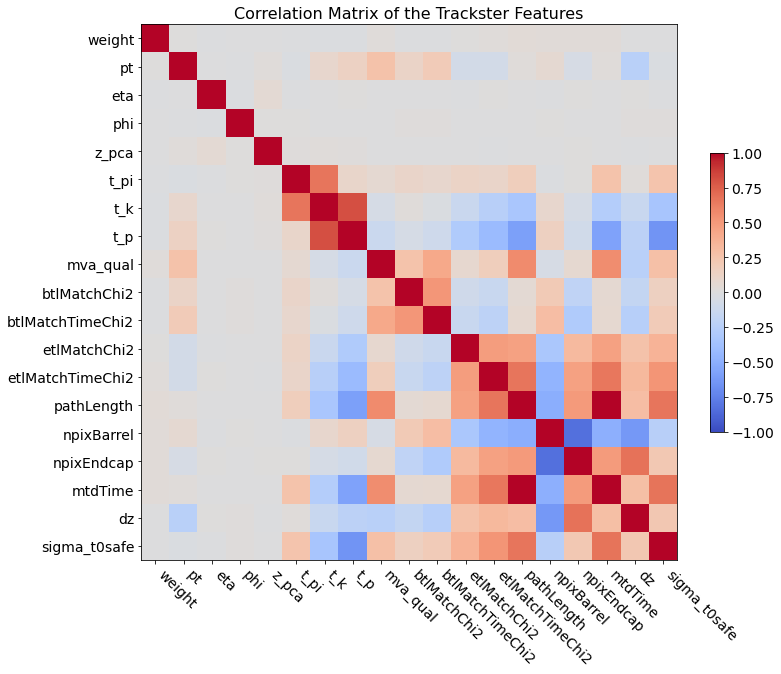

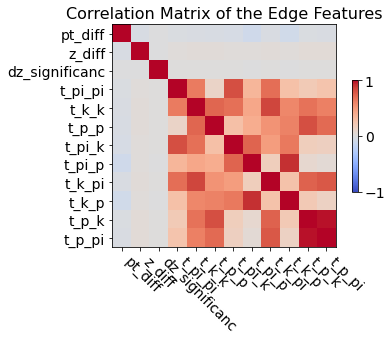

In [16]:
print(corr_matrix.shape)
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)


node_feature_names = ["weight", "pt", "eta", "phi", "z_pca", "t_pi", "t_k",  "t_p", "mva_qual", "btlMatchChi2", 
                 "btlMatchTimeChi2", "etlMatchChi2", "etlMatchTimeChi2", "pathLength", "npixBarrel", "npixEndcap",
                 "mtdTime", "dz", "sigma_t0safe"]


plt.xticks(range(len(node_feature_names)), node_feature_names, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(node_feature_names)), node_feature_names, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)

f.savefig('export/node_correlation_matrix.pdf', dpi=300,
           bbox_inches='tight', transparent=True)
f.savefig('export/node_correlation_matrix.png', dpi=300,
           bbox_inches='tight', transparent=True)
plt.show()

edge_feature_names = ["pt_diff", "z_diff", "dz_significanc", "t_pi_pi", "t_k_k", "t_p_p", "t_pi_k", "t_pi_p", "t_k_pi", "t_k_p", "t_p_k", "t_p_pi"]
f = plt.figure(figsize=(6, 4))
plt.matshow(corr_matrix_edge_f, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(edge_feature_names)), edge_feature_names, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(edge_feature_names)), edge_feature_names, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Edge Features', fontsize=16)

f.savefig('export/edge_features_correlation_matrix.pdf', dpi=300,
           bbox_inches='tight', transparent=True)
f.savefig('export/edge_features_correlation_matrix.png', dpi=300,
           bbox_inches='tight', transparent=True)
plt.show()

Processing plot number 1
Processing plot number 2
Processing plot number 3
Processing plot number 4
Processing plot number 5
Processing plot number 6
Processing plot number 7
Processing plot number 8
Processing plot number 9
Processing plot number 10
Processing plot number 11
Processing plot number 12
Processing plot number 13
Processing plot number 14
Processing plot number 15
Processing plot number 16
Processing plot number 17
Processing plot number 18
Processing plot number 19


/tmp/ipykernel_2399/3272971445.py:19: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


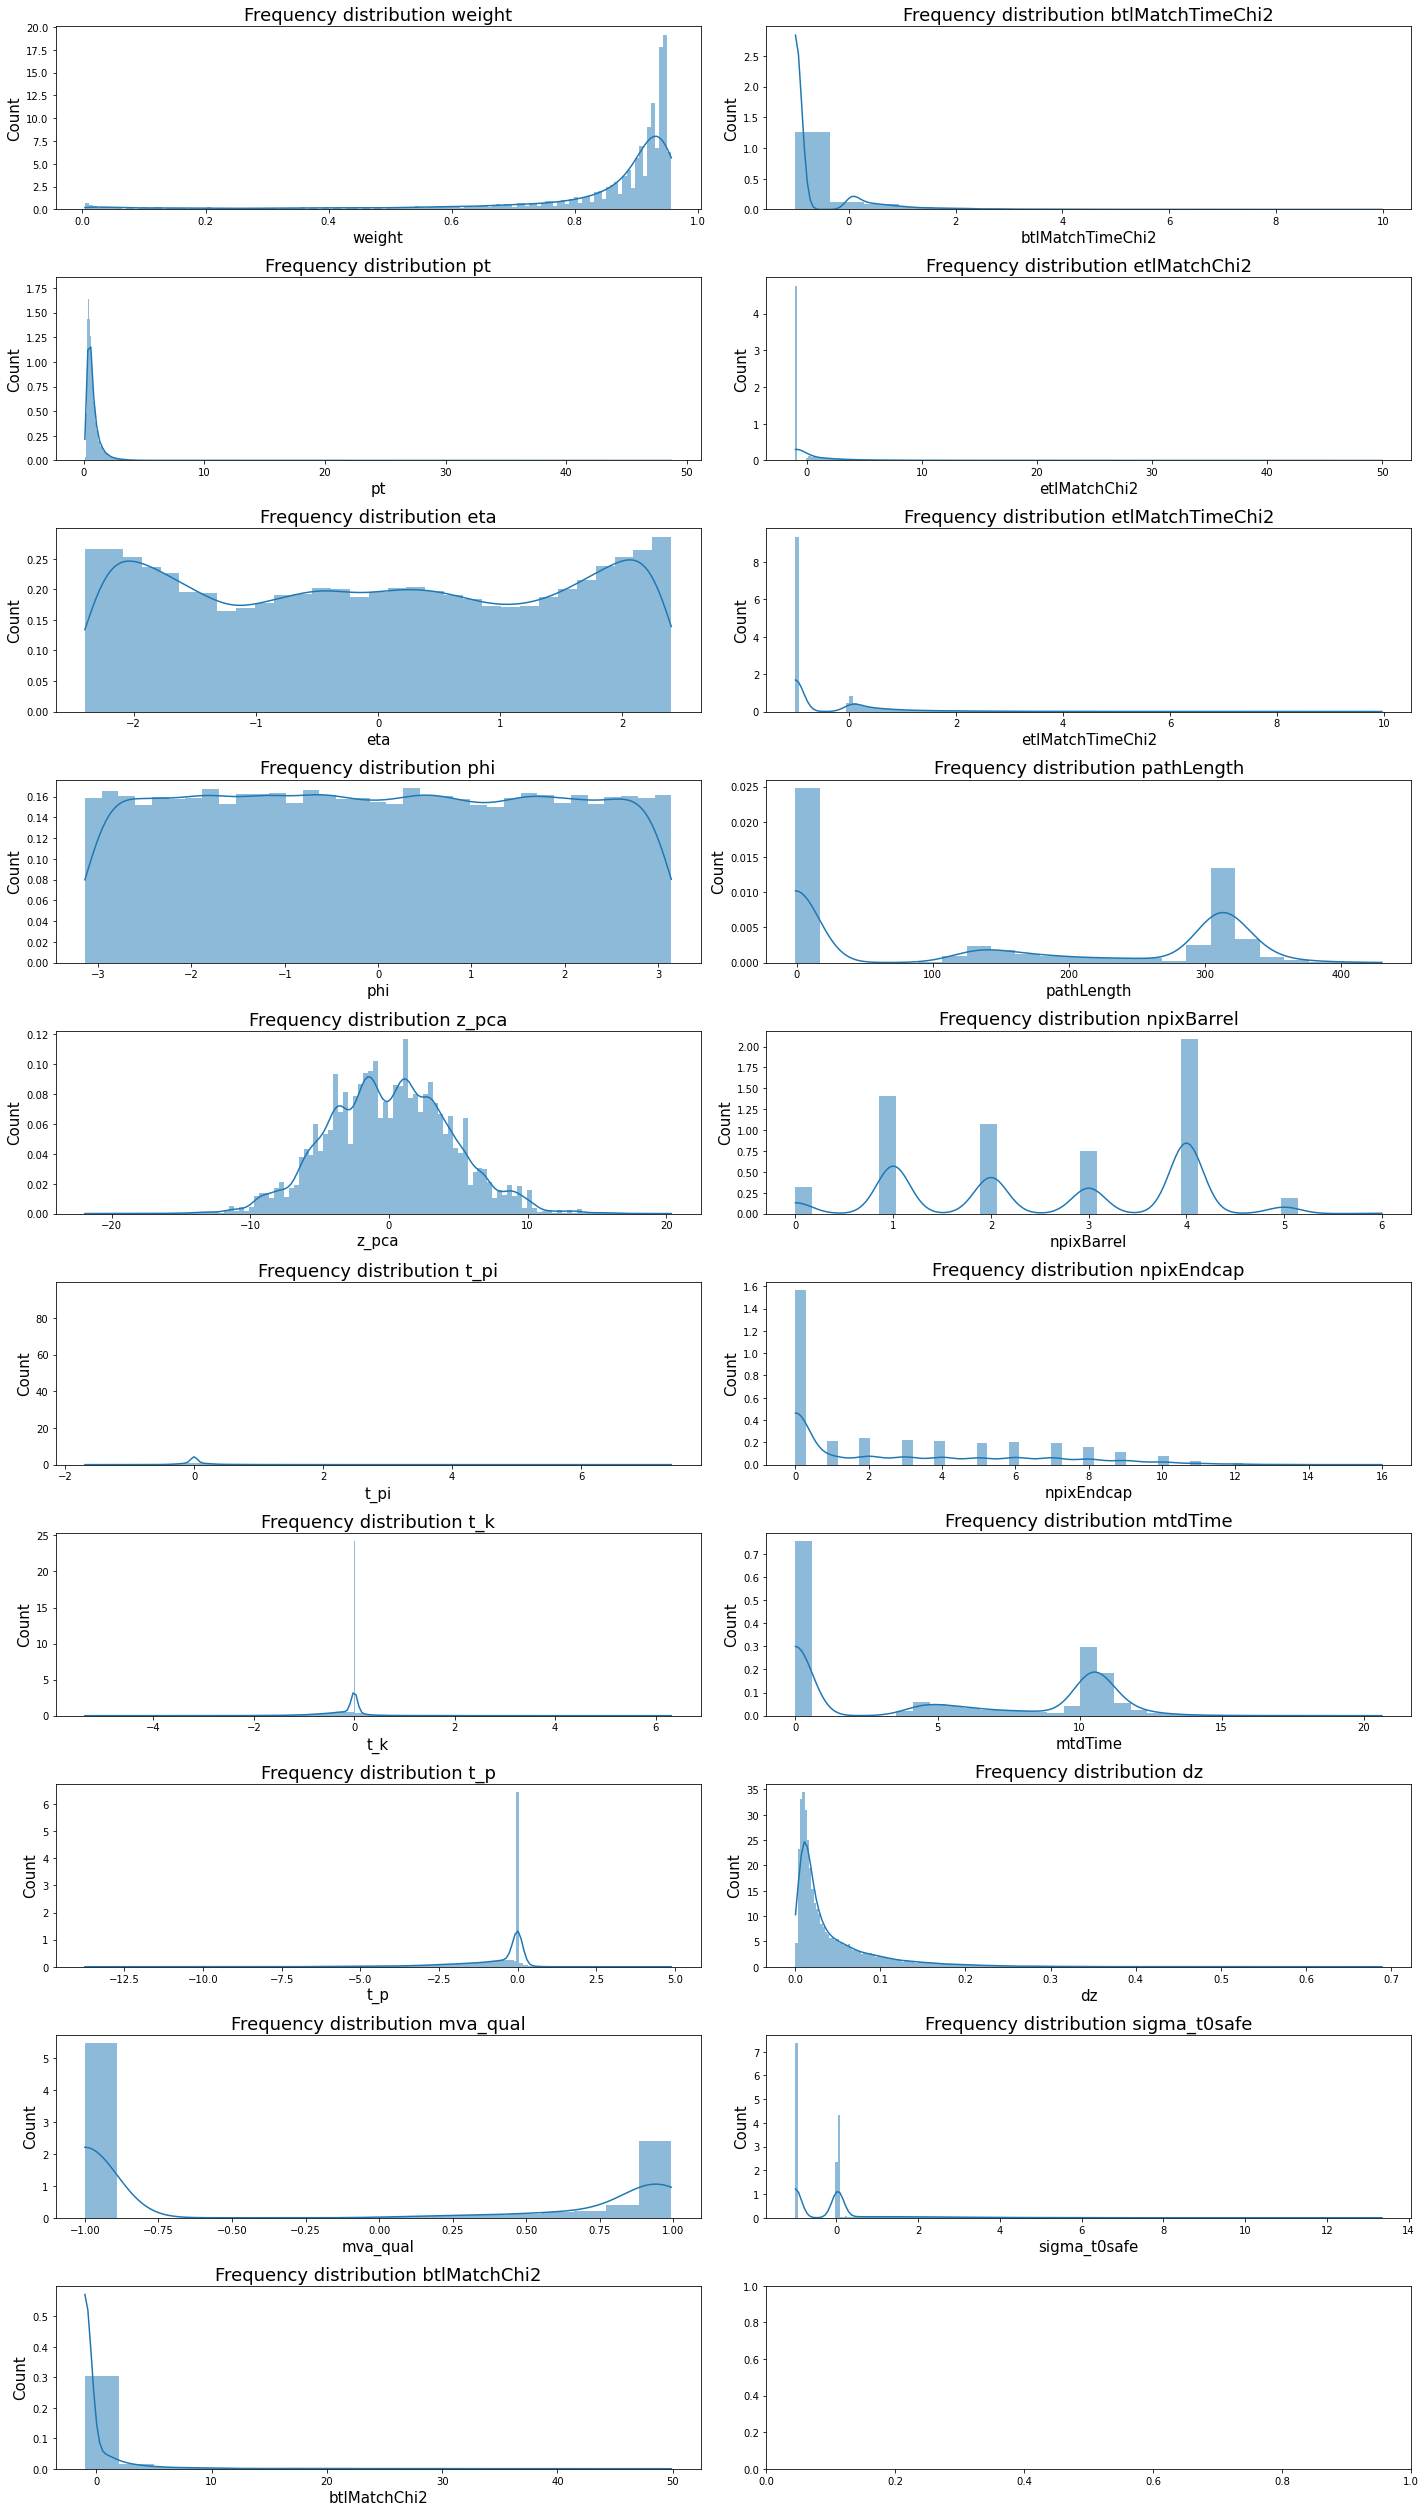

In [18]:
import seaborn as sns

start = 0
stop = len(node_feature_names)
scols = int(np.ceil(len(node_feature_names[start:stop])/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i, col in enumerate(node_feature_names[start:stop], start=start):
    print(f"Processing plot number {i+1}")
    ax_col = int((i-start)%scols)
    ax_row = int((i-start)/scols)

    sns.histplot(all_features[:, i], ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ col, fontsize=18)
    axes[ax_col, ax_row].set_xlabel(col, fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

Processing plot number 1
Processing plot number 2
Processing plot number 3
Processing plot number 4
Processing plot number 5
Processing plot number 6
Processing plot number 7
Processing plot number 8
Processing plot number 9
Processing plot number 10
Processing plot number 11
Processing plot number 12


/tmp/ipykernel_2399/3625370288.py:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


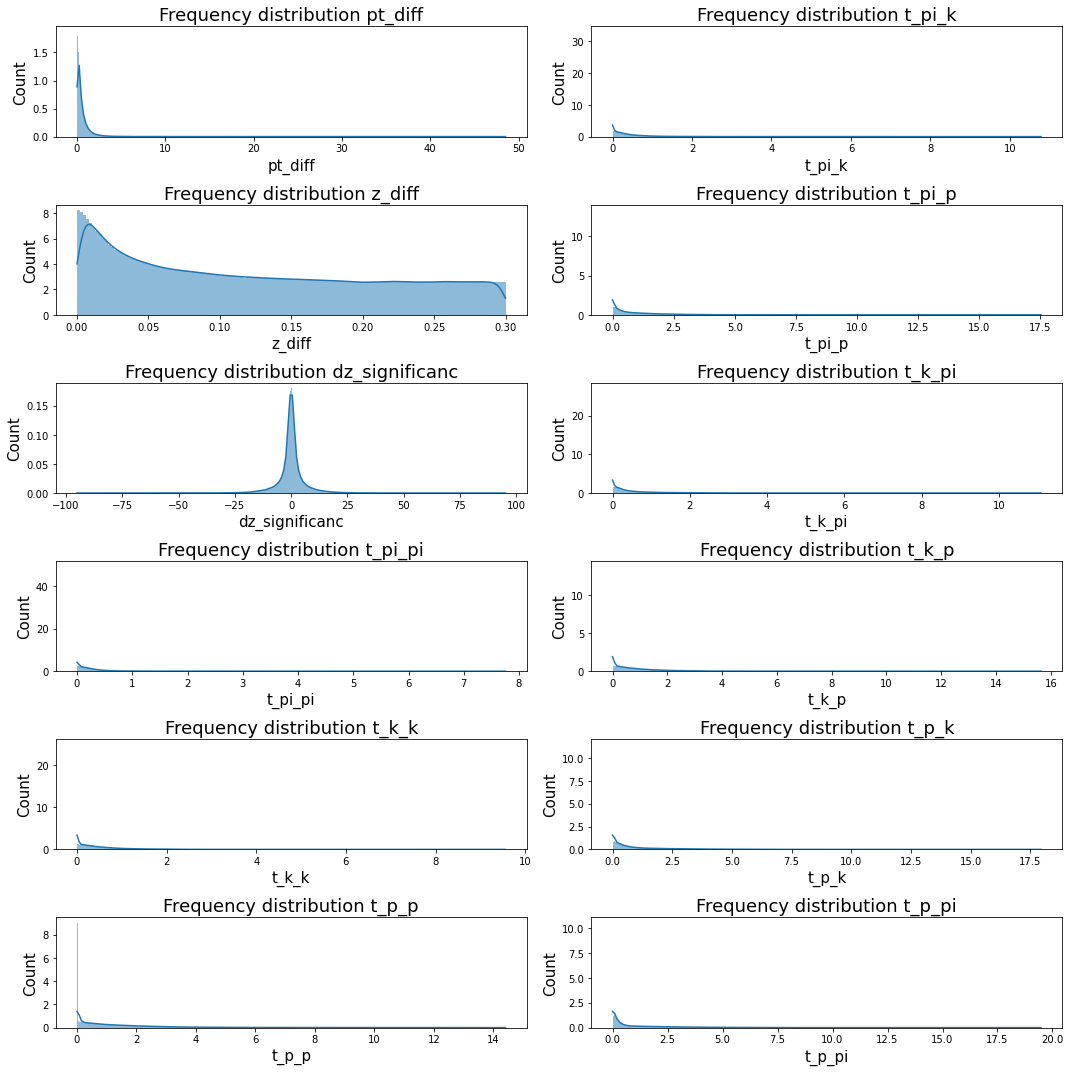

In [19]:
scols = int(np.ceil(len(edge_feature_names)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(15, 15), constrained_layout=True)

for i, col in enumerate(edge_feature_names):
    print(f"Processing plot number {i+1}")
    ax_col = int(i%scols)
    ax_row = int(i/scols)

    sns.histplot(all_edge_features[:, i], ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ col, fontsize=18)
    axes[ax_col, ax_row].set_xlabel(col, fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [21]:
import pandas as pd

df = pd.DataFrame(all_features, columns = node_feature_names)
df.describe()

,weight,pt,eta,phi,z_pca,t_pi,t_k,t_p,mva_qual,btlMatchChi2,btlMatchTimeChi2,etlMatchChi2,etlMatchTimeChi2,pathLength,npixBarrel,npixEndcap,mtdTime,dz,sigma_t0safe
count,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000,40236.000000
mean,0.824112,0.817962,0.003892,-0.006357,0.046257,0.089984,-0.168287,-0.809498,-0.269364,0.234964,-0.643188,1.868105,-0.295729,149.188614,2.598221,2.745849,5.104822,0.043707,-0.108383
std,0.207433,1.108353,1.466414,1.814341,4.418338,0.428975,0.512478,1.299967,0.910692,4.766500,0.954482,7.207250,1.233620,145.129837,1.407739,3.277441,4.937065,0.052014,1.214268
min,0.003922,0.105708,-2.399662,-3.141485,-21.930439,-1.692897,-5.362281,-13.751674,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000677,-1.000000
25%,0.823529,0.416389,-1.340831,-1.578087,-3.137890,0.000000,-0.321074,-1.227802,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.011181,-1.000000
50%,0.909804,0.593600,0.004065,-0.016982,0.019990,0.000000,0.000000,-0.056052,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,140.255074,3.000000,1.000000,4.883273,0.022358,0.027613
75%,0.937255,0.918733,1.340119,1.570038,3.019057,0.080857,0.000000,0.000000,0.904075,-1.000000,-1.000000,1.262926,0.156646,309.419945,4.000000,5.000000,10.391216,0.056801,0.039000
max,0.956863,48.711708,2.399817,3.141492,20.360340,7.396173,6.310977,4.881129,0.993402,49.873592,9.982451,49.974819,9.959703,430.157623,6.000000,16.000000,20.638599,0.688877,13.348296


In [22]:
df = pd.DataFrame(all_edge_features, columns = edge_feature_names)
df.describe()

,pt_diff,z_diff,dz_significanc,t_pi_pi,t_k_k,t_p_p,t_pi_k,t_pi_p,t_k_pi,t_k_p,t_p_k,t_p_pi
count,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06,3.342170e+06
mean,6.562145e-01,1.256585e-01,-2.124081e-02,2.967883e-01,4.586386e-01,1.207495e+00,3.810269e-01,8.432494e-01,4.456064e-01,8.222667e-01,1.030867e+00,1.069581e+00
std,1.559127e+00,9.079920e-02,5.783124e+00,5.324851e-01,5.663563e-01,1.391310e+00,5.589481e-01,1.120522e+00,6.160929e-01,1.015490e+00,1.404797e+00,1.505421e+00
min,4.587225e-07,0.000000e+00,-9.515474e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.421849e-01,4.159093e-02,-1.712325e+00,2.275372e-02,4.463768e-02,1.039953e-01,3.358269e-02,5.501747e-02,3.505373e-02,7.387924e-02,6.271935e-02,4.654598e-02
50%,3.371282e-01,1.132490e-01,-5.313440e-03,1.426678e-01,2.763014e-01,7.276549e-01,2.043257e-01,3.861008e-01,2.141867e-01,4.831305e-01,4.249725e-01,3.203678e-01
75%,7.220845e-01,2.035124e-01,1.681735e+00,3.336763e-01,6.613204e-01,1.821998e+00,4.993544e-01,1.233292e+00,6.054640e-01,1.190589e+00,1.442300e+00,1.612640e+00
max,4.850836e+01,2.999997e-01,9.519756e+01,7.754889e+00,9.560025e+00,1.440765e+01,1.078204e+01,1.753842e+01,1.108958e+01,1.564070e+01,1.794942e+01,1.947898e+01
